## Controle Quântico Ótimo - Utilização do CG para ajuste do caminho percorrido por uma partícula

Nessa etapa, é necessário avaliar, a partir da equação de Heisenberg, com o método de Runge-Kutta e com o controle MPC, como a curva de origem ajusta-se a curva de destino. Além disso, é interessantíssimo a avaliação a partir do estado estacionário e ainda verificar como ocorre o ajuste de fases.

Para analisar como o controle melhora o condicionamento da curva através da sua análise futura, esse arquivo estará analisando os ajustes no horizonte 3 ao 10.

Nesse projeto usa-se o gradiente devido a sua facilidade de reprodução, vide os projetos fora da biblioteca do python, além dos problemas do cálculo da Hessiana na otimização não linear utilizando o método de Newton e suas variantes.

In [1]:
# Bilbiotecas para auxílio na programação matemática
import math, sys 
import numpy as np
import sympy as sp

from scipy import sparse # Produção das diagonais das matrizes
from scipy.sparse import diags 

# Plotagem 2D e 3D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm


from os import path # Suficiente para manipulação de arquivos
    
# Para solução exata
from scipy.special import hermite
from math import factorial

%matplotlib inline
count = 0

# Para otimização dos sistemas
from scipy import optimize

import random

Abaixo se dão os requisitos básicos para a instauração do teste. Se tem formas de subtrair e somar matrizes, a manipulação das derivadas com o Runge-Kutta além da própria proposta da função objetivo.

In [2]:
# Manipulação das matrizes

def somar(A, B):
    C = []
    nLinhasA, nLinhasB = len(A), len(B)
    nColA, nColB = len(A[0]), len(B[0])
    
    for i in range (nLinhasA):
        linha = [0]*nColA
        C.append(linha)
        for j in range(nColA):
            C[i][j] = A[i][j] + B[i][j]

    return C

def sub(A, B):
    C = []
    nLinhasA, nLinhasB = len(A), len(B)
    nColA, nColB = len(A[0]), len(B[0])
    
    for i in range (nLinhasA):
        linha = [0]*nColA
        C.append(linha)
        for j in range(nColA):
            C[i][j] = A[i][j] - B[i][j]

    return C


#################################################################

## d (psi) / dt = -i * H * |psi>
def dpsidt(t, psi, H): # A derivada da onda em relação ao tempo não tem dependência temporal
    A = np.zeros((2,2), dtype=np.complex_)
    A = np.dot(complex(0,1),H) # i * H
    return -1*np.matmul(A,psi) # - i * H * |psi>

# Runge-Kutta de quarta ordem

def rungeKutta(onda, fatorRungeKutta, hamiltoniano, tempoFinal = 2, tempoInicial = 0):
    
    resultado = np.zeros((2,2), dtype=np.complex_)
    indice = 0

    for i in range(0, 2):
        
        resultado[0][indice] = onda[0][0]
        resultado[1][indice] = onda[1][0]
        
        k1 = dpsidt(tempoInicial, onda, hamiltoniano)
        k2 = dpsidt(tempoInicial + 0.5 * fatorRungeKutta, somar(onda, np.dot((0.5*fatorRungeKutta), k1)), hamiltoniano)
        k3 = dpsidt(tempoInicial + 0.5 * fatorRungeKutta, somar(onda, np.dot((0.5*fatorRungeKutta), k2)), hamiltoniano)
        k4 = dpsidt(tempoInicial + fatorRungeKutta, somar(onda, np.dot(fatorRungeKutta, k3)), hamiltoniano)
        
        ## y(i+1) = y(i) + h/6*(k1+2*k2+2*k3+k4)
        
        A = somar(np.dot(2,k3), k4)
        B = somar(np.dot(2,k2), k1)
        C = somar(A, B)
 
        onda = somar(onda,np.dot((fatorRungeKutta / 6.0),(C)))
    
        tempoInicial += fatorRungeKutta
        
        indice += 1
        
    runge = np.zeros((2,1), dtype=np.complex_)
    runge[0][0] = resultado[0][indice-1]
    runge[1][0] = resultado[1][indice-1]
    return runge

def funcaoObjetivo(x, iteracao, ondaDestino, hamiltoniano, onda, horizonteAnalisavel, fatorRungeKutta, tempoAnalise):
    
    avanco = np.zeros((2,1),dtype=np.complex_)
    
    y = 0
    
    horizonte = (horizonteAnalisavel+iteracao)/100
    
    tempo = iteracao/100
    
    tempoInicialAnalise = 0.00
    tempoFinalAnalise = 0.02
    
    controles = np.zeros((2,2), dtype=np.complex_)
    controles = [[0, x[0]], [x[0], 0]]
    
    matrizOrigem = np.zeros((2,1),dtype=np.complex_)
    matrizOrigem = [[onda[0][0]], [onda[1][0]]] 

    matrizDestino = np.zeros((2,1),dtype=np.complex_)
    
    ## Função-Objetivo (Return) = somatorio ||(Matriz_Origem - Matriz_Destino)||^2
    
    ## Avanço temporal
    
    matrizDestino[0][0] = ondaDestino[0][0]*np.exp(-1*complex(0,1)*(1/2*np.pi)*tempo)
    matrizDestino[1][0] = ondaDestino[1][0]*np.exp(-1*complex(0,1)*(3/2*np.pi)*tempo)

    y += (np.linalg.norm(matrizOrigem-matrizDestino))**2

    avanco = rungeKutta(matrizOrigem, fatorRungeKutta, somar(hamiltoniano, controles), tempoFinal = tempoFinalAnalise, tempoInicial = tempoInicialAnalise)

    matrizOrigem = avanco

    tempoInicialAnalise += 0.01
    tempoFinalAnalise += 0.01
    
    for indice in range((iteracao+1), (horizonteAnalisavel+iteracao)):
        tempo = indice/100
        
        matrizDestino[0][0] = ondaDestino[0][0]*np.exp(-1*complex(0,1)*(1/2*np.pi)*tempo)
        matrizDestino[1][0] = ondaDestino[1][0]*np.exp(-1*complex(0,1)*(3/2*np.pi)*tempo)
        
        y += (np.linalg.norm(matrizOrigem-matrizDestino))**2
        
        controles = [[0, x[int(tempoInicialAnalise*100)]], [x[int(tempoInicialAnalise*100)], 0]]

        avanco = rungeKutta(matrizOrigem, fatorRungeKutta, somar(hamiltoniano, controles), tempoFinal = tempoFinalAnalise, tempoInicial = tempoInicialAnalise)

        matrizOrigem = avanco

        tempoInicialAnalise += 0.01
        tempoFinalAnalise += 0.01
    
    return y

Para o funcionamento do MPC, cria-se um looping que consiste em uma otimização não linear, com o apoio da biblioteca de otimização do pyhton, de forma a obter o melhor resultado para o ajuste da curva. Com esse valor em mãos, utiliza-se para os pontos da próxima iteração do método de controle além de efetivar o ajuste realizando o Runge-Kutta com o valor otimizado.

In [3]:
## Constantes

horizonte = 3
fatorRungeKutta = 0.01

## Chute inicial

x = []
x.append(random.uniform(-1, 1))
for l in range(1, horizonte):
    x.append(x[0])

# Função de origem e destino

ondaOrigem = [[complex(0.80,0.0)],[complex(0.60,0.0)]]
ondaDestino = [[complex(1/np.sqrt(2),0.0)],[complex(1/np.sqrt(2),0.0)]]

# Análise das respostas

minimos3 = np.zeros((1,2000), dtype=np.complex_) # Verificar se o mínimo será zero
constantes3 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
valoresOnda3 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo3 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

# Hamiltoniano

hamiltoniano = np.zeros((2,2), dtype=np.complex_) 
hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]

iteracao = 0
tempoAnalise = 2000

while iteracao < tempoAnalise:
    
    print(f"Iteração: {iteracao+1}")
    
    # Variação do Psi
    valoresOnda3[0][iteracao] = ondaOrigem[0][0]
    valoresOnda3[1][iteracao] = ondaOrigem[1][0]
    
    # Obtenção das constantes que multiplicam Psi
    constantes3[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/10)
    constantes3[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/10)
        
    ## Minimização
    
    resultado = optimize.minimize(funcaoObjetivo, x, args=(iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise), method='CG')

    print(f"Mínimo: {resultado.x}")
    
    # Função objetivo
    
    minimos3[0][iteracao] = resultado.x[0]
    
    valoresFuncaoObjetivo3[0][iteracao] = funcaoObjetivo(resultado.x, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    
    print(f" Conferindo: {valoresFuncaoObjetivo3[0][iteracao]}")
    
    ## Hamiltoniano corntrolado
    
    controle = np.zeros((2,1), dtype=np.complex_)
    controle = [[0, resultado.x[0]],[resultado.x[0], 0]]
    hamiltoniano = somar(hamiltoniano, controle)
    
    ## Adaptação da onda ao controle
    
    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.02, tempoInicial = 0)
    
    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]
    
    # Reset
    hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    x = []
    for l in range(0, horizonte):
        x.append(resultado.x[0])
    
    iteracao += 1

Iteração: 1
Mínimo: [-0.23490249  0.92003241  0.97427111]
 Conferindo: (0.060253280624424824+0j)
Iteração: 2
Mínimo: [ 0.45086509  0.90753757 -0.23490249]
 Conferindo: (0.060147911185120986+0j)
Iteração: 3
Mínimo: [0.45004003 0.90403752 0.45086509]
 Conferindo: (0.059966428030399796+0j)
Iteração: 4
Mínimo: [0.44708911 0.90352332 0.45004003]
 Conferindo: (0.05978594884871061+0j)
Iteração: 5
Mínimo: [0.4483221  0.90058181 0.44708911]
 Conferindo: (0.059606246898951526+0j)
Iteração: 6
Mínimo: [0.44500095 0.90074976 0.4483221 ]
 Conferindo: (0.05942709699988853+0j)
Iteração: 7
Mínimo: [0.44735368 0.89717037 0.44500095]
 Conferindo: (0.059248611206847115+0j)
Iteração: 8
Mínimo: [0.44285441 0.89840074 0.44735368]
 Conferindo: (0.05907060442602921+0j)
Iteração: 9
Mínimo: [0.44675555 0.89367534 0.44285441]
 Conferindo: (0.0588932848769972+0j)
Iteração: 10
Mínimo: [0.44033452 0.89615229 0.44675555]
 Conferindo: (0.05871640246642638+0j)
Iteração: 11
Mínimo: [0.44661175 0.8897881  0.44033452]
 Co

Mínimo: [0.41839684 0.66534821 0.37378642]
 Conferindo: (0.047190584045275236+0j)
Iteração: 91
Mínimo: [0.31409145 0.73135411 0.41839684]
 Conferindo: (0.04707474972936794+0j)
Iteração: 92
Mínimo: [0.37043118 0.73534228 0.31409145]
 Conferindo: (0.0469627002567912+0j)
Iteração: 93
Mínimo: [0.41473845 0.6593589  0.37043118]
 Conferindo: (0.04684439765270404+0j)
Iteração: 94
Mínimo: [0.31125096 0.72490816 0.41473845]
 Conferindo: (0.04673059580771692+0j)
Iteração: 95
Mínimo: [0.36729182 0.72871652 0.31125096]
 Conferindo: (0.04662052196419388+0j)
Iteração: 96
Mínimo: [0.41084682 0.65361467 0.36729182]
 Conferindo: (0.04650431470394971+0j)
Iteração: 97
Mínimo: [0.30859837 0.71829393 0.41084682]
 Conferindo: (0.046392547570919956+0j)
Iteração: 98
Mínimo: [0.36386553 0.72214504 0.30859837]
 Conferindo: (0.046284434970284734+0j)
Iteração: 99
Mínimo: [0.40723495 0.64775762 0.36386553]
 Conferindo: (0.04617031756339197+0j)
Iteração: 100
Mínimo: [0.30576967 0.71177494 0.40723495]
 Conferindo: (

Mínimo: [0.31025123 0.4936893  0.27774091]
 Conferindo: (0.03945925415832278+0j)
Iteração: 178
Mínimo: [0.23317414 0.54175851 0.31025123]
 Conferindo: (0.03939547165124084+0j)
Iteração: 179
Mínimo: [0.27452377 0.54411207 0.23317414]
 Conferindo: (0.03933387746650445+0j)
Iteração: 180
Mínimo: [0.30668121 0.48792275 0.27452377]
 Conferindo: (0.039268979015436946+0j)
Iteração: 181
Mínimo: [0.23045038 0.53555674 0.30668121]
 Conferindo: (0.03920665575959625+0j)
Iteração: 182
Mínimo: [0.27141756 0.53786036 0.23045038]
 Conferindo: (0.039146470341639664+0j)
Iteração: 183
Mínimo: [0.30306963 0.48244944 0.27141756]
 Conferindo: (0.039083056258993054+0j)
Iteração: 184
Mínimo: [0.22784466 0.52932765 0.30306963]
 Conferindo: (0.039022163905173365+0j)
Iteração: 185
Mínimo: [0.26824804 0.53158444 0.22784466]
 Conferindo: (0.03896335835332066+0j)
Iteração: 186
Mínimo: [0.29959316 0.47670604 0.26824804]
 Conferindo: (0.038901405621909455+0j)
Iteração: 187
Mínimo: [0.22520213 0.52312019 0.29959316]
 C

Mínimo: [0.26072231 0.27590513 0.16120409]
 Conferindo: (0.03528783698721395+0j)
Iteração: 270
Mínimo: [0.12167768 0.3506541  0.26072231]
 Conferindo: (0.035259439680743014+0j)
Iteração: 271
Mínimo: [0.17958196 0.36728278 0.12167768]
 Conferindo: (0.03523380834866264+0j)
Iteração: 272
Mínimo: [0.25252754 0.27759621 0.17958196]
 Conferindo: (0.03520443932816393+0j)
Iteração: 273
Mínimo: [0.11815885 0.35776977 0.25252754]
 Conferindo: (0.03517677339086143+0j)
Iteração: 274
Mínimo: [0.18509582 0.3597589  0.11815885]
 Conferindo: (0.03515143625021608+0j)
Iteração: 275
Mínimo: [0.24608862 0.27724218 0.18509582]
 Conferindo: (0.03512252856236016+0j)
Iteração: 276
Mínimo: [0.11326794 0.36184774 0.24608862]
 Conferindo: (0.035095747030476035+0j)
Iteração: 277
Mínimo: [0.18920492 0.35215845 0.11326794]
 Conferindo: (0.03507088660848333+0j)
Iteração: 278
Mínimo: [0.19491225 0.33212019 0.18920492]
 Conferindo: (0.03504209432131001+0j)
Iteração: 279
Mínimo: [0.164489   0.35027695 0.19491225]
 Conf

Mínimo: [0.10733452 0.18539713 0.17984758]
 Conferindo: (0.03362012963150095+0j)
Iteração: 357
Mínimo: [0.15672629 0.18393115 0.10733452]
 Conferindo: (0.03360861622399003+0j)
Iteração: 358
Mínimo: [0.11242198 0.16376702 0.15672629]
 Conferindo: (0.033597220110619844+0j)
Iteração: 359
Mínimo: [0.14327249 0.18822818 0.11242198]
 Conferindo: (0.03358644316504567+0j)
Iteração: 360
Mínimo: [0.14327249 0.14327249 0.14327249]
 Conferindo: (0.03357610342960039+0j)
Iteração: 361
Mínimo: [0.06453528 0.22356976 0.14327249]
 Conferindo: (0.033566189255333306+0j)
Iteração: 362
Mínimo: [0.1635582  0.19603199 0.06453528]
 Conferindo: (0.03355575004432633+0j)
Iteração: 363
Mínimo: [0.11864189 0.16215791 0.1635582 ]
 Conferindo: (0.03354393997449266+0j)
Iteração: 364
Mínimo: [0.14608753 0.16432506 0.11864189]
 Conferindo: (0.03353361209630567+0j)
Iteração: 365
Mínimo: [0.07241546 0.21795579 0.14608753]
 Conferindo: (0.03352339490072735+0j)
Iteração: 366
Mínimo: [0.15595981 0.1534173  0.07241546]
 Conf

Mínimo: [0.09670106 0.09670106 0.09670106]
 Conferindo: (0.0329335400763579+0j)
Iteração: 453
Mínimo: [0.06303358 0.10156567 0.09670106]
 Conferindo: (0.03292941003518153+0j)
Iteração: 454
Mínimo: [0.08698911 0.0895081  0.06303358]
 Conferindo: (0.03292518796853525+0j)
Iteração: 455
Mínimo: [0.08698911 0.08698911 0.08698911]
 Conferindo: (0.03292038786023357+0j)
Iteração: 456
Mínimo: [0.08698911 0.08698911 0.08698911]
 Conferindo: (0.032915697953746846+0j)
Iteração: 457
Mínimo: [0.08698911 0.08698911 0.08698911]
 Conferindo: (0.032911161482763164+0j)
Iteração: 458
Mínimo: [0.08698911 0.08698911 0.08698911]
 Conferindo: (0.03290679735697639+0j)
Iteração: 459
Mínimo: [0.08698911 0.08698911 0.08698911]
 Conferindo: (0.03290262431914951+0j)
Iteração: 460
Mínimo: [0.08698911 0.08698911 0.08698911]
 Conferindo: (0.03289866092658781+0j)
Iteração: 461
Mínimo: [0.08698911 0.08698911 0.08698911]
 Conferindo: (0.03289492553279857+0j)
Iteração: 462
Mínimo: [0.08698911 0.08698911 0.08698911]
 Confe

Mínimo: [0.05272496 0.05312668 0.0317823 ]
 Conferindo: (0.03262898463040496+0j)
Iteração: 553
Mínimo: [0.05272496 0.05272496 0.05272496]
 Conferindo: (0.032627006054255316+0j)
Iteração: 554
Mínimo: [0.05272496 0.05272496 0.05272496]
 Conferindo: (0.03262493394392871+0j)
Iteração: 555
Mínimo: [0.05272496 0.05272496 0.05272496]
 Conferindo: (0.03262277863517928+0j)
Iteração: 556
Mínimo: [0.05272496 0.05272496 0.05272496]
 Conferindo: (0.03262054763372593+0j)
Iteração: 557
Mínimo: [0.05272496 0.05272496 0.05272496]
 Conferindo: (0.03261824852049182+0j)
Iteração: 558
Mínimo: [0.06479998 0.06639668 0.05272496]
 Conferindo: (0.03261572575093783+0j)
Iteração: 559
Mínimo: [0.06479998 0.06479998 0.06479998]
 Conferindo: (0.03261347125643954+0j)
Iteração: 560
Mínimo: [0.06479998 0.06479998 0.06479998]
 Conferindo: (0.03261162224951359+0j)
Iteração: 561
Mínimo: [0.04960339 0.06298081 0.06479998]
 Conferindo: (0.03261007695368932+0j)
Iteração: 562
Mínimo: [0.04960339 0.04960339 0.04960339]
 Confe

Mínimo: [0.03338917 0.03338917 0.03338917]
 Conferindo: (0.03249498413818427+0j)
Iteração: 646
Mínimo: [0.03338917 0.03338917 0.03338917]
 Conferindo: (0.03249418894226343+0j)
Iteração: 647
Mínimo: [0.03338917 0.03338917 0.03338917]
 Conferindo: (0.032493321787102854+0j)
Iteração: 648
Mínimo: [0.03338917 0.03338917 0.03338917]
 Conferindo: (0.03249238569809748+0j)
Iteração: 649
Mínimo: [0.03338917 0.03338917 0.03338917]
 Conferindo: (0.03249138376876105+0j)
Iteração: 650
Mínimo: [0.03338917 0.03338917 0.03338917]
 Conferindo: (0.03249031915767271+0j)
Iteração: 651
Mínimo: [0.03338917 0.03338917 0.03338917]
 Conferindo: (0.03248919508535849+0j)
Iteração: 652
Mínimo: [0.04740158 0.04565996 0.03338917]
 Conferindo: (0.03248784902691829+0j)
Iteração: 653
Mínimo: [0.04740158 0.04740158 0.04740158]
 Conferindo: (0.03248668852777738+0j)
Iteração: 654
Mínimo: [0.04740158 0.04740158 0.04740158]
 Conferindo: (0.03248586205308563+0j)
Iteração: 655
Mínimo: [0.03110599 0.04246148 0.04740158]
 Confe

Mínimo: [0.01924327 0.01924327 0.01924327]
 Conferindo: (0.03242906172584618+0j)
Iteração: 748
Mínimo: [0.01924327 0.01924327 0.01924327]
 Conferindo: (0.03242880408402852+0j)
Iteração: 749
Mínimo: [0.01924327 0.01924327 0.01924327]
 Conferindo: (0.03242849779742884+0j)
Iteração: 750
Mínimo: [0.01924327 0.01924327 0.01924327]
 Conferindo: (0.03242814389048563+0j)
Iteração: 751
Mínimo: [0.01924327 0.01924327 0.01924327]
 Conferindo: (0.0324277434346424+0j)
Iteração: 752
Mínimo: [0.01924327 0.01924327 0.01924327]
 Conferindo: (0.03242729754729487+0j)
Iteração: 753
Mínimo: [0.01924327 0.01924327 0.01924327]
 Conferindo: (0.03242680739068404+0j)
Iteração: 754
Mínimo: [0.03398284 0.03022056 0.01924327]
 Conferindo: (0.032426114251426+0j)
Iteração: 755
Mínimo: [0.03398284 0.03398284 0.03398284]
 Conferindo: (0.03242553912564823+0j)
Iteração: 756
Mínimo: [0.03398284 0.03398284 0.03398284]
 Conferindo: (0.03242520215215301+0j)
Iteração: 757
Mínimo: [0.01833496 0.02765708 0.03398284]
 Conferind

Mínimo: [0.01143332 0.01895025 0.02515843]
 Conferindo: (0.03240112175128445+0j)
Iteração: 847
Mínimo: [0.01143332 0.01143332 0.01143332]
 Conferindo: (0.03240105185922228+0j)
Iteração: 848
Mínimo: [0.01143332 0.01143332 0.01143332]
 Conferindo: (0.03240095673529749+0j)
Iteração: 849
Mínimo: [0.01143332 0.01143332 0.01143332]
 Conferindo: (0.03240083803585907+0j)
Iteração: 850
Mínimo: [0.01143332 0.01143332 0.01143332]
 Conferindo: (0.032400696132934344+0j)
Iteração: 851
Mínimo: [0.01143332 0.01143332 0.01143332]
 Conferindo: (0.03240053142145494+0j)
Iteração: 852
Mínimo: [0.01143332 0.01143332 0.01143332]
 Conferindo: (0.03240034431885996+0j)
Iteração: 853
Mínimo: [0.01143332 0.01143332 0.01143332]
 Conferindo: (0.03240013526469046+0j)
Iteração: 854
Mínimo: [0.01143332 0.01143332 0.01143332]
 Conferindo: (0.03239990472014891+0j)
Iteração: 855
Mínimo: [0.02519783 0.02068869 0.01143332]
 Conferindo: (0.03239952327837396+0j)
Iteração: 856
Mínimo: [0.02519783 0.02519783 0.02519783]
 Confe

 Conferindo: (0.03239019792467487+0j)
Iteração: 935
Mínimo: [0.00059714 0.00059714 0.00059714]
 Conferindo: (0.032390195173093016+0j)
Iteração: 936
Mínimo: [0.00059714 0.00059714 0.00059714]
 Conferindo: (0.03239018971519236+0j)
Iteração: 937
Mínimo: [0.00059714 0.00059714 0.00059714]
 Conferindo: (0.032390180921645105+0j)
Iteração: 938
Mínimo: [0.01785761 0.0118344  0.00059714]
 Conferindo: (0.032389968602848616+0j)
Iteração: 939
Mínimo: [0.01785761 0.01785761 0.01785761]
 Conferindo: (0.03238978875863093+0j)
Iteração: 940
Mínimo: [0.01785761 0.01785761 0.01785761]
 Conferindo: (0.032389706713732654+0j)
Iteração: 941
Mínimo: [0.01785761 0.01785761 0.01785761]
 Conferindo: (0.032389711407528124+0j)
Iteração: 942
Mínimo: [0.00343204 0.01083583 0.01785761]
 Conferindo: (0.03238968141329733+0j)
Iteração: 943
Mínimo: [0.00343204 0.00343204 0.00343204]
 Conferindo: (0.032389670115263655+0j)
Iteração: 944
Mínimo: [0.00343204 0.00343204 0.00343204]
 Conferindo: (0.03238964710490816+0j)
Iteraç

Mínimo: [ 0.01293912  0.00669471 -0.00342829]
 Conferindo: (0.03238457790279479+0j)
Iteração: 1076
Mínimo: [0.01293912 0.01293912 0.01293912]
 Conferindo: (0.0323844833322558+0j)
Iteração: 1077
Mínimo: [0.01293912 0.01293912 0.01293912]
 Conferindo: (0.03238445693500823+0j)
Iteração: 1078
Mínimo: [0.01293912 0.01293912 0.01293912]
 Conferindo: (0.032384489609590006+0j)
Iteração: 1079
Mínimo: [0.01293912 0.01293912 0.01293912]
 Conferindo: (0.032384581650566485+0j)
Iteração: 1080
Mínimo: [-0.00480379  0.0037257   0.01293912]
 Conferindo: (0.03238454421750381+0j)
Iteração: 1081
Mínimo: [-0.00480379 -0.00480379 -0.00480379]
 Conferindo: (0.03238453688972667+0j)
Iteração: 1082
Mínimo: [-0.00480379 -0.00480379 -0.00480379]
 Conferindo: (0.03238456289222791+0j)
Iteração: 1083
Mínimo: [-0.00480379 -0.00480379 -0.00480379]
 Conferindo: (0.032384617751564176+0j)
Iteração: 1084
Mínimo: [ 0.0137845   0.00656632 -0.00480379]
 Conferindo: (0.03238447745431292+0j)
Iteração: 1085
Mínimo: [0.0137845 0

Mínimo: [ 0.0106979   0.00473189 -0.00447962]
 Conferindo: (0.03238343705670574+0j)
Iteração: 1164
Mínimo: [0.0106979 0.0106979 0.0106979]
 Conferindo: (0.03238337221326411+0j)
Iteração: 1165
Mínimo: [0.0106979 0.0106979 0.0106979]
 Conferindo: (0.03238336000774154+0j)
Iteração: 1166
Mínimo: [0.0106979 0.0106979 0.0106979]
 Conferindo: (0.03238339295950359+0j)
Iteração: 1167
Mínimo: [0.0106979 0.0106979 0.0106979]
 Conferindo: (0.032383471259185934+0j)
Iteração: 1168
Mínimo: [-0.00570003  0.00201459  0.0106979 ]
 Conferindo: (0.03238343227148667+0j)
Iteração: 1169
Mínimo: [-0.00570003 -0.00570003 -0.00570003]
 Conferindo: (0.03238342040889617+0j)
Iteração: 1170
Mínimo: [-0.00570003 -0.00570003 -0.00570003]
 Conferindo: (0.03238344480986749+0j)
Iteração: 1171
Mínimo: [-0.00570003 -0.00570003 -0.00570003]
 Conferindo: (0.032383500936884815+0j)
Iteração: 1172
Mínimo: [ 0.01152358  0.00466833 -0.00570003]
 Conferindo: (0.03238339809889466+0j)
Iteração: 1173
Mínimo: [0.01152358 0.01152358 0

Mínimo: [ 0.01168757  0.0046213  -0.00500211]
 Conferindo: (0.032382700704274583+0j)
Iteração: 1288
Mínimo: [0.01168757 0.01168757 0.01168757]
 Conferindo: (0.03238263770307165+0j)
Iteração: 1289
Mínimo: [0.01168757 0.01168757 0.01168757]
 Conferindo: (0.032382649188210114+0j)
Iteração: 1290
Mínimo: [0.01168757 0.01168757 0.01168757]
 Conferindo: (0.032382727636872076+0j)
Iteração: 1291
Mínimo: [-0.00605216  0.00178894  0.01168757]
 Conferindo: (0.032382678362254946+0j)
Iteração: 1292
Mínimo: [-0.00605216 -0.00605216 -0.00605216]
 Conferindo: (0.032382656025702755+0j)
Iteração: 1293
Mínimo: [-0.00605216 -0.00605216 -0.00605216]
 Conferindo: (0.032382670699388244+0j)
Iteração: 1294
Mínimo: [-0.00605216 -0.00605216 -0.00605216]
 Conferindo: (0.0323827149005141+0j)
Iteração: 1295
Mínimo: [ 0.00842044  0.00258284 -0.00605216]
 Conferindo: (0.032382654630505894+0j)
Iteração: 1296
Mínimo: [0.00842044 0.00842044 0.00842044]
 Conferindo: (0.03238261216866299+0j)
Iteração: 1297
Mínimo: [0.00842

Mínimo: [ 0.00968852  0.00210167 -0.00852921]
 Conferindo: (0.03238240774970799+0j)
Iteração: 1411
Mínimo: [0.00968852 0.00968852 0.00968852]
 Conferindo: (0.03238235414096996+0j)
Iteração: 1412
Mínimo: [0.00968852 0.00968852 0.00968852]
 Conferindo: (0.03238235895541986+0j)
Iteração: 1413
Mínimo: [0.00968852 0.00968852 0.00968852]
 Conferindo: (0.03238241264226549+0j)
Iteração: 1414
Mínimo: [-0.00528242  0.00121624  0.00968852]
 Conferindo: (0.03238237563037534+0j)
Iteração: 1415
Mínimo: [-0.00528242 -0.00528242 -0.00528242]
 Conferindo: (0.032382357156632645+0j)
Iteração: 1416
Mínimo: [-0.00528242 -0.00528242 -0.00528242]
 Conferindo: (0.03238236505491231+0j)
Iteração: 1417
Mínimo: [-0.00528242 -0.00528242 -0.00528242]
 Conferindo: (0.032382393609478456+0j)
Iteração: 1418
Mínimo: [-0.00528242 -0.00528242 -0.00528242]
 Conferindo: (0.03238244284611069+0j)
Iteração: 1419
Mínimo: [ 0.00974064  0.00329156 -0.00528242]
 Conferindo: (0.032382371508970775+0j)
Iteração: 1420
Mínimo: [0.00974

Mínimo: [0.00864736 0.00864736 0.00864736]
 Conferindo: (0.03238222862722824+0j)
Iteração: 1501
Mínimo: [0.00864736 0.00864736 0.00864736]
 Conferindo: (0.032382274289145016+0j)
Iteração: 1502
Mínimo: [-0.00517309  0.00078655  0.00864736]
 Conferindo: (0.03238224098740338+0j)
Iteração: 1503
Mínimo: [-0.00517309 -0.00517309 -0.00517309]
 Conferindo: (0.0323822235023736+0j)
Iteração: 1504
Mínimo: [-0.00517309 -0.00517309 -0.00517309]
 Conferindo: (0.03238222968677539+0j)
Iteração: 1505
Mínimo: [-0.00517309 -0.00517309 -0.00517309]
 Conferindo: (0.03238225455828556+0j)
Iteração: 1506
Mínimo: [-0.00517309 -0.00517309 -0.00517309]
 Conferindo: (0.03238229814410282+0j)
Iteração: 1507
Mínimo: [ 0.00870775  0.00270996 -0.00517309]
 Conferindo: (0.03238224014136032+0j)
Iteração: 1508
Mínimo: [0.00870775 0.00870775 0.00870775]
 Conferindo: (0.03238220557837108+0j)
Iteração: 1509
Mínimo: [0.00870775 0.00870775 0.00870775]
 Conferindo: (0.032382217031027796+0j)
Iteração: 1510
Mínimo: [0.00870775 0

Mínimo: [-0.00649774 -0.00649774 -0.00649774]
 Conferindo: (0.03238214388054576+0j)
Iteração: 1612
Mínimo: [-0.00649774 -0.00649774 -0.00649774]
 Conferindo: (0.03238220722017313+0j)
Iteração: 1613
Mínimo: [ 0.00983344  0.00270424 -0.00649774]
 Conferindo: (0.03238213207388655+0j)
Iteração: 1614
Mínimo: [0.00983344 0.00983344 0.00983344]
 Conferindo: (0.0323820891097773+0j)
Iteração: 1615
Mínimo: [0.00983344 0.00983344 0.00983344]
 Conferindo: (0.032382107650503915+0j)
Iteração: 1616
Mínimo: [0.00983344 0.00983344 0.00983344]
 Conferindo: (0.03238218115243867+0j)
Iteração: 1617
Mínimo: [-7.47024943e-03 -3.14989613e-05  9.83344228e-03]
 Conferindo: (0.03238212245319923+0j)
Iteração: 1618
Mínimo: [-0.00747025 -0.00747025 -0.00747025]
 Conferindo: (0.03238208986387925+0j)
Iteração: 1619
Mínimo: [-0.00747025 -0.00747025 -0.00747025]
 Conferindo: (0.03238210080669201+0j)
Iteração: 1620
Mínimo: [-0.00747025 -0.00747025 -0.00747025]
 Conferindo: (0.03238214741429864+0j)
Iteração: 1621
Mínimo:

Mínimo: [-0.00624794 -0.00624794 -0.00624794]
 Conferindo: (0.03238201534586391+0j)
Iteração: 1698
Mínimo: [-0.00624794 -0.00624794 -0.00624794]
 Conferindo: (0.03238202157493221+0j)
Iteração: 1699
Mínimo: [-0.00624794 -0.00624794 -0.00624794]
 Conferindo: (0.03238205255540441+0j)
Iteração: 1700
Mínimo: [-0.00624794 -0.00624794 -0.00624794]
 Conferindo: (0.03238210833245239+0j)
Iteração: 1701
Mínimo: [ 0.00897725  0.00232159 -0.00624794]
 Conferindo: (0.032382044792256405+0j)
Iteração: 1702
Mínimo: [0.00897725 0.00897725 0.00897725]
 Conferindo: (0.032382008722914524+0j)
Iteração: 1703
Mínimo: [0.00897725 0.00897725 0.00897725]
 Conferindo: (0.03238202475361697+0j)
Iteração: 1704
Mínimo: [0.00897725 0.00897725 0.00897725]
 Conferindo: (0.032382087218477636+0j)
Iteração: 1705
Mínimo: [-0.00701514 -0.00015799  0.00897725]
 Conferindo: (0.032382036088683494+0j)
Iteração: 1706
Mínimo: [-0.00701514 -0.00701514 -0.00701514]
 Conferindo: (0.03238200726462731+0j)
Iteração: 1707
Mínimo: [-0.007

Mínimo: [-0.00863599 -0.00175977  0.00689684]
 Conferindo: (0.03238194881820679+0j)
Iteração: 1821
Mínimo: [-0.00863599 -0.00863599 -0.00863599]
 Conferindo: (0.03238191633637731+0j)
Iteração: 1822
Mínimo: [-0.00863599 -0.00863599 -0.00863599]
 Conferindo: (0.03238193531329725+0j)
Iteração: 1823
Mínimo: [-0.00863599 -0.00863599 -0.00863599]
 Conferindo: (0.0323820001289167+0j)
Iteração: 1824
Mínimo: [ 0.00779371  0.00082469 -0.00863599]
 Conferindo: (0.032381941208352395+0j)
Iteração: 1825
Mínimo: [0.00779371 0.00779371 0.00779371]
 Conferindo: (0.032381906067329956+0j)
Iteração: 1826
Mínimo: [0.00779371 0.00779371 0.00779371]
 Conferindo: (0.032381913695039885+0j)
Iteração: 1827
Mínimo: [0.00779371 0.00779371 0.00779371]
 Conferindo: (0.03238195670073115+0j)
Iteração: 1828
Mínimo: [0.00779371 0.00779371 0.00779371]
 Conferindo: (0.032382035160185084+0j)
Iteração: 1829
Mínimo: [-0.0098208  -0.0020261   0.00779371]
 Conferindo: (0.0323819570311865+0j)
Iteração: 1830
Mínimo: [-0.0098208 

Mínimo: [ 0.00923341  0.00221036 -0.00673864]
 Conferindo: (0.032381852970589375+0j)
Iteração: 1940
Mínimo: [0.00923341 0.00923341 0.00923341]
 Conferindo: (0.03238181546807536+0j)
Iteração: 1941
Mínimo: [0.00923341 0.00923341 0.00923341]
 Conferindo: (0.0323818344913143+0j)
Iteração: 1942
Mínimo: [0.00923341 0.00923341 0.00923341]
 Conferindo: (0.032381903943654+0j)
Iteração: 1943
Mínimo: [-0.00767365 -0.00045673  0.00923341]
 Conferindo: (0.03238184468951752+0j)
Iteração: 1944
Mínimo: [-0.00767365 -0.00767365 -0.00767365]
 Conferindo: (0.032381810497954806+0j)
Iteração: 1945
Mínimo: [-0.00767365 -0.00767365 -0.00767365]
 Conferindo: (0.03238181980131563+0j)
Iteração: 1946
Mínimo: [-0.00767365 -0.00767365 -0.00767365]
 Conferindo: (0.03238186492649667+0j)
Iteração: 1947
Mínimo: [ 0.00618113  0.00033971 -0.00767365]
 Conferindo: (0.03238182506273293+0j)
Iteração: 1948
Mínimo: [0.00618113 0.00618113 0.00618113]
 Conferindo: (0.03238180120385419+0j)
Iteração: 1949
Mínimo: [0.00618113 0.0

In [4]:
## Constantes

horizonte = 4
fatorRungeKutta = 0.01

## Chute inicial

x = []
x.append(random.uniform(-1, 1))
for l in range(1, horizonte):
    x.append(x[0])

# Função de origem e destino

ondaOrigem = [[complex(0.80,0.0)],[complex(0.60,0.0)]]
ondaDestino = [[complex(1/np.sqrt(2),0.0)],[complex(1/np.sqrt(2),0.0)]]

# Análise das respostas

minimos4 = np.zeros((1,2000), dtype=np.complex_) # Verificar se o mínimo será zero
constantes4 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
valoresOnda4 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo4 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

# Hamiltoniano

hamiltoniano = np.zeros((2,2), dtype=np.complex_) 
hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]

iteracao = 0
tempoAnalise = 2000

while iteracao < tempoAnalise:
    
    print(f"Iteração: {iteracao+1}")
    
    # Variação do Psi
    valoresOnda4[0][iteracao] = ondaOrigem[0][0]
    valoresOnda4[1][iteracao] = ondaOrigem[1][0]
    
    # Obtenção das constantes que multiplicam Psi
    constantes4[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/10)
    constantes4[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/10)
        
    ## Minimização
    
    resultado = optimize.minimize(funcaoObjetivo, x, args=(iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise), method='CG')

    print(f"Mínimo: {resultado.x}")
    
    # Função objetivo
    
    minimos4[0][iteracao] = resultado.x[0]
    
    valoresFuncaoObjetivo4[0][iteracao] = funcaoObjetivo(resultado.x, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    
    print(f" Conferindo: {valoresFuncaoObjetivo3[0][iteracao]}")
    
    ## Hamiltoniano corntrolado
    
    controle = np.zeros((2,1), dtype=np.complex_)
    controle = [[0, resultado.x[0]],[resultado.x[0], 0]]
    hamiltoniano = somar(hamiltoniano, controle)
    
    ## Adaptação da onda ao controle
    
    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.02, tempoInicial = 0)
    
    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]
    
    # Reset
    hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    x = []
    for l in range(0, horizonte):
        x.append(resultado.x[0])
    
    iteracao += 1

Iteração: 1
Mínimo: [-0.6257455   0.81697634  0.95944635  0.85628703]
 Conferindo: (0.060253280624424824+0j)
Iteração: 2
Mínimo: [ 0.43350808  0.9068924   0.81838313 -0.6257455 ]
 Conferindo: (0.060147911185120986+0j)
Iteração: 3
Mínimo: [0.44578664 0.85084489 0.87605428 0.43350808]
 Conferindo: (0.059966428030399796+0j)
Iteração: 4
Mínimo: [0.44778422 0.84855025 0.87471017 0.44578664]
 Conferindo: (0.05978594884871061+0j)
Iteração: 5
Mínimo: [0.44651188 0.84601334 0.87254675 0.44778422]
 Conferindo: (0.059606246898951526+0j)
Iteração: 6
Mínimo: [0.44640744 0.84433002 0.87048893 0.44651188]
 Conferindo: (0.05942709699988853+0j)
Iteração: 7
Mínimo: [0.44254359 0.85934916 0.88331584 0.44640744]
 Conferindo: (0.059248611206847115+0j)
Iteração: 8
Mínimo: [0.4456224  0.84016344 0.86569684 0.44254359]
 Conferindo: (0.05907060442602921+0j)
Iteração: 9
Mínimo: [0.44295564 0.83780944 0.86397571 0.4456224 ]
 Conferindo: (0.0588932848769972+0j)
Iteração: 10
Mínimo: [0.44084428 0.8351951  0.861366

Mínimo: [0.30520665 0.66569963 0.69391273 0.35443118]
 Conferindo: (0.04851280447086739+0j)
Iteração: 80
Mínimo: [0.40689188 0.64703421 0.64260612 0.30520665]
 Conferindo: (0.04839278311384564+0j)
Iteração: 81
Mínimo: [0.28974253 0.67812801 0.70905463 0.40689188]
 Conferindo: (0.0482660229219353+0j)
Iteração: 82
Mínimo: [0.41389492 0.64485019 0.63534747 0.28974253]
 Conferindo: (0.048144057641351067+0j)
Iteração: 83
Mínimo: [0.34685999 0.6323366  0.66445352 0.41389492]
 Conferindo: (0.04802602651916825+0j)
Iteração: 84
Mínimo: [0.30145572 0.6537684  0.68101024 0.34685999]
 Conferindo: (0.04790138673875455+0j)
Iteração: 85
Mínimo: [0.39989856 0.63540851 0.63127812 0.30145572]
 Conferindo: (0.04778147382447821+0j)
Iteração: 86
Mínimo: [0.3442806  0.6243658  0.65382593 0.39989856]
 Conferindo: (0.047665438291324434+0j)
Iteração: 87
Mínimo: [0.29661489 0.64664012 0.67390665 0.3442806 ]
 Conferindo: (0.04754291486115375+0j)
Iteração: 88
Mínimo: [0.3951804  0.62839107 0.62404731 0.29661489]


Mínimo: [0.2572585  0.46169484 0.47494747 0.258378  ]
 Conferindo: (0.04055292706910021+0j)
Iteração: 162
Mínimo: [0.25618182 0.4596993  0.47289877 0.2572585 ]
 Conferindo: (0.04047856000117912+0j)
Iteração: 163
Mínimo: [0.25505866 0.45775091 0.47088711 0.25618182]
 Conferindo: (0.040407126797966035+0j)
Iteração: 164
Mínimo: [0.25398095 0.45578117 0.46885291 0.25505866]
 Conferindo: (0.04033812134198282+0j)
Iteração: 165
Mínimo: [0.25289329 0.45382467 0.46684026 0.25398095]
 Conferindo: (0.040265388949030013+0j)
Iteração: 166
Mínimo: [0.25181325 0.4518611  0.46482322 0.25289329]
 Conferindo: (0.04019553137971761+0j)
Iteração: 167
Mínimo: [0.25072634 0.44994994 0.46285278 0.25181325]
 Conferindo: (0.04012806076404143+0j)
Iteração: 168
Mínimo: [0.24963382 0.44800135 0.46084268 0.25072634]
 Conferindo: (0.04005695108712072+0j)
Iteração: 169
Mínimo: [0.24856544 0.44604007 0.45881646 0.24963382]
 Conferindo: (0.0399886532067251+0j)
Iteração: 170
Mínimo: [0.24749471 0.44410705 0.456826   0.2

Mínimo: [0.18051087 0.32382372 0.33296811 0.18133046]
 Conferindo: (0.03627824582963289+0j)
Iteração: 241
Mínimo: [0.17966324 0.32226047 0.33137161 0.18051087]
 Conferindo: (0.03623989480835395+0j)
Iteração: 242
Mínimo: [0.17883357 0.32086438 0.32992333 0.17966324]
 Conferindo: (0.0362028910225365+0j)
Iteração: 243
Mínimo: [0.17799602 0.31928397 0.32831695 0.17883357]
 Conferindo: (0.03616392874442943+0j)
Iteração: 244
Mínimo: [0.1771712  0.31780747 0.32677549 0.17799602]
 Conferindo: (0.03612653662737879+0j)
Iteração: 245
Mínimo: [0.17635123 0.31635773 0.32529319 0.1771712 ]
 Conferindo: (0.03609045787192716+0j)
Iteração: 246
Mínimo: [0.17551099 0.31487128 0.32377034 0.17635123]
 Conferindo: (0.03605247212930474+0j)
Iteração: 247
Mínimo: [0.17471224 0.31335329 0.32220083 0.17551099]
 Conferindo: (0.03601601788003522+0j)
Iteração: 248
Mínimo: [0.17388846 0.31191466 0.32071604 0.17471224]
 Conferindo: (0.0359808432302578+0j)
Iteração: 249
Mínimo: [0.17308603 0.31048051 0.31924126 0.1738

Mínimo: [0.12338094 0.22124973 0.22745527 0.12397401]
 Conferindo: (0.03411879247668717+0j)
Iteração: 321
Mínimo: [0.12277877 0.22018612 0.2263617  0.12338094]
 Conferindo: (0.03410260709707937+0j)
Iteração: 322
Mínimo: [0.12218926 0.21911953 0.225265   0.12277877]
 Conferindo: (0.0340871972260909+0j)
Iteração: 323
Mínimo: [0.12160333 0.21811567 0.22423086 0.12218926]
 Conferindo: (0.0340704361091478+0j)
Iteração: 324
Mínimo: [0.12101044 0.21701185 0.22309706 0.12160333]
 Conferindo: (0.0340548129764547+0j)
Iteração: 325
Mínimo: [0.12042877 0.21596469 0.22202305 0.12101044]
 Conferindo: (0.034037577661937324+0j)
Iteração: 326
Mínimo: [0.11984462 0.21491346 0.22094037 0.12042877]
 Conferindo: (0.03402238018874309+0j)
Iteração: 327
Mínimo: [0.11926302 0.21389774 0.21988844 0.11984462]
 Conferindo: (0.03400679037287108+0j)
Iteração: 328
Mínimo: [0.11869171 0.21285067 0.21881823 0.11926302]
 Conferindo: (0.03399144013508611+0j)
Iteração: 329
Mínimo: [0.11811365 0.21182673 0.21776298 0.1186

Mínimo: [0.08203107 0.10593923 0.1231349  0.13390936]
 Conferindo: (0.03321433205051712+0j)
Iteração: 402
Mínimo: [0.03573014 0.14796117 0.16465261 0.08203107]
 Conferindo: (0.033206677805513486+0j)
Iteração: 403
Mínimo: [0.13214223 0.1257348  0.09352424 0.03573014]
 Conferindo: (0.0331992653382147+0j)
Iteração: 404
Mínimo: [0.08093624 0.10451581 0.12148832 0.13214223]
 Conferindo: (0.03319209210730374+0j)
Iteração: 405
Mínimo: [0.03525582 0.14582915 0.16229215 0.08093624]
 Conferindo: (0.0331856974097372+0j)
Iteração: 406
Mínimo: [0.13032511 0.12401135 0.09224909 0.03525582]
 Conferindo: (0.03317914447209148+0j)
Iteração: 407
Mínimo: [0.07976235 0.10305389 0.11981258 0.13032511]
 Conferindo: (0.03317250381692098+0j)
Iteração: 408
Mínimo: [0.03496194 0.14379357 0.15996509 0.07976235]
 Conferindo: (0.033166245399940134+0j)
Iteração: 409
Mínimo: [0.12845408 0.12228549 0.09105004 0.03496194]
 Conferindo: (0.03315958315277214+0j)
Iteração: 410
Mínimo: [0.07875088 0.10167963 0.11815521 0.12

Mínimo: [0.01301587 0.09583622 0.11237695 0.06764307]
 Conferindo: (0.032816433146503274+0j)
Iteração: 484
Mínimo: [0.09416703 0.08717145 0.06007489 0.01301587]
 Conferindo: (0.03281260647604578+0j)
Iteração: 485
Mínimo: [0.05457656 0.07162448 0.08475464 0.09416703]
 Conferindo: (0.03280876975598697+0j)
Iteração: 486
Mínimo: [0.06651839 0.07622002 0.07217464 0.05457656]
 Conferindo: (0.0328049374264637+0j)
Iteração: 487
Mínimo: [0.01339051 0.09359327 0.10969505 0.06651839]
 Conferindo: (0.03280112392510828+0j)
Iteração: 488
Mínimo: [0.09210009 0.08545848 0.05917396 0.01339051]
 Conferindo: (0.032797343672784196+0j)
Iteração: 489
Mínimo: [0.0536006  0.07029403 0.08306118 0.09210009]
 Conferindo: (0.03279361105933869+0j)
Iteração: 490
Mínimo: [0.06523848 0.07482808 0.07088616 0.0536006 ]
 Conferindo: (0.0327899404293856+0j)
Iteração: 491
Mínimo: [0.01268839 0.0923705  0.10829011 0.06523848]
 Conferindo: (0.03278634606813334+0j)
Iteração: 492
Mínimo: [0.09076789 0.08407401 0.05800271 0.01

Mínimo: [0.04551766 0.05139374 0.04735818 0.03353028]
 Conferindo: (0.03258913188601141+0j)
Iteração: 573
Mínimo: [0.04551766 0.04551766 0.04551766 0.04551766]
 Conferindo: (0.03258747471639761+0j)
Iteração: 574
Mínimo: [0.02971914 0.04362508 0.04884231 0.04551766]
 Conferindo: (0.032586133062760834+0j)
Iteração: 575
Mínimo: [0.04360778 0.04931849 0.04465173 0.02971914]
 Conferindo: (0.03258494683350541+0j)
Iteração: 576
Mínimo: [0.04360778 0.04360778 0.04360778 0.04360778]
 Conferindo: (0.03258359484261675+0j)
Iteração: 577
Mínimo: [0.02960903 0.0431746  0.04779275 0.04360778]
 Conferindo: (0.032582123664714566+0j)
Iteração: 578
Mínimo: [0.04248403 0.04846584 0.04413756 0.02960903]
 Conferindo: (0.032580538840102244+0j)
Iteração: 579
Mínimo: [0.04248403 0.04248403 0.04248403 0.04248403]
 Conferindo: (0.032578846021556696+0j)
Iteração: 580
Mínimo: [0.04248403 0.04248403 0.04248403 0.04248403]
 Conferindo: (0.03257705096874653+0j)
Iteração: 581
Mínimo: [0.02579944 0.04022597 0.04574099 

Mínimo: [0.03130054 0.03466157 0.02951845 0.01594815]
 Conferindo: (0.03248784902691829+0j)
Iteração: 653
Mínimo: [0.03130054 0.03130054 0.03130054 0.03130054]
 Conferindo: (0.03248668852777738+0j)
Iteração: 654
Mínimo: [0.03130054 0.03130054 0.03130054 0.03130054]
 Conferindo: (0.03248586205308563+0j)
Iteração: 655
Mínimo: [0.03130054 0.03130054 0.03130054 0.03130054]
 Conferindo: (0.03248522749455855+0j)
Iteração: 656
Mínimo: [0.01543045 0.02717221 0.03242972 0.03130054]
 Conferindo: (0.03248469007143182+0j)
Iteração: 657
Mínimo: [0.03069525 0.03395087 0.02884024 0.01543045]
 Conferindo: (0.0324840537587318+0j)
Iteração: 658
Mínimo: [0.03069525 0.03069525 0.03069525 0.03069525]
 Conferindo: (0.032483340890812+0j)
Iteração: 659
Mínimo: [0.03069525 0.03069525 0.03069525 0.03069525]
 Conferindo: (0.03248255405496921+0j)
Iteração: 660
Mínimo: [0.03069525 0.03069525 0.03069525 0.03069525]
 Conferindo: (0.03248169591156588+0j)
Iteração: 661
Mínimo: [0.01508778 0.02659536 0.03176624 0.03069

Mínimo: [0.00956257 0.01850504 0.0227951  0.02249576]
 Conferindo: (0.03243472230179653+0j)
Iteração: 734
Mínimo: [0.02189935 0.0243391  0.02021119 0.00956257]
 Conferindo: (0.03243431755031362+0j)
Iteração: 735
Mínimo: [0.02189935 0.02189935 0.02189935 0.02189935]
 Conferindo: (0.03243402478434782+0j)
Iteração: 736
Mínimo: [0.02189935 0.02189935 0.02189935 0.02189935]
 Conferindo: (0.03243380139883788+0j)
Iteração: 737
Mínimo: [0.02189935 0.02189935 0.02189935 0.02189935]
 Conferindo: (0.0324335153652489+0j)
Iteração: 738
Mínimo: [0.02189935 0.02189935 0.02189935 0.02189935]
 Conferindo: (0.03243317571655493+0j)
Iteração: 739
Mínimo: [0.02189935 0.02189935 0.02189935 0.02189935]
 Conferindo: (0.03243278358592071+0j)
Iteração: 740
Mínimo: [0.02189935 0.02189935 0.02189935 0.02189935]
 Conferindo: (0.0324323401583193+0j)
Iteração: 741
Mínimo: [0.00908924 0.01773066 0.02198253 0.02189935]
 Conferindo: (0.03243184666936007+0j)
Iteração: 742
Mínimo: [0.0210219  0.02342592 0.01943355 0.0090

Mínimo: [0.00441978 0.01132808 0.01514896 0.01591855]
 Conferindo: (0.03240619438778826+0j)
Iteração: 822
Mínimo: [0.01469345 0.01645554 0.01302119 0.00441978]
 Conferindo: (0.03240583081033757+0j)
Iteração: 823
Mínimo: [0.01469345 0.01469345 0.01469345 0.01469345]
 Conferindo: (0.03240565076121235+0j)
Iteração: 824
Mínimo: [0.01469345 0.01469345 0.01469345 0.01469345]
 Conferindo: (0.032405522012530996+0j)
Iteração: 825
Mínimo: [0.01469345 0.01469345 0.01469345 0.01469345]
 Conferindo: (0.032405436183862255+0j)
Iteração: 826
Mínimo: [0.01469345 0.01469345 0.01469345 0.01469345]
 Conferindo: (0.03240531892447889+0j)
Iteração: 827
Mínimo: [0.01469345 0.01469345 0.01469345 0.01469345]
 Conferindo: (0.032405172583366754+0j)
Iteração: 828
Mínimo: [0.01469345 0.01469345 0.01469345 0.01469345]
 Conferindo: (0.03240499761527689+0j)
Iteração: 829
Mínimo: [0.01469345 0.01469345 0.01469345 0.01469345]
 Conferindo: (0.03240479450321766+0j)
Iteração: 830
Mínimo: [0.01469345 0.01469345 0.01469345 0

 Conferindo: (0.032388843629007916+0j)
Iteração: 957
Mínimo: [0.00967966 0.00967966 0.00967966 0.00967966]
 Conferindo: (0.03238867687958231+0j)
Iteração: 958
Mínimo: [0.00967966 0.00967966 0.00967966 0.00967966]
 Conferindo: (0.03238861863856545+0j)
Iteração: 959
Mínimo: [0.00967966 0.00967966 0.00967966 0.00967966]
 Conferindo: (0.0323886602054729+0j)
Iteração: 960
Mínimo: [0.00967966 0.00967966 0.00967966 0.00967966]
 Conferindo: (0.0323886303536107+0j)
Iteração: 961
Mínimo: [0.00967966 0.00967966 0.00967966 0.00967966]
 Conferindo: (0.03238862479510533+0j)
Iteração: 962
Mínimo: [0.00967966 0.00967966 0.00967966 0.00967966]
 Conferindo: (0.0323886167131698+0j)
Iteração: 963
Mínimo: [0.00967966 0.00967966 0.00967966 0.00967966]
 Conferindo: (0.03238860330411107+0j)
Iteração: 964
Mínimo: [-0.0009307   0.00413224  0.00766331  0.00967966]
 Conferindo: (0.03238845760034553+0j)
Iteração: 965
Mínimo: [-0.0009307 -0.0009307 -0.0009307 -0.0009307]
 Conferindo: (0.03238833059227724+0j)
Iteraç

Mínimo: [0.01276949 0.01123789 0.00786185 0.00265324]
 Conferindo: (0.032385235438570054+0j)
Iteração: 1045
Mínimo: [0.01276949 0.01276949 0.01276949 0.01276949]
 Conferindo: (0.03238523210238528+0j)
Iteração: 1046
Mínimo: [0.00247842 0.00569975 0.00912251 0.01276949]
 Conferindo: (0.032385234717446594+0j)
Iteração: 1047
Mínimo: [0.00247842 0.00247842 0.00247842 0.00247842]
 Conferindo: (0.03238524012709905+0j)
Iteração: 1048
Mínimo: [0.00247842 0.00247842 0.00247842 0.00247842]
 Conferindo: (0.032385248326325514+0j)
Iteração: 1049
Mínimo: [0.00247842 0.00247842 0.00247842 0.00247842]
 Conferindo: (0.03238509969422016+0j)
Iteração: 1050
Mínimo: [0.01257079 0.01100837 0.00763738 0.00247842]
 Conferindo: (0.03238498909992835+0j)
Iteração: 1051
Mínimo: [0.01257079 0.01257079 0.01257079 0.01257079]
 Conferindo: (0.03238496799977055+0j)
Iteração: 1052
Mínimo: [0.00246202 0.00559859 0.00896026 0.01257079]
 Conferindo: (0.03238502845835053+0j)
Iteração: 1053
Mínimo: [0.00246202 0.00246202 0.0

Mínimo: [ 0.00815403  0.00664977  0.00274219 -0.00356244]
 Conferindo: (0.03238384472420471+0j)
Iteração: 1129
Mínimo: [0.00815403 0.00815403 0.00815403 0.00815403]
 Conferindo: (0.03238375559788002+0j)
Iteração: 1130
Mínimo: [0.00815403 0.00815403 0.00815403 0.00815403]
 Conferindo: (0.03238373942428617+0j)
Iteração: 1131
Mínimo: [0.00815403 0.00815403 0.00815403 0.00815403]
 Conferindo: (0.03238378584616887+0j)
Iteração: 1132
Mínimo: [-0.00361661  0.00034289  0.00426293  0.00815403]
 Conferindo: (0.0323837617674108+0j)
Iteração: 1133
Mínimo: [-0.00361661 -0.00361661 -0.00361661 -0.00361661]
 Conferindo: (0.03238375584988784+0j)
Iteração: 1134
Mínimo: [ 0.00801658  0.00651277  0.00263311 -0.00361661]
 Conferindo: (0.03238376268796729+0j)
Iteração: 1135
Mínimo: [0.00801658 0.00801658 0.00801658 0.00801658]
 Conferindo: (0.032383778046366433+0j)
Iteração: 1136
Mínimo: [0.00801658 0.00801658 0.00801658 0.00801658]
 Conferindo: (0.03238380191900479+0j)
Iteração: 1137
Mínimo: [0.00801658 0

 Conferindo: (0.03238317671456849+0j)
Iteração: 1207
Mínimo: [0.00666532 0.00666532 0.00666532 0.00666532]
 Conferindo: (0.03238310225391984+0j)
Iteração: 1208
Mínimo: [0.00666532 0.00666532 0.00666532 0.00666532]
 Conferindo: (0.03238304772633921+0j)
Iteração: 1209
Mínimo: [0.00666532 0.00666532 0.00666532 0.00666532]
 Conferindo: (0.03238303976416994+0j)
Iteração: 1210
Mínimo: [-0.00348562 -0.00013995  0.00324081  0.00666532]
 Conferindo: (0.032383071582194854+0j)
Iteração: 1211
Mínimo: [-0.00348562 -0.00348562 -0.00348562 -0.00348562]
 Conferindo: (0.03238314333628483+0j)
Iteração: 1212
Mínimo: [ 0.00656908  0.00519657  0.00184338 -0.00348562]
 Conferindo: (0.03238310417500474+0j)
Iteração: 1213
Mínimo: [0.00656908 0.00656908 0.00656908 0.00656908]
 Conferindo: (0.03238309063988084+0j)
Iteração: 1214
Mínimo: [0.00656908 0.00656908 0.00656908 0.00656908]
 Conferindo: (0.032383113514789154+0j)
Iteração: 1215
Mínimo: [0.00656908 0.00656908 0.00656908 0.00656908]
 Conferindo: (0.0323831

Mínimo: [ 0.00611968  0.00443106  0.00077207 -0.0048559 ]
 Conferindo: (0.03238263654406595+0j)
Iteração: 1299
Mínimo: [0.00611968 0.00611968 0.00611968 0.00611968]
 Conferindo: (0.03238269698441157+0j)
Iteração: 1300
Mínimo: [0.00611968 0.00611968 0.00611968 0.00611968]
 Conferindo: (0.03238265833853977+0j)
Iteração: 1301
Mínimo: [0.00611968 0.00611968 0.00611968 0.00611968]
 Conferindo: (0.032382642439910465+0j)
Iteração: 1302
Mínimo: [-0.00464464 -0.00128758  0.00229999  0.00611968]
 Conferindo: (0.03238266171333575+0j)
Iteração: 1303
Mínimo: [-0.00464464 -0.00464464 -0.00464464 -0.00464464]
 Conferindo: (0.032382711924212756+0j)
Iteração: 1304
Mínimo: [ 0.00597811  0.00434849  0.00080765 -0.00464464]
 Conferindo: (0.03238264362822097+0j)
Iteração: 1305
Mínimo: [0.00597811 0.00597811 0.00597811 0.00597811]
 Conferindo: (0.032382596662874075+0j)
Iteração: 1306
Mínimo: [0.00597811 0.00597811 0.00597811 0.00597811]
 Conferindo: (0.032382595267400865+0j)
Iteração: 1307
Mínimo: [0.005978

Mínimo: [ 0.00556271  0.00382248  0.00025198 -0.00514923]
 Conferindo: (0.03238244155047547+0j)
Iteração: 1385
Mínimo: [0.00556271 0.00556271 0.00556271 0.00556271]
 Conferindo: (0.032382382680240025+0j)
Iteração: 1386
Mínimo: [0.00556271 0.00556271 0.00556271 0.00556271]
 Conferindo: (0.032382400185866564+0j)
Iteração: 1387
Mínimo: [0.00556271 0.00556271 0.00556271 0.00556271]
 Conferindo: (0.03238248615850547+0j)
Iteração: 1388
Mínimo: [-0.00496008 -0.0017637   0.00174282  0.00556271]
 Conferindo: (0.032382425776513575+0j)
Iteração: 1389
Mínimo: [-0.00496008 -0.00496008 -0.00496008 -0.00496008]
 Conferindo: (0.032382395220239175+0j)
Iteração: 1390
Mínimo: [ 0.00538287  0.00371563  0.00026891 -0.00496008]
 Conferindo: (0.03238241008591386+0j)
Iteração: 1391
Mínimo: [0.00538287 0.00538287 0.00538287 0.00538287]
 Conferindo: (0.032382461718156584+0j)
Iteração: 1392
Mínimo: [0.00538287 0.00538287 0.00538287 0.00538287]
 Conferindo: (0.03238240344426973+0j)
Iteração: 1393
Mínimo: [0.00538

 Conferindo: (0.03238233053021275+0j)
Iteração: 1467
Mínimo: [0.00526133 0.00526133 0.00526133 0.00526133]
 Conferindo: (0.03238228914379765+0j)
Iteração: 1468
Mínimo: [-0.00641712 -0.00307434  0.00081816  0.00526133]
 Conferindo: (0.03238226767381774+0j)
Iteração: 1469
Mínimo: [-0.00641712 -0.00641712 -0.00641712 -0.00641712]
 Conferindo: (0.03238227708142753+0j)
Iteração: 1470
Mínimo: [ 0.00498178  0.00295684 -0.00084202 -0.00641712]
 Conferindo: (0.0323823115186995+0j)
Iteração: 1471
Mínimo: [0.00498178 0.00498178 0.00498178 0.00498178]
 Conferindo: (0.03238237102120648+0j)
Iteração: 1472
Mínimo: [0.00498178 0.00498178 0.00498178 0.00498178]
 Conferindo: (0.03238229184239107+0j)
Iteração: 1473
Mínimo: [0.00498178 0.00498178 0.00498178 0.00498178]
 Conferindo: (0.032382244959237555+0j)
Iteração: 1474
Mínimo: [-0.00607154 -0.00288447  0.00079998  0.00498178]
 Conferindo: (0.03238226136457676+0j)
Iteração: 1475
Mínimo: [-0.00607154 -0.00607154 -0.00607154 -0.00607154]
 Conferindo: (0.0

Mínimo: [0.00473652 0.00473652 0.00473652 0.00473652]
 Conferindo: (0.032382206505518804+0j)
Iteração: 1552
Mínimo: [0.00473652 0.00473652 0.00473652 0.00473652]
 Conferindo: (0.032382158429555385+0j)
Iteração: 1553
Mínimo: [-0.00633831 -0.00319097  0.00049901  0.00473652]
 Conferindo: (0.032382166195242895+0j)
Iteração: 1554
Mínimo: [-0.00633831 -0.00633831 -0.00633831 -0.00633831]
 Conferindo: (0.03238222039037607+0j)
Iteração: 1555
Mínimo: [ 0.00452921  0.00257041 -0.00105394 -0.00633831]
 Conferindo: (0.032382179300298734+0j)
Iteração: 1556
Mínimo: [0.00452921 0.00452921 0.00452921 0.00452921]
 Conferindo: (0.03238215699074473+0j)
Iteração: 1557
Mínimo: [0.00452921 0.00452921 0.00452921 0.00452921]
 Conferindo: (0.032382163909040605+0j)
Iteração: 1558
Mínimo: [0.00452921 0.00452921 0.00452921 0.00452921]
 Conferindo: (0.03238219404071865+0j)
Iteração: 1559
Mínimo: [-0.00594167 -0.00295725  0.00053313  0.00452921]
 Conferindo: (0.032382247423454635+0j)
Iteração: 1560
Mínimo: [-0.005

Mínimo: [-0.00246782 -0.00021552  0.00327449  0.00800958]
 Conferindo: (0.032382173961851446+0j)
Iteração: 1639
Mínimo: [-0.00246782 -0.00246782 -0.00246782 -0.00246782]
 Conferindo: (0.03238210878477063+0j)
Iteração: 1640
Mínimo: [-0.00246782 -0.00246782 -0.00246782 -0.00246782]
 Conferindo: (0.03238206903505399+0j)
Iteração: 1641
Mínimo: [-0.00246782 -0.00246782 -0.00246782 -0.00246782]
 Conferindo: (0.03238207619847486+0j)
Iteração: 1642
Mínimo: [-0.00246782 -0.00246782 -0.00246782 -0.00246782]
 Conferindo: (0.03238212228338492+0j)
Iteração: 1643
Mínimo: [ 0.00954858  0.00637916  0.00237113 -0.00246782]
 Conferindo: (0.032382086115341116+0j)
Iteração: 1644
Mínimo: [0.00954858 0.00954858 0.00954858 0.00954858]
 Conferindo: (0.03238206599087867+0j)
Iteração: 1645
Mínimo: [-0.00318156 -0.00050715  0.00373385  0.00954858]
 Conferindo: (0.03238207145732464+0j)
Iteração: 1646
Mínimo: [-0.00318156 -0.00318156 -0.00318156 -0.00318156]
 Conferindo: (0.03238209731861802+0j)
Iteração: 1647
Mín

Mínimo: [0.00387601 0.00387601 0.00387601 0.00387601]
 Conferindo: (0.03238210332728471+0j)
Iteração: 1714
Mínimo: [-0.00802631 -0.00461306 -0.00064446  0.00387601]
 Conferindo: (0.03238203728546922+0j)
Iteração: 1715
Mínimo: [-0.00802631 -0.00802631 -0.00802631 -0.00802631]
 Conferindo: (0.03238199987834382+0j)
Iteração: 1716
Mínimo: [ 0.00449393  0.00213952 -0.00203142 -0.00802631]
 Conferindo: (0.0323820112476194+0j)
Iteração: 1717
Mínimo: [0.00449393 0.00449393 0.00449393 0.00449393]
 Conferindo: (0.032382062684834484+0j)
Iteração: 1718
Mínimo: [0.00449393 0.00449393 0.00449393 0.00449393]
 Conferindo: (0.03238201571337661+0j)
Iteração: 1719
Mínimo: [0.00449393 0.00449393 0.00449393 0.00449393]
 Conferindo: (0.03238198707082733+0j)
Iteração: 1720
Mínimo: [-7.23574124e-03 -3.99529824e-03 -8.51775778e-05  4.49392581e-03]
 Conferindo: (0.03238199105565982+0j)
Iteração: 1721
Mínimo: [-0.00723574 -0.00723574 -0.00723574 -0.00723574]
 Conferindo: (0.03238202146257781+0j)
Iteração: 1722
M

Mínimo: [0.00458281 0.00458281 0.00458281 0.00458281]
 Conferindo: (0.032382000331081545+0j)
Iteração: 1793
Mínimo: [0.00458281 0.00458281 0.00458281 0.00458281]
 Conferindo: (0.03238195583458384+0j)
Iteração: 1794
Mínimo: [0.00458281 0.00458281 0.00458281 0.00458281]
 Conferindo: (0.03238193046506211+0j)
Iteração: 1795
Mínimo: [-7.11706427e-03 -3.86365982e-03  3.69945303e-05  4.58281238e-03]
 Conferindo: (0.03238193775289342+0j)
Iteração: 1796
Mínimo: [-0.00711706 -0.00711706 -0.00711706 -0.00711706]
 Conferindo: (0.03238197186007454+0j)
Iteração: 1797
Mínimo: [ 0.00439633  0.00224346 -0.00159341 -0.00711706]
 Conferindo: (0.032382032836883574+0j)
Iteração: 1798
Mínimo: [0.00439633 0.00439633 0.00439633 0.00439633]
 Conferindo: (0.03238196528038868+0j)
Iteração: 1799
Mínimo: [0.00439633 0.00439633 0.00439633 0.00439633]
 Conferindo: (0.03238192754963372+0j)
Iteração: 1800
Mínimo: [0.00439633 0.00439633 0.00439633 0.00439633]
 Conferindo: (0.0323819458813814+0j)
Iteração: 1801
Mínimo: 

Mínimo: [ 0.00814285  0.00519888  0.00139151 -0.00327508]
 Conferindo: (0.032381987807880375+0j)
Iteração: 1873
Mínimo: [0.00814285 0.00814285 0.00814285 0.00814285]
 Conferindo: (0.032381915151632114+0j)
Iteração: 1874
Mínimo: [-0.00311544 -0.00077932  0.00297136  0.00814285]
 Conferindo: (0.03238187611742714+0j)
Iteração: 1875
Mínimo: [-0.00311544 -0.00311544 -0.00311544 -0.00311544]
 Conferindo: (0.03238189868259481+0j)
Iteração: 1876
Mínimo: [-0.00311544 -0.00311544 -0.00311544 -0.00311544]
 Conferindo: (0.03238197613564205+0j)
Iteração: 1877
Mínimo: [-0.00311544 -0.00311544 -0.00311544 -0.00311544]
 Conferindo: (0.03238190657290076+0j)
Iteração: 1878
Mínimo: [ 0.00763615  0.00486779  0.00128316 -0.00311544]
 Conferindo: (0.032381865308099105+0j)
Iteração: 1879
Mínimo: [0.00763615 0.00763615 0.00763615 0.00763615]
 Conferindo: (0.03238187469808057+0j)
Iteração: 1880
Mínimo: [-0.00292403 -0.00073465  0.00278372  0.00763615]
 Conferindo: (0.032381925963186314+0j)
Iteração: 1881
Mínim

Mínimo: [-6.71748397e-03 -3.69540272e-03 -4.88460457e-05  4.22288096e-03]
 Conferindo: (0.0323818051537671+0j)
Iteração: 1950
Mínimo: [-0.00671748 -0.00671748 -0.00671748 -0.00671748]
 Conferindo: (0.032381831554028184+0j)
Iteração: 1951
Mínimo: [ 0.00400989  0.00198559 -0.00158835 -0.00671748]
 Conferindo: (0.03238188045267367+0j)
Iteração: 1952
Mínimo: [0.00400989 0.00400989 0.00400989 0.00400989]
 Conferindo: (0.032381831028753215+0j)
Iteração: 1953
Mínimo: [0.00400989 0.00400989 0.00400989 0.00400989]
 Conferindo: (0.03238180421435874+0j)
Iteração: 1954
Mínimo: [0.00400989 0.00400989 0.00400989 0.00400989]
 Conferindo: (0.03238181889379566+0j)
Iteração: 1955
Mínimo: [-6.31760150e-03 -3.45976953e-03 -1.55663934e-05  4.00988675e-03]
 Conferindo: (0.03238187047363607+0j)
Iteração: 1956
Mínimo: [-0.0063176 -0.0063176 -0.0063176 -0.0063176]
 Conferindo: (0.03238182408747407+0j)
Iteração: 1957
Mínimo: [ 0.00387161  0.00195153 -0.00144403 -0.0063176 ]
 Conferindo: (0.03238179655566746+0j)

In [5]:
## Constantes

horizonte = 5
fatorRungeKutta = 0.01

## Chute inicial

x = []
x.append(random.uniform(-1, 1))
for l in range(1, horizonte):
    x.append(x[0])

# Função de origem e destino

ondaOrigem = [[complex(0.80,0.0)],[complex(0.60,0.0)]]
ondaDestino = [[complex(1/np.sqrt(2),0)],[complex(1/np.sqrt(2),0)]]

# Análise das respostas

minimos5 = np.zeros((1,2000), dtype=np.complex_) # Verificar se o mínimo será zero
constantes5 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
valoresOnda5 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo5 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

# Hamiltoniano

hamiltoniano = np.zeros((2,2), dtype=np.complex_) 
hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]

iteracao = 0
tempoAnalise = 2000

while iteracao < tempoAnalise:
    
    print(f"Iteração: {iteracao+1}")
    
    # Variação do Psi
    valoresOnda5[0][iteracao] = ondaOrigem[0][0]
    valoresOnda5[1][iteracao] = ondaOrigem[1][0]
    
    # Obtenção das constantes que multiplicam Psi
    constantes5[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/100)
    constantes5[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/100)
        
    ## Minimização
    
    resultado = optimize.minimize(funcaoObjetivo, x, args=(iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise), method='CG')

    print(f"Mínimo: {resultado.x}")
    
    # Função objetivo
    
    minimos5[0][iteracao] = resultado.x[0]
    
    valoresFuncaoObjetivo5[0][iteracao] = funcaoObjetivo(resultado.x, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    
    print(f" Conferindo: {valoresFuncaoObjetivo5[0][iteracao]}")
    
    ## Hamiltoniano corntrolado
    
    controle = np.zeros((2,1), dtype=np.complex_)
    controle = [[0, resultado.x[0]],[resultado.x[0], 0]]
    hamiltoniano = somar(hamiltoniano, controle)
    
    ## Adaptação da onda ao controle
    
    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.02, tempoInicial = 0)
    
    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]
    
    # Reset
    hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    x = []
    for l in range(0, horizonte):
        x.append(resultado.x[l])
    
    iteracao += 1

Iteração: 1
Mínimo: [-1.10962732  0.86471854  0.96413956  0.81965832  0.17005309]
 Conferindo: (0.10008922967217623+0j)
Iteração: 2
Mínimo: [0.41564937 0.9149542  0.87576865 0.93451836 0.17005309]
 Conferindo: (0.09971030050817414+0j)
Iteração: 3
Mínimo: [0.4378149  0.92790517 0.88307766 0.93483093 0.17005309]
 Conferindo: (0.09902175954418392+0j)
Iteração: 4
Mínimo: [0.48359226 0.9214339  0.86263984 0.90071614 0.17005309]
 Conferindo: (0.09832342758015296+0j)
Iteração: 5
Mínimo: [0.45900002 0.89971014 0.84865812 0.89235599 0.17005309]
 Conferindo: (0.09762816914714899+0j)
Iteração: 6
Mínimo: [0.45036221 0.89250748 0.8454754  0.88969748 0.17005309]
 Conferindo: (0.09695089861528891+0j)
Iteração: 7
Mínimo: [0.45036221 0.89250748 0.8454754  0.88969748 0.17005309]
 Conferindo: (0.09628266133555904+0j)
Iteração: 8
Mínimo: [0.4388541  0.88295923 0.84031829 0.88583574 0.17005309]
 Conferindo: (0.09562094488626367+0j)
Iteração: 9
Mínimo: [0.4388541  0.88295923 0.84031829 0.88583574 0.17005309

Mínimo: [0.33279828 0.67816746 0.64935467 0.69692328 0.17005309]
 Conferindo: (0.06028070598013271+0j)
Iteração: 77
Mínimo: [0.33279828 0.67816746 0.64935467 0.69692328 0.17005309]
 Conferindo: (0.05989567727781103+0j)
Iteração: 78
Mínimo: [0.33279828 0.67816746 0.64935467 0.69692328 0.17005309]
 Conferindo: (0.05951382966286354+0j)
Iteração: 79
Mínimo: [0.32812503 0.6688612  0.63985771 0.68789678 0.17005309]
 Conferindo: (0.059135488053811275+0j)
Iteração: 80
Mínimo: [0.32812503 0.6688612  0.63985771 0.68789678 0.17005309]
 Conferindo: (0.05876110047447258+0j)
Iteração: 81
Mínimo: [0.32812503 0.6688612  0.63985771 0.68789678 0.17005309]
 Conferindo: (0.05838982236113804+0j)
Iteração: 82
Mínimo: [0.32347702 0.65960335 0.63041543 0.67887305 0.17005309]
 Conferindo: (0.05802197014513869+0j)
Iteração: 83
Mínimo: [0.32347702 0.65960335 0.63041543 0.67887305 0.17005309]
 Conferindo: (0.05765798409292223+0j)
Iteração: 84
Mínimo: [0.32347702 0.65960335 0.63041543 0.67887305 0.17005309]
 Confe

Mínimo: [0.23244018 0.48045297 0.45040117 0.50046143 0.17005309]
 Conferindo: (0.040432252843219954+0j)
Iteração: 148
Mínimo: [0.23244018 0.48045297 0.45040117 0.50046143 0.17005309]
 Conferindo: (0.04024142583318972+0j)
Iteração: 149
Mínimo: [0.23244018 0.48045297 0.45040117 0.50046143 0.17005309]
 Conferindo: (0.040052180345430996+0j)
Iteração: 150
Mínimo: [0.23244018 0.48045297 0.45040117 0.50046143 0.17005309]
 Conferindo: (0.03986479438891456+0j)
Iteração: 151
Mínimo: [0.2276413  0.47135593 0.44129954 0.49167982 0.17005309]
 Conferindo: (0.03967936942046102+0j)
Iteração: 152
Mínimo: [0.2276413  0.47135593 0.44129954 0.49167982 0.17005309]
 Conferindo: (0.03949623045848696+0j)
Iteração: 153
Mínimo: [0.2276413  0.47135593 0.44129954 0.49167982 0.17005309]
 Conferindo: (0.03931463449218009+0j)
Iteração: 154
Mínimo: [0.2276413  0.47135593 0.44129954 0.49167982 0.17005309]
 Conferindo: (0.039134849256009525+0j)
Iteração: 155
Mínimo: [0.22254278 0.46199828 0.43199046 0.48279638 0.170053

Mínimo: [0.15655901 0.33254352 0.30269086 0.35451786 0.17005309]
 Conferindo: (0.030495839369784238+0j)
Iteração: 223
Mínimo: [0.15402439 0.32432143 0.29377255 0.34508603 0.17005309]
 Conferindo: (0.030409711835595+0j)
Iteração: 224
Mínimo: [0.15402439 0.32432143 0.29377255 0.34508603 0.17005309]
 Conferindo: (0.030324737383220054+0j)
Iteração: 225
Mínimo: [0.15402439 0.32432143 0.29377255 0.34508603 0.17005309]
 Conferindo: (0.030240624115493404+0j)
Iteração: 226
Mínimo: [0.15402439 0.32432143 0.29377255 0.34508603 0.17005309]
 Conferindo: (0.03015750116385666+0j)
Iteração: 227
Mínimo: [0.15103186 0.31659208 0.28577531 0.33663125 0.17005309]
 Conferindo: (0.030075375951217655+0j)
Iteração: 228
Mínimo: [0.15103186 0.31659208 0.28577531 0.33663125 0.17005309]
 Conferindo: (0.02999447341385969+0j)
Iteração: 229
Mínimo: [0.15103186 0.31659208 0.28577531 0.33663125 0.17005309]
 Conferindo: (0.02991446403625628+0j)
Iteração: 230
Mínimo: [0.15103186 0.31659208 0.28577531 0.33663125 0.1700530

Mínimo: [0.0986876  0.21642868 0.18709888 0.23855103 0.17005309]
 Conferindo: (0.026077925803990695+0j)
Iteração: 299
Mínimo: [0.0986876  0.21642868 0.18709888 0.23855103 0.17005309]
 Conferindo: (0.026041431525547578+0j)
Iteração: 300
Mínimo: [0.0986876  0.21642868 0.18709888 0.23855103 0.17005309]
 Conferindo: (0.026005179527617193+0j)
Iteração: 301
Mínimo: [0.0986876  0.21642868 0.18709888 0.23855103 0.17005309]
 Conferindo: (0.025969225566022137+0j)
Iteração: 302
Mínimo: [0.0986876  0.21642868 0.18709888 0.23855103 0.17005309]
 Conferindo: (0.025933625111319213+0j)
Iteração: 303
Mínimo: [0.0986876  0.21642868 0.18709888 0.23855103 0.17005309]
 Conferindo: (0.025898433293948427+0j)
Iteração: 304
Mínimo: [0.0986876  0.21642868 0.18709888 0.23855103 0.17005309]
 Conferindo: (0.025863704849718977+0j)
Iteração: 305
Mínimo: [0.09483118 0.20843112 0.17911281 0.23045216 0.17005309]
 Conferindo: (0.02582936127340288+0j)
Iteração: 306
Mínimo: [0.09483118 0.20843112 0.17911281 0.23045216 0.17

Mínimo: [0.06122429 0.14316431 0.11484951 0.16622935 0.17005309]
 Conferindo: (0.02416437372506107+0j)
Iteração: 377
Mínimo: [0.06122429 0.14316431 0.11484951 0.16622935 0.17005309]
 Conferindo: (0.024149303056705353+0j)
Iteração: 378
Mínimo: [0.06122429 0.14316431 0.11484951 0.16622935 0.17005309]
 Conferindo: (0.024134293300312644+0j)
Iteração: 379
Mínimo: [0.06122429 0.14316431 0.11484951 0.16622935 0.17005309]
 Conferindo: (0.024119367128480482+0j)
Iteração: 380
Mínimo: [0.06122429 0.14316431 0.11484951 0.16622935 0.17005309]
 Conferindo: (0.0241045471326665+0j)
Iteração: 381
Mínimo: [0.06122429 0.14316431 0.11484951 0.16622935 0.17005309]
 Conferindo: (0.02408985580087742+0j)
Iteração: 382
Mínimo: [0.06122429 0.14316431 0.11484951 0.16622935 0.17005309]
 Conferindo: (0.024075315495459323+0j)
Iteração: 383
Mínimo: [0.06122429 0.14316431 0.11484951 0.16622935 0.17005309]
 Conferindo: (0.024060948431011926+0j)
Iteração: 384
Mínimo: [0.06122429 0.14316431 0.11484951 0.16622935 0.17005

Mínimo: [0.03908874 0.08976577 0.06142798 0.10869487 0.17005309]
 Conferindo: (0.02341569809268258+0j)
Iteração: 449
Mínimo: [0.03908874 0.08976577 0.06142798 0.10869487 0.17005309]
 Conferindo: (0.023409966234016824+0j)
Iteração: 450
Mínimo: [0.03908874 0.08976577 0.06142798 0.10869487 0.17005309]
 Conferindo: (0.0234042606810164+0j)
Iteração: 451
Mínimo: [0.03908874 0.08976577 0.06142798 0.10869487 0.17005309]
 Conferindo: (0.023398590293475845+0j)
Iteração: 452
Mínimo: [0.03908874 0.08976577 0.06142798 0.10869487 0.17005309]
 Conferindo: (0.0233929638967066+0j)
Iteração: 453
Mínimo: [0.03908874 0.08976577 0.06142798 0.10869487 0.17005309]
 Conferindo: (0.023387390272824805+0j)
Iteração: 454
Mínimo: [0.03908874 0.08976577 0.06142798 0.10869487 0.17005309]
 Conferindo: (0.023381878152081405+0j)
Iteração: 455
Mínimo: [0.03908874 0.08976577 0.06142798 0.10869487 0.17005309]
 Conferindo: (0.023376436204244604+0j)
Iteração: 456
Mínimo: [0.03908874 0.08976577 0.06142798 0.10869487 0.170053

Mínimo: [0.02925718 0.06480387 0.04022836 0.07684265 0.17005309]
 Conferindo: (0.023131478791067542+0j)
Iteração: 519
Mínimo: [0.02925718 0.06480387 0.04022836 0.07684265 0.17005309]
 Conferindo: (0.023128782673212233+0j)
Iteração: 520
Mínimo: [0.02925718 0.06480387 0.04022836 0.07684265 0.17005309]
 Conferindo: (0.02312620509324361+0j)
Iteração: 521
Mínimo: [0.02925718 0.06480387 0.04022836 0.07684265 0.17005309]
 Conferindo: (0.023123750409188498+0j)
Iteração: 522
Mínimo: [0.02253856 0.05819904 0.03550468 0.07278651 0.17005309]
 Conferindo: (0.023121321609091687+0j)
Iteração: 523
Mínimo: [0.02253856 0.05819904 0.03550468 0.07278651 0.17005309]
 Conferindo: (0.02311904729309302+0j)
Iteração: 524
Mínimo: [0.02253856 0.05819904 0.03550468 0.07278651 0.17005309]
 Conferindo: (0.023116727504921906+0j)
Iteração: 525
Mínimo: [0.02253856 0.05819904 0.03550468 0.07278651 0.17005309]
 Conferindo: (0.02311436561042958+0j)
Iteração: 526
Mínimo: [0.02253856 0.05819904 0.03550468 0.07278651 0.1700

Mínimo: [0.01970906 0.04260851 0.02341038 0.04932796 0.17005309]
 Conferindo: (0.02299949744039097+0j)
Iteração: 595
Mínimo: [0.01970906 0.04260851 0.02341038 0.04932796 0.17005309]
 Conferindo: (0.02299840124668749+0j)
Iteração: 596
Mínimo: [0.01970906 0.04260851 0.02341038 0.04932796 0.17005309]
 Conferindo: (0.02299738210600688+0j)
Iteração: 597
Mínimo: [0.01970906 0.04260851 0.02341038 0.04932796 0.17005309]
 Conferindo: (0.022996441848315674+0j)
Iteração: 598
Mínimo: [0.01284461 0.03636478 0.01914506 0.0460604  0.17005309]
 Conferindo: (0.022995492143196627+0j)
Iteração: 599
Mínimo: [0.01284461 0.03636478 0.01914506 0.0460604  0.17005309]
 Conferindo: (0.022994644819761826+0j)
Iteração: 600
Mínimo: [0.01284461 0.03636478 0.01914506 0.0460604  0.17005309]
 Conferindo: (0.022993765070686362+0j)
Iteração: 601
Mínimo: [0.01284461 0.03636478 0.01914506 0.0460604  0.17005309]
 Conferindo: (0.02299285411389367+0j)
Iteração: 602
Mínimo: [0.01284461 0.03636478 0.01914506 0.0460604  0.17005

Mínimo: [0.01608256 0.03071416 0.01565249 0.03394269 0.17005309]
 Conferindo: (0.02294956223884788+0j)
Iteração: 665
Mínimo: [0.01608256 0.03071416 0.01565249 0.03394269 0.17005309]
 Conferindo: (0.022949123935849348+0j)
Iteração: 666
Mínimo: [0.00826252 0.023791   0.01086895 0.03070369 0.17005309]
 Conferindo: (0.022948668673116502+0j)
Iteração: 667
Mínimo: [0.00826252 0.023791   0.01086895 0.03070369 0.17005309]
 Conferindo: (0.022948313682023724+0j)
Iteração: 668
Mínimo: [0.00826252 0.023791   0.01086895 0.03070369 0.17005309]
 Conferindo: (0.0229479439419073+0j)
Iteração: 669
Mínimo: [0.00826252 0.023791   0.01086895 0.03070369 0.17005309]
 Conferindo: (0.02294755996208571+0j)
Iteração: 670
Mínimo: [0.00826252 0.023791   0.01086895 0.03070369 0.17005309]
 Conferindo: (0.02294716226593011+0j)
Iteração: 671
Mínimo: [0.00826252 0.023791   0.01086895 0.03070369 0.17005309]
 Conferindo: (0.02294675139034772+0j)
Iteração: 672
Mínimo: [0.00826252 0.023791   0.01086895 0.03070369 0.1700530

Mínimo: [0.01157153 0.02049069 0.00980958 0.02199259 0.17005309]
 Conferindo: (0.02292847966351677+0j)
Iteração: 736
Mínimo: [0.01157153 0.02049069 0.00980958 0.02199259 0.17005309]
 Conferindo: (0.022928252400901235+0j)
Iteração: 737
Mínimo: [0.01157153 0.02049069 0.00980958 0.02199259 0.17005309]
 Conferindo: (0.022928083079319476+0j)
Iteração: 738
Mínimo: [0.00459807 0.01449745 0.00570618 0.01937823 0.17005309]
 Conferindo: (0.02292788780262452+0j)
Iteração: 739
Mínimo: [0.00459807 0.01449745 0.00570618 0.01937823 0.17005309]
 Conferindo: (0.022927755424230038+0j)
Iteração: 740
Mínimo: [0.00459807 0.01449745 0.00570618 0.01937823 0.17005309]
 Conferindo: (0.02292761477266662+0j)
Iteração: 741
Mínimo: [0.00459807 0.01449745 0.00570618 0.01937823 0.17005309]
 Conferindo: (0.0229274660310001+0j)
Iteração: 742
Mínimo: [0.00459807 0.01449745 0.00570618 0.01937823 0.17005309]
 Conferindo: (0.022927309390280877+0j)
Iteração: 743
Mínimo: [0.00459807 0.01449745 0.00570618 0.01937823 0.170053

Mínimo: [0.00918766 0.01441352 0.00681629 0.01462353 0.17005309]
 Conferindo: (0.022919619716767564+0j)
Iteração: 807
Mínimo: [0.00918766 0.01441352 0.00681629 0.01462353 0.17005309]
 Conferindo: (0.022919559182107717+0j)
Iteração: 808
Mínimo: [0.00214766 0.00847724 0.00272435 0.01218515 0.17005309]
 Conferindo: (0.02291946076779841+0j)
Iteração: 809
Mínimo: [0.00214766 0.00847724 0.00272435 0.01218515 0.17005309]
 Conferindo: (0.022919413853223068+0j)
Iteração: 810
Mínimo: [0.00214766 0.00847724 0.00272435 0.01218515 0.17005309]
 Conferindo: (0.022919362762513638+0j)
Iteração: 811
Mínimo: [0.00214766 0.00847724 0.00272435 0.01218515 0.17005309]
 Conferindo: (0.022919307555255352+0j)
Iteração: 812
Mínimo: [0.00214766 0.00847724 0.00272435 0.01218515 0.17005309]
 Conferindo: (0.0229192482950959+0j)
Iteração: 813
Mínimo: [0.00214766 0.00847724 0.00272435 0.01218515 0.17005309]
 Conferindo: (0.02291918504968267+0j)
Iteração: 814
Mínimo: [0.00214766 0.00847724 0.00272435 0.01218515 0.17005

Mínimo: [-1.27064880e-03  3.20431048e-03  4.49007517e-05  7.10892982e-03
  1.70053089e-01]
 Conferindo: (0.022915936676355546+0j)
Iteração: 878
Mínimo: [-1.27064880e-03  3.20431048e-03  4.49007517e-05  7.10892982e-03
  1.70053089e-01]
 Conferindo: (0.022915930839906718+0j)
Iteração: 879
Mínimo: [-1.27064880e-03  3.20431048e-03  4.49007517e-05  7.10892982e-03
  1.70053089e-01]
 Conferindo: (0.02291593006166076+0j)
Iteração: 880
Mínimo: [-1.27064880e-03  3.20431048e-03  4.49007517e-05  7.10892982e-03
  1.70053089e-01]
 Conferindo: (0.022915934345159247+0j)
Iteração: 881
Mínimo: [0.00639862 0.00942253 0.00454476 0.00924101 0.17005309]
 Conferindo: (0.02291584828474291+0j)
Iteração: 882
Mínimo: [0.00639862 0.00942253 0.00454476 0.00924101 0.17005309]
 Conferindo: (0.022915805274817676+0j)
Iteração: 883
Mínimo: [0.00639862 0.00942253 0.00454476 0.00924101 0.17005309]
 Conferindo: (0.022915786567093904+0j)
Iteração: 884
Mínimo: [0.00639862 0.00942253 0.00454476 0.00924101 0.17005309]
 Confer

Mínimo: [-0.00228668  0.00209609  0.00051356  0.00479826  0.17005309]
 Conferindo: (0.022914732078478148+0j)
Iteração: 950
Mínimo: [-0.00228668  0.00209609  0.00051356  0.00479826  0.17005309]
 Conferindo: (0.02291473295973679+0j)
Iteração: 951
Mínimo: [-0.00228668  0.00209609  0.00051356  0.00479826  0.17005309]
 Conferindo: (0.022914743288605426+0j)
Iteração: 952
Mínimo: [-0.00228668  0.00209609  0.00051356  0.00479826  0.17005309]
 Conferindo: (0.02291476306538495+0j)
Iteração: 953
Mínimo: [0.00584067 0.00849188 0.00498254 0.0069544  0.17005309]
 Conferindo: (0.022914689320683454+0j)
Iteração: 954
Mínimo: [0.00584067 0.00849188 0.00498254 0.0069544  0.17005309]
 Conferindo: (0.022914659275991477+0j)
Iteração: 955
Mínimo: [0.00584067 0.00849188 0.00498254 0.0069544  0.17005309]
 Conferindo: (0.022914652987721374+0j)
Iteração: 956
Mínimo: [0.00584067 0.00849188 0.00498254 0.0069544  0.17005309]
 Conferindo: (0.022914670533889417+0j)
Iteração: 957
Mínimo: [-0.00192065  0.00200418  0.00

Mínimo: [-2.42148909e-03 -1.49782296e-04 -1.00562697e-03  2.26986313e-03
  1.70053089e-01]
 Conferindo: (0.022913961648291514+0j)
Iteração: 1020
Mínimo: [-2.42148909e-03 -1.49782296e-04 -1.00562697e-03  2.26986313e-03
  1.70053089e-01]
 Conferindo: (0.02291396417805673+0j)
Iteração: 1021
Mínimo: [-2.42148909e-03 -1.49782296e-04 -1.00562697e-03  2.26986313e-03
  1.70053089e-01]
 Conferindo: (0.022913975328651654+0j)
Iteração: 1022
Mínimo: [-2.42148909e-03 -1.49782296e-04 -1.00562697e-03  2.26986313e-03
  1.70053089e-01]
 Conferindo: (0.02291399510087458+0j)
Iteração: 1023
Mínimo: [0.00450153 0.0054712  0.00300934 0.00427394 0.17005309]
 Conferindo: (0.022913945726949665+0j)
Iteração: 1024
Mínimo: [0.00450153 0.0054712  0.00300934 0.00427394 0.17005309]
 Conferindo: (0.022913933951185815+0j)
Iteração: 1025
Mínimo: [0.00450153 0.0054712  0.00300934 0.00427394 0.17005309]
 Conferindo: (0.022913937451878932+0j)
Iteração: 1026
Mínimo: [0.00450153 0.0054712  0.00300934 0.00427394 0.17005309]


Mínimo: [-0.00118092  0.00031018 -0.00034736  0.0015929   0.17005309]
 Conferindo: (0.022913695600087262+0j)
Iteração: 1088
Mínimo: [-0.00118092  0.00031018 -0.00034736  0.0015929   0.17005309]
 Conferindo: (0.02291369592143759+0j)
Iteração: 1089
Mínimo: [-0.00118092  0.00031018 -0.00034736  0.0015929   0.17005309]
 Conferindo: (0.022913698554384736+0j)
Iteração: 1090
Mínimo: [-0.00118092  0.00031018 -0.00034736  0.0015929   0.17005309]
 Conferindo: (0.02291370349864465+0j)
Iteração: 1091
Mínimo: [-0.00118092  0.00031018 -0.00034736  0.0015929   0.17005309]
 Conferindo: (0.022913710751653896+0j)
Iteração: 1092
Mínimo: [-0.00118092  0.00031018 -0.00034736  0.0015929   0.17005309]
 Conferindo: (0.022913720308568416+0j)
Iteração: 1093
Mínimo: [-0.00118092  0.00031018 -0.00034736  0.0015929   0.17005309]
 Conferindo: (0.022913732162272618+0j)
Iteração: 1094
Mínimo: [0.00561105 0.00562399 0.00333912 0.00342592 0.17005309]
 Conferindo: (0.02291367482386348+0j)
Iteração: 1095
Mínimo: [0.00561

Mínimo: [-0.00170017 -0.00125757 -0.0014363   0.00033841  0.17005309]
 Conferindo: (0.022913487282373187+0j)
Iteração: 1161
Mínimo: [-0.00170017 -0.00125757 -0.0014363   0.00033841  0.17005309]
 Conferindo: (0.02291348771436357+0j)
Iteração: 1162
Mínimo: [-0.00170017 -0.00125757 -0.0014363   0.00033841  0.17005309]
 Conferindo: (0.02291349175064302+0j)
Iteração: 1163
Mínimo: [-0.00170017 -0.00125757 -0.0014363   0.00033841  0.17005309]
 Conferindo: (0.022913499392743022+0j)
Iteração: 1164
Mínimo: [-0.00170017 -0.00125757 -0.0014363   0.00033841  0.17005309]
 Conferindo: (0.022913510638636503+0j)
Iteração: 1165
Mínimo: [-0.00170017 -0.00125757 -0.0014363   0.00033841  0.17005309]
 Conferindo: (0.022913525482739835+0j)
Iteração: 1166
Mínimo: [0.00452907 0.00376502 0.00211725 0.00214302 0.17005309]
 Conferindo: (0.02291348152651431+0j)
Iteração: 1167
Mínimo: [0.00452907 0.00376502 0.00211725 0.00214302 0.17005309]
 Conferindo: (0.02291347879523467+0j)
Iteração: 1168
Mínimo: [0.00452907 0.

Mínimo: [0.00441745 0.003291   0.00190764 0.00166262 0.17005309]
 Conferindo: (0.022913394986287427+0j)
Iteração: 1230
Mínimo: [0.00441745 0.003291   0.00190764 0.00166262 0.17005309]
 Conferindo: (0.02291339406788109+0j)
Iteração: 1231
Mínimo: [0.00441745 0.003291   0.00190764 0.00166262 0.17005309]
 Conferindo: (0.022913411696204512+0j)
Iteração: 1232
Mínimo: [0.00441745 0.003291   0.00190764 0.00166262 0.17005309]
 Conferindo: (0.022913447894722643+0j)
Iteração: 1233
Mínimo: [-0.00380528 -0.003276   -0.00264469 -0.00068892  0.17005309]
 Conferindo: (0.02291339563617474+0j)
Iteração: 1234
Mínimo: [-0.00380528 -0.003276   -0.00264469 -0.00068892  0.17005309]
 Conferindo: (0.02291339569524507+0j)
Iteração: 1235
Mínimo: [-0.00380528 -0.003276   -0.00264469 -0.00068892  0.17005309]
 Conferindo: (0.022913411060000853+0j)
Iteração: 1236
Mínimo: [-0.00380528 -0.003276   -0.00264469 -0.00068892  0.17005309]
 Conferindo: (0.022913441745377926+0j)
Iteração: 1237
Mínimo: [0.00395198 0.00311719 

Mínimo: [0.00343984 0.00322475 0.00224859 0.00163044 0.17005309]
 Conferindo: (0.02291334854550192+0j)
Iteração: 1298
Mínimo: [0.00343984 0.00322475 0.00224859 0.00163044 0.17005309]
 Conferindo: (0.022913346433651505+0j)
Iteração: 1299
Mínimo: [0.00343984 0.00322475 0.00224859 0.00163044 0.17005309]
 Conferindo: (0.02291335549099616+0j)
Iteração: 1300
Mínimo: [0.00343984 0.00322475 0.00224859 0.00163044 0.17005309]
 Conferindo: (0.022913375733099893+0j)
Iteração: 1301
Mínimo: [-0.0028626  -0.0019254  -0.00139325 -0.0002681   0.17005309]
 Conferindo: (0.022913342344120378+0j)
Iteração: 1302
Mínimo: [-0.0028626  -0.0019254  -0.00139325 -0.0002681   0.17005309]
 Conferindo: (0.022913343047351212+0j)
Iteração: 1303
Mínimo: [-0.0028626  -0.0019254  -0.00139325 -0.0002681   0.17005309]
 Conferindo: (0.02291335248122724+0j)
Iteração: 1304
Mínimo: [-0.0028626  -0.0019254  -0.00139325 -0.0002681   0.17005309]
 Conferindo: (0.022913370653212965+0j)
Iteração: 1305
Mínimo: [-0.0028626  -0.0019254

Mínimo: [0.00442876 0.0031543  0.00194664 0.00122165 0.17005309]
 Conferindo: (0.022913284857535098+0j)
Iteração: 1370
Mínimo: [0.00442876 0.0031543  0.00194664 0.00122165 0.17005309]
 Conferindo: (0.022913284983189088+0j)
Iteração: 1371
Mínimo: [0.00442876 0.0031543  0.00194664 0.00122165 0.17005309]
 Conferindo: (0.02291330448091477+0j)
Iteração: 1372
Mínimo: [-0.00193413 -0.00205485 -0.00172753 -0.00068515  0.17005309]
 Conferindo: (0.022913277278672796+0j)
Iteração: 1373
Mínimo: [-0.00193413 -0.00205485 -0.00172753 -0.00068515  0.17005309]
 Conferindo: (0.022913276527510476+0j)
Iteração: 1374
Mínimo: [-0.00193413 -0.00205485 -0.00172753 -0.00068515  0.17005309]
 Conferindo: (0.022913279612670482+0j)
Iteração: 1375
Mínimo: [-0.00193413 -0.00205485 -0.00172753 -0.00068515  0.17005309]
 Conferindo: (0.02291328653842639+0j)
Iteração: 1376
Mínimo: [-0.00193413 -0.00205485 -0.00172753 -0.00068515  0.17005309]
 Conferindo: (0.022913297305260663+0j)
Iteração: 1377
Mínimo: [-0.00193413 -0.0

Mínimo: [0.00407853 0.00370689 0.00277537 0.00164798 0.17005309]
 Conferindo: (0.022913239631647486+0j)
Iteração: 1441
Mínimo: [0.00407853 0.00370689 0.00277537 0.00164798 0.17005309]
 Conferindo: (0.022913237828322067+0j)
Iteração: 1442
Mínimo: [0.00407853 0.00370689 0.00277537 0.00164798 0.17005309]
 Conferindo: (0.022913252360067016+0j)
Iteração: 1443
Mínimo: [0.00407853 0.00370689 0.00277537 0.00164798 0.17005309]
 Conferindo: (0.022913283247285768+0j)
Iteração: 1444
Mínimo: [-0.0036725  -0.00265194 -0.00174637 -0.00070588  0.17005309]
 Conferindo: (0.022913231922054876+0j)
Iteração: 1445
Mínimo: [-0.0036725  -0.00265194 -0.00174637 -0.00070588  0.17005309]
 Conferindo: (0.022913232694120957+0j)
Iteração: 1446
Mínimo: [-0.0036725  -0.00265194 -0.00174637 -0.00070588  0.17005309]
 Conferindo: (0.022913247206996515+0j)
Iteração: 1447
Mínimo: [-0.0036725  -0.00265194 -0.00174637 -0.00070588  0.17005309]
 Conferindo: (0.022913275474345744+0j)
Iteração: 1448
Mínimo: [0.0036812  0.003270

Mínimo: [-0.00441774 -0.00358317 -0.00250945 -0.00119672  0.17005309]
 Conferindo: (0.022913186910001833+0j)
Iteração: 1514
Mínimo: [-0.00441774 -0.00358317 -0.00250945 -0.00119672  0.17005309]
 Conferindo: (0.022913186346986997+0j)
Iteração: 1515
Mínimo: [-0.00441774 -0.00358317 -0.00250945 -0.00119672  0.17005309]
 Conferindo: (0.022913205389175725+0j)
Iteração: 1516
Mínimo: [0.00196733 0.00174615 0.00130852 0.00078967 0.17005309]
 Conferindo: (0.022913175756529427+0j)
Iteração: 1517
Mínimo: [0.00196733 0.00174615 0.00130852 0.00078967 0.17005309]
 Conferindo: (0.022913175230675646+0j)
Iteração: 1518
Mínimo: [0.00196733 0.00174615 0.00130852 0.00078967 0.17005309]
 Conferindo: (0.022913178522244556+0j)
Iteração: 1519
Mínimo: [0.00196733 0.00174615 0.00130852 0.00078967 0.17005309]
 Conferindo: (0.02291318563556033+0j)
Iteração: 1520
Mínimo: [0.00196733 0.00174615 0.00130852 0.00078967 0.17005309]
 Conferindo: (0.022913196571174594+0j)
Iteração: 1521
Mínimo: [0.00196733 0.00174615 0.0

Mínimo: [-0.0047842  -0.00310436 -0.00193511 -0.00087259  0.17005309]
 Conferindo: (0.022913139890267074+0j)
Iteração: 1587
Mínimo: [-0.0047842  -0.00310436 -0.00193511 -0.00087259  0.17005309]
 Conferindo: (0.022913141448832452+0j)
Iteração: 1588
Mínimo: [-0.0047842  -0.00310436 -0.00193511 -0.00087259  0.17005309]
 Conferindo: (0.022913166349771755+0j)
Iteração: 1589
Mínimo: [0.00230552 0.00268999 0.00214973 0.0012363  0.17005309]
 Conferindo: (0.02291313276340559+0j)
Iteração: 1590
Mínimo: [0.00230552 0.00268999 0.00214973 0.0012363  0.17005309]
 Conferindo: (0.022913131121140396+0j)
Iteração: 1591
Mínimo: [0.00230552 0.00268999 0.00214973 0.0012363  0.17005309]
 Conferindo: (0.022913134569799515+0j)
Iteração: 1592
Mínimo: [0.00230552 0.00268999 0.00214973 0.0012363  0.17005309]
 Conferindo: (0.0229131431166265+0j)
Iteração: 1593
Mínimo: [0.00230552 0.00268999 0.00214973 0.0012363  0.17005309]
 Conferindo: (0.022913156763833542+0j)
Iteração: 1594
Mínimo: [0.00230552 0.00268999 0.002

Mínimo: [-0.00209156 -0.00189539 -0.00158474 -0.0008362   0.17005309]
 Conferindo: (0.022913081483921755+0j)
Iteração: 1657
Mínimo: [-0.00209156 -0.00189539 -0.00158474 -0.0008362   0.17005309]
 Conferindo: (0.02291308100335674+0j)
Iteração: 1658
Mínimo: [-0.00209156 -0.00189539 -0.00158474 -0.0008362   0.17005309]
 Conferindo: (0.022913084969572676+0j)
Iteração: 1659
Mínimo: [-0.00209156 -0.00189539 -0.00158474 -0.0008362   0.17005309]
 Conferindo: (0.022913093387290043+0j)
Iteração: 1660
Mínimo: [-0.00209156 -0.00189539 -0.00158474 -0.0008362   0.17005309]
 Conferindo: (0.022913106256836367+0j)
Iteração: 1661
Mínimo: [-0.00209156 -0.00189539 -0.00158474 -0.0008362   0.17005309]
 Conferindo: (0.022913123574145815+0j)
Iteração: 1662
Mínimo: [0.00420494 0.00314082 0.00194562 0.00098291 0.17005309]
 Conferindo: (0.022913082246221586+0j)
Iteração: 1663
Mínimo: [0.00420494 0.00314082 0.00194562 0.00098291 0.17005309]
 Conferindo: (0.02291308220908444+0j)
Iteração: 1664
Mínimo: [0.00420494 

Mínimo: [0.00326444 0.00291048 0.00207116 0.00112555 0.17005309]
 Conferindo: (0.02291303487526615+0j)
Iteração: 1731
Mínimo: [0.00326444 0.00291048 0.00207116 0.00112555 0.17005309]
 Conferindo: (0.022913033773716368+0j)
Iteração: 1732
Mínimo: [0.00326444 0.00291048 0.00207116 0.00112555 0.17005309]
 Conferindo: (0.022913043151165047+0j)
Iteração: 1733
Mínimo: [0.00326444 0.00291048 0.00207116 0.00112555 0.17005309]
 Conferindo: (0.02291306302033646+0j)
Iteração: 1734
Mínimo: [-0.00296958 -0.00218329 -0.00153111 -0.00073835  0.17005309]
 Conferindo: (0.022913030022772618+0j)
Iteração: 1735
Mínimo: [-0.00296958 -0.00218329 -0.00153111 -0.00073835  0.17005309]
 Conferindo: (0.022913030088220637+0j)
Iteração: 1736
Mínimo: [-0.00296958 -0.00218329 -0.00153111 -0.00073835  0.17005309]
 Conferindo: (0.02291303912570459+0j)
Iteração: 1737
Mínimo: [-0.00296958 -0.00218329 -0.00153111 -0.00073835  0.17005309]
 Conferindo: (0.022913057144429188+0j)
Iteração: 1738
Mínimo: [-0.00296958 -0.0021832

Mínimo: [-0.00229349 -0.00270485 -0.00220126 -0.00117744  0.17005309]
 Conferindo: (0.022912985771562987+0j)
Iteração: 1801
Mínimo: [-0.00229349 -0.00270485 -0.00220126 -0.00117744  0.17005309]
 Conferindo: (0.02291298418738774+0j)
Iteração: 1802
Mínimo: [-0.00229349 -0.00270485 -0.00220126 -0.00117744  0.17005309]
 Conferindo: (0.022912987710136723+0j)
Iteração: 1803
Mínimo: [-0.00229349 -0.00270485 -0.00220126 -0.00117744  0.17005309]
 Conferindo: (0.022912996346867155+0j)
Iteração: 1804
Mínimo: [-0.00229349 -0.00270485 -0.00220126 -0.00117744  0.17005309]
 Conferindo: (0.02291301009958703+0j)
Iteração: 1805
Mínimo: [-0.00229349 -0.00270485 -0.00220126 -0.00117744  0.17005309]
 Conferindo: (0.02291302896525793+0j)
Iteração: 1806
Mínimo: [0.00422784 0.00258794 0.00154089 0.0007572  0.17005309]
 Conferindo: (0.022912984066455706+0j)
Iteração: 1807
Mínimo: [0.00422784 0.00258794 0.00154089 0.0007572  0.17005309]
 Conferindo: (0.022912985619226427+0j)
Iteração: 1808
Mínimo: [0.00422784 0

Mínimo: [0.00301467 0.00203839 0.00145899 0.00076459 0.17005309]
 Conferindo: (0.022912939574844304+0j)
Iteração: 1869
Mínimo: [0.00301467 0.00203839 0.00145899 0.00076459 0.17005309]
 Conferindo: (0.022912939925133047+0j)
Iteração: 1870
Mínimo: [0.00301467 0.00203839 0.00145899 0.00076459 0.17005309]
 Conferindo: (0.0229129495824738+0j)
Iteração: 1871
Mínimo: [0.00301467 0.00203839 0.00145899 0.00076459 0.17005309]
 Conferindo: (0.0229129685560314+0j)
Iteração: 1872
Mínimo: [0.00301467 0.00203839 0.00145899 0.00076459 0.17005309]
 Conferindo: (0.02291299684577088+0j)
Iteração: 1873
Mínimo: [-0.00458357 -0.00399341 -0.00273138 -0.00138502  0.17005309]
 Conferindo: (0.02291294355261133+0j)
Iteração: 1874
Mínimo: [-0.00458357 -0.00399341 -0.00273138 -0.00138502  0.17005309]
 Conferindo: (0.022912942035498093+0j)
Iteração: 1875
Mínimo: [-0.00458357 -0.00399341 -0.00273138 -0.00138502  0.17005309]
 Conferindo: (0.022912961244431953+0j)
Iteração: 1876
Mínimo: [0.00190978 0.00144391 0.001166

Mínimo: [0.00409825 0.00278422 0.0017837  0.00083954 0.17005309]
 Conferindo: (0.022912892378488772+0j)
Iteração: 1941
Mínimo: [0.00409825 0.00278422 0.0017837  0.00083954 0.17005309]
 Conferindo: (0.022912893098715352+0j)
Iteração: 1942
Mínimo: [0.00409825 0.00278422 0.0017837  0.00083954 0.17005309]
 Conferindo: (0.022912910871742367+0j)
Iteração: 1943
Mínimo: [0.00409825 0.00278422 0.0017837  0.00083954 0.17005309]
 Conferindo: (0.022912945715045027+0j)
Iteração: 1944
Mínimo: [-0.00402055 -0.003729   -0.00275689 -0.00149012  0.17005309]
 Conferindo: (0.02291289265768498+0j)
Iteração: 1945
Mínimo: [-0.00402055 -0.003729   -0.00275689 -0.00149012  0.17005309]
 Conferindo: (0.02291289090689864+0j)
Iteração: 1946
Mínimo: [-0.00402055 -0.003729   -0.00275689 -0.00149012  0.17005309]
 Conferindo: (0.022912905082821625+0j)
Iteração: 1947
Mínimo: [-0.00402055 -0.003729   -0.00275689 -0.00149012  0.17005309]
 Conferindo: (0.02291293520521081+0j)
Iteração: 1948
Mínimo: [0.00363843 0.00256417 

In [6]:
## Constantes

horizonte = 6
fatorRungeKutta = 0.01

## Chute inicial

x = []
x.append(random.uniform(-1, 1))
for l in range(1, horizonte):
    x.append(x[0])

# Função de origem e destino

ondaOrigem = [[complex(0.80,0.0)],[complex(0.60,0.0)]]
ondaDestino = [[complex(1/np.sqrt(2),0)],[complex(1/np.sqrt(2),0)]]

# Análise das respostas

minimos6 = np.zeros((1,2000), dtype=np.complex_) # Verificar se o mínimo será zero
constantes6 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
valoresOnda6 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo6 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

# Hamiltoniano

hamiltoniano = np.zeros((2,2), dtype=np.complex_) 
hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]

iteracao = 0
tempoAnalise = 2000

while iteracao < tempoAnalise:
    
    print(f"Iteração: {iteracao+1}")
    
    # Variação do Psi
    valoresOnda6[0][iteracao] = ondaOrigem[0][0]
    valoresOnda6[1][iteracao] = ondaOrigem[1][0]
    
    # Obtenção das constantes que multiplicam Psi
    constantes6[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/100)
    constantes6[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/100)
        
    ## Minimização
    
    resultado = optimize.minimize(funcaoObjetivo, x, args=(iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise), method='CG')

    print(f"Mínimo: {resultado.x}")
    
    # Função objetivo
    
    minimos6[0][iteracao] = resultado.x[0]
    
    valoresFuncaoObjetivo6[0][iteracao] = funcaoObjetivo(resultado.x, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    
    print(f" Conferindo: {valoresFuncaoObjetivo6[0][iteracao]}")
    
    ## Hamiltoniano corntrolado
    
    controle = np.zeros((2,1), dtype=np.complex_)
    controle = [[0, resultado.x[0]],[resultado.x[0], 0]]
    hamiltoniano = somar(hamiltoniano, controle)
    
    ## Adaptação da onda ao controle
    
    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.02, tempoInicial = 0)
    
    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]
    
    # Reset
    hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    x = []
    for l in range(0, horizonte):
        x.append(resultado.x[l])
    
    iteracao += 1

Iteração: 1
Mínimo: [-1.50394794  0.78777458  0.98992571  0.86695232  0.83800936  0.96499192]
 Conferindo: (0.11979240891499157+0j)
Iteração: 2
Mínimo: [0.38231377 0.92964297 0.81930813 0.91080732 0.94763365 0.96499192]
 Conferindo: (0.11922434518460537+0j)
Iteração: 3
Mínimo: [0.45085842 0.94674199 0.83363246 0.88530445 0.90917524 0.96499192]
 Conferindo: (0.11819089893881712+0j)
Iteração: 4
Mínimo: [0.44821424 0.94222218 0.83164504 0.88281398 0.90677433 0.96499192]
 Conferindo: (0.11713482726395569+0j)
Iteração: 5
Mínimo: [0.44635036 0.93821526 0.82986277 0.88035114 0.90433086 0.96499192]
 Conferindo: (0.11608664462853628+0j)
Iteração: 6
Mínimo: [0.44477484 0.93428551 0.82794903 0.87769235 0.901734   0.96499192]
 Conferindo: (0.11504605840274315+0j)
Iteração: 7
Mínimo: [0.44327649 0.93027986 0.82580091 0.87478268 0.8989612  0.96499192]
 Conferindo: (0.11401314595460493+0j)
Iteração: 8
Mínimo: [0.44177433 0.92615353 0.82340889 0.87162941 0.89602167 0.96499192]
 Conferindo: (0.11298811

Mínimo: [0.32923442 0.67491901 0.62314803 0.63818007 0.67943429 0.96499192]
 Conferindo: (0.06713776020640697+0j)
Iteração: 68
Mínimo: [0.3274385  0.6711795  0.61986234 0.6345209  0.6758615  0.96499192]
 Conferindo: (0.0665781760341135+0j)
Iteração: 69
Mínimo: [0.32564957 0.66745713 0.61658617 0.63087729 0.67229888 0.96499192]
 Conferindo: (0.06602468456924376+0j)
Iteração: 70
Mínimo: [0.32386604 0.66374969 0.61331763 0.62724798 0.66874642 0.96499192]
 Conferindo: (0.06547723094170474+0j)
Iteração: 71
Mínimo: [0.32208949 0.66005876 0.61005861 0.62363454 0.66520443 0.96499192]
 Conferindo: (0.06493576072938245+0j)
Iteração: 72
Mínimo: [0.32032056 0.6563834  0.60680881 0.62003571 0.66167262 0.96499192]
 Conferindo: (0.0644002194664238+0j)
Iteração: 73
Mínimo: [0.3185564  0.65272423 0.60356789 0.61645276 0.65815128 0.96499192]
 Conferindo: (0.06387055323972025+0j)
Iteração: 74
Mínimo: [0.31679859 0.64908031 0.60033651 0.61288538 0.65464074 0.96499192]
 Conferindo: (0.06334670866893671+0j)

Mínimo: [0.22435762 0.46451428 0.43839406 0.43942864 0.47389936 0.96499192]
 Conferindo: (0.04138881171314138+0j)
Iteração: 133
Mínimo: [0.22435762 0.46451428 0.43839406 0.43942864 0.47389936 0.96499192]
 Conferindo: (0.04112151318892086+0j)
Iteração: 134
Mínimo: [0.22257472 0.46069362 0.43430076 0.43529802 0.47028195 0.96499192]
 Conferindo: (0.04085662355641086+0j)
Iteração: 135
Mínimo: [0.22257472 0.46069362 0.43430076 0.43529802 0.47028195 0.96499192]
 Conferindo: (0.04059459431022223+0j)
Iteração: 136
Mínimo: [0.22035404 0.45634959 0.42969297 0.43074058 0.46639746 0.96499192]
 Conferindo: (0.04033514066573206+0j)
Iteração: 137
Mínimo: [0.22035404 0.45634959 0.42969297 0.43074058 0.46639746 0.96499192]
 Conferindo: (0.040078730429042225+0j)
Iteração: 138
Mínimo: [0.21790136 0.45171497 0.42479651 0.42593415 0.46234608 0.96499192]
 Conferindo: (0.03982494340304741+0j)
Iteração: 139
Mínimo: [0.23270377 0.44741599 0.41446925 0.40947749 0.44202888 0.96499192]
 Conferindo: (0.03957396685

Mínimo: [0.15184248 0.32038248 0.29161256 0.29204834 0.33724891 0.96499192]
 Conferindo: (0.02925690991163854+0j)
Iteração: 198
Mínimo: [0.15184248 0.32038248 0.29161256 0.29204834 0.33724891 0.96499192]
 Conferindo: (0.02913486335279008+0j)
Iteração: 199
Mínimo: [0.1499374  0.31659215 0.28774498 0.28814353 0.33355584 0.96499192]
 Conferindo: (0.029014188678248627+0j)
Iteração: 200
Mínimo: [0.1499374  0.31659215 0.28774498 0.28814353 0.33355584 0.96499192]
 Conferindo: (0.028895173244147306+0j)
Iteração: 201
Mínimo: [0.14805549 0.31284232 0.28392948 0.28428754 0.32988984 0.96499192]
 Conferindo: (0.028777496592806234+0j)
Iteração: 202
Mínimo: [0.14805549 0.31284232 0.28392948 0.28428754 0.32988984 0.96499192]
 Conferindo: (0.02866143970273186+0j)
Iteração: 203
Mínimo: [0.14619423 0.30913329 0.28016472 0.28047998 0.32625132 0.96499192]
 Conferindo: (0.028546689374380357+0j)
Iteração: 204
Mínimo: [0.14619423 0.30913329 0.28016472 0.28047998 0.32625132 0.96499192]
 Conferindo: (0.02843352

Mínimo: [0.09947034 0.21651408 0.19402767 0.19267107 0.23118847 0.96499192]
 Conferindo: (0.02381197278552159+0j)
Iteração: 264
Mínimo: [0.09947034 0.21651408 0.19402767 0.19267107 0.23118847 0.96499192]
 Conferindo: (0.023758031267726236+0j)
Iteração: 265
Mínimo: [0.09947034 0.21651408 0.19402767 0.19267107 0.23118847 0.96499192]
 Conferindo: (0.023704687585925758+0j)
Iteração: 266
Mínimo: [0.09783384 0.21302251 0.19032825 0.18901333 0.22785402 0.96499192]
 Conferindo: (0.023651910624439804+0j)
Iteração: 267
Mínimo: [0.09783384 0.21302251 0.19032825 0.18901333 0.22785402 0.96499192]
 Conferindo: (0.023599915210331793+0j)
Iteração: 268
Mínimo: [0.09783384 0.21302251 0.19032825 0.18901333 0.22785402 0.96499192]
 Conferindo: (0.02354853074008805+0j)
Iteração: 269
Mínimo: [0.09592058 0.20929253 0.1864455  0.18522626 0.22444479 0.96499192]
 Conferindo: (0.023497714218707902+0j)
Iteração: 270
Mínimo: [0.09592058 0.20929253 0.1864455  0.18522626 0.22444479 0.96499192]
 Conferindo: (0.0234476

Mínimo: [0.06225231 0.14377946 0.11907895 0.11886707 0.16298652 0.96499192]
 Conferindo: (0.021270303842924734+0j)
Iteração: 335
Mínimo: [0.06225231 0.14377946 0.11907895 0.11886707 0.16298652 0.96499192]
 Conferindo: (0.021248519009351177+0j)
Iteração: 336
Mínimo: [0.06225231 0.14377946 0.11907895 0.11886707 0.16298652 0.96499192]
 Conferindo: (0.021226979819589358+0j)
Iteração: 337
Mínimo: [0.06225231 0.14377946 0.11907895 0.11886707 0.16298652 0.96499192]
 Conferindo: (0.021205715768747312+0j)
Iteração: 338
Mínimo: [0.06061184 0.14040992 0.11563844 0.11541965 0.15966248 0.96499192]
 Conferindo: (0.02118466013891838+0j)
Iteração: 339
Mínimo: [0.06061184 0.14040992 0.11563844 0.11541965 0.15966248 0.96499192]
 Conferindo: (0.021163993582931227+0j)
Iteração: 340
Mínimo: [0.06061184 0.14040992 0.11563844 0.11541965 0.15966248 0.96499192]
 Conferindo: (0.02114356089870487+0j)
Iteração: 341
Mínimo: [0.06061184 0.14040992 0.11563844 0.11541965 0.15966248 0.96499192]
 Conferindo: (0.0211233

Mínimo: [0.04116056 0.10377021 0.07872346 0.07897406 0.12509775 0.96499192]
 Conferindo: (0.020312701458954942+0j)
Iteração: 399
Mínimo: [0.03986094 0.10060654 0.07540204 0.07556109 0.12173052 0.96499192]
 Conferindo: (0.020303009566740204+0j)
Iteração: 400
Mínimo: [0.03986094 0.10060654 0.07540204 0.07556109 0.12173052 0.96499192]
 Conferindo: (0.0202935473542617+0j)
Iteração: 401
Mínimo: [0.03986094 0.10060654 0.07540204 0.07556109 0.12173052 0.96499192]
 Conferindo: (0.020284188924740147+0j)
Iteração: 402
Mínimo: [0.03986094 0.10060654 0.07540204 0.07556109 0.12173052 0.96499192]
 Conferindo: (0.020274946918802682+0j)
Iteração: 403
Mínimo: [0.03986094 0.10060654 0.07540204 0.07556109 0.12173052 0.96499192]
 Conferindo: (0.020265833862454487+0j)
Iteração: 404
Mínimo: [0.03986094 0.10060654 0.07540204 0.07556109 0.12173052 0.96499192]
 Conferindo: (0.020256862154714343+0j)
Iteração: 405
Mínimo: [0.03795792 0.09696905 0.071742   0.07193781 0.11826571 0.96499192]
 Conferindo: (0.0202479

Mínimo: [0.02503928 0.07189079 0.04649375 0.0468393  0.09407088 0.96499192]
 Conferindo: (0.019878877333613407+0j)
Iteração: 467
Mínimo: [0.02503928 0.07189079 0.04649375 0.0468393  0.09407088 0.96499192]
 Conferindo: (0.01987496720606262+0j)
Iteração: 468
Mínimo: [0.02503928 0.07189079 0.04649375 0.0468393  0.09407088 0.96499192]
 Conferindo: (0.019871113475429154+0j)
Iteração: 469
Mínimo: [0.02503928 0.07189079 0.04649375 0.0468393  0.09407088 0.96499192]
 Conferindo: (0.019867321292557475+0j)
Iteração: 470
Mínimo: [0.02503928 0.07189079 0.04649375 0.0468393  0.09407088 0.96499192]
 Conferindo: (0.019863595747587778+0j)
Iteração: 471
Mínimo: [0.02310584 0.06827465 0.0428985  0.04328565 0.09063529 0.96499192]
 Conferindo: (0.019859836948356437+0j)
Iteração: 472
Mínimo: [0.02310584 0.06827465 0.0428985  0.04328565 0.09063529 0.96499192]
 Conferindo: (0.019856246040568806+0j)
Iteração: 473
Mínimo: [0.02310584 0.06827465 0.0428985  0.04328565 0.09063529 0.96499192]
 Conferindo: (0.019852

Mínimo: [0.01586849 0.0542313  0.02886475 0.02932082 0.07701162 0.96499192]
 Conferindo: (0.019706945377500406+0j)
Iteração: 533
Mínimo: [0.01382422 0.05049242 0.02515707 0.02567682 0.07351649 0.96499192]
 Conferindo: (0.019705273612184507+0j)
Iteração: 534
Mínimo: [0.01382422 0.05049242 0.02515707 0.02567682 0.07351649 0.96499192]
 Conferindo: (0.019703746682261828+0j)
Iteração: 535
Mínimo: [0.01382422 0.05049242 0.02515707 0.02567682 0.07351649 0.96499192]
 Conferindo: (0.01970222360002928+0j)
Iteração: 536
Mínimo: [0.01382422 0.05049242 0.02515707 0.02567682 0.07351649 0.96499192]
 Conferindo: (0.019700706279264266+0j)
Iteração: 537
Mínimo: [0.01382422 0.05049242 0.02515707 0.02567682 0.07351649 0.96499192]
 Conferindo: (0.01969919662806187+0j)
Iteração: 538
Mínimo: [0.01382422 0.05049242 0.02515707 0.02567682 0.07351649 0.96499192]
 Conferindo: (0.019697696546951287+0j)
Iteração: 539
Mínimo: [0.01382422 0.05049242 0.02515707 0.02567682 0.07351649 0.96499192]
 Conferindo: (0.0196962

Mínimo: [0.00854833 0.0399639  0.01455661 0.01509208 0.06319066 0.96499192]
 Conferindo: (0.01963877991142081+0j)
Iteração: 597
Mínimo: [0.00854833 0.0399639  0.01455661 0.01509208 0.06319066 0.96499192]
 Conferindo: (0.019638134232896686+0j)
Iteração: 598
Mínimo: [0.00854833 0.0399639  0.01455661 0.01509208 0.06319066 0.96499192]
 Conferindo: (0.01963749888699811+0j)
Iteração: 599
Mínimo: [0.00854833 0.0399639  0.01455661 0.01509208 0.06319066 0.96499192]
 Conferindo: (0.019636874657474778+0j)
Iteração: 600
Mínimo: [0.00854833 0.0399639  0.01455661 0.01509208 0.06319066 0.96499192]
 Conferindo: (0.019636262317108626+0j)
Iteração: 601
Mínimo: [0.00854833 0.0399639  0.01455661 0.01509208 0.06319066 0.96499192]
 Conferindo: (0.01963566262695054+0j)
Iteração: 602
Mínimo: [0.00854833 0.0399639  0.01455661 0.01509208 0.06319066 0.96499192]
 Conferindo: (0.019635076335569674+0j)
Iteração: 603
Mínimo: [0.00854833 0.0399639  0.01455661 0.01509208 0.06319066 0.96499192]
 Conferindo: (0.01963450

Mínimo: [0.00298343 0.0293131  0.00396338 0.00458174 0.05292771 0.96499192]
 Conferindo: (0.019612442417225966+0j)
Iteração: 663
Mínimo: [0.00298343 0.0293131  0.00396338 0.00458174 0.05292771 0.96499192]
 Conferindo: (0.019612261485724765+0j)
Iteração: 664
Mínimo: [0.00298343 0.0293131  0.00396338 0.00458174 0.05292771 0.96499192]
 Conferindo: (0.019612080038718706+0j)
Iteração: 665
Mínimo: [0.00298343 0.0293131  0.00396338 0.00458174 0.05292771 0.96499192]
 Conferindo: (0.019611898273804468+0j)
Iteração: 666
Mínimo: [0.00298343 0.0293131  0.00396338 0.00458174 0.05292771 0.96499192]
 Conferindo: (0.01961171638889241+0j)
Iteração: 667
Mínimo: [0.00298343 0.0293131  0.00396338 0.00458174 0.05292771 0.96499192]
 Conferindo: (0.01961153458201076+0j)
Iteração: 668
Mínimo: [0.00298343 0.0293131  0.00396338 0.00458174 0.05292771 0.96499192]
 Conferindo: (0.019611353051109705+0j)
Iteração: 669
Mínimo: [0.00298343 0.0293131  0.00396338 0.00458174 0.05292771 0.96499192]
 Conferindo: (0.0196111

Mínimo: [1.17179369e-03 2.57525429e-02 3.90358293e-04 1.02610225e-03
 4.94656012e-02 9.64991916e-01]
 Conferindo: (0.019605148491747635+0j)
Iteração: 728
Mínimo: [1.17179369e-03 2.57525429e-02 3.90358293e-04 1.02610225e-03
 4.94656012e-02 9.64991916e-01]
 Conferindo: (0.019605111082586345+0j)
Iteração: 729
Mínimo: [1.17179369e-03 2.57525429e-02 3.90358293e-04 1.02610225e-03
 4.94656012e-02 9.64991916e-01]
 Conferindo: (0.019605075570878+0j)
Iteração: 730
Mínimo: [1.17179369e-03 2.57525429e-02 3.90358293e-04 1.02610225e-03
 4.94656012e-02 9.64991916e-01]
 Conferindo: (0.019605041993959172+0j)
Iteração: 731
Mínimo: [1.17179369e-03 2.57525429e-02 3.90358293e-04 1.02610225e-03
 4.94656012e-02 9.64991916e-01]
 Conferindo: (0.019605010387256115+0j)
Iteração: 732
Mínimo: [1.17179369e-03 2.57525429e-02 3.90358293e-04 1.02610225e-03
 4.94656012e-02 9.64991916e-01]
 Conferindo: (0.019604980784250985+0j)
Iteração: 733
Mínimo: [1.17179369e-03 2.57525429e-02 3.90358293e-04 1.02610225e-03
 4.9465601

Mínimo: [-0.00118544  0.01130719 -0.01261491 -0.01396386  0.02863392  0.96499192]
 Conferindo: (0.019604518895853948+0j)
Iteração: 788
Mínimo: [-0.00118544  0.01130719 -0.01261491 -0.01396386  0.02863392  0.96499192]
 Conferindo: (0.019604528489855253+0j)
Iteração: 789
Mínimo: [-0.00118544  0.01130719 -0.01261491 -0.01396386  0.02863392  0.96499192]
 Conferindo: (0.019604539225599203+0j)
Iteração: 790
Mínimo: [-0.00118544  0.01130719 -0.01261491 -0.01396386  0.02863392  0.96499192]
 Conferindo: (0.019604551094870224+0j)
Iteração: 791
Mínimo: [-0.00118544  0.01130719 -0.01261491 -0.01396386  0.02863392  0.96499192]
 Conferindo: (0.01960456408833343+0j)
Iteração: 792
Mínimo: [ 0.00235059  0.01391064 -0.01012262 -0.01237897  0.02842217  0.96499192]
 Conferindo: (0.01960452883509968+0j)
Iteração: 793
Mínimo: [ 0.00235059  0.01391064 -0.01012262 -0.01237897  0.02842217  0.96499192]
 Conferindo: (0.0196045236443112+0j)
Iteração: 794
Mínimo: [ 0.00235059  0.01391064 -0.01012262 -0.01237897  0

Mínimo: [-0.00159448  0.00849024 -0.01108957 -0.01342953  0.02162506  0.96499192]
 Conferindo: (0.019604555468849875+0j)
Iteração: 851
Mínimo: [-0.00159448  0.00849024 -0.01108957 -0.01342953  0.02162506  0.96499192]
 Conferindo: (0.01960454991470408+0j)
Iteração: 852
Mínimo: [-0.00159448  0.00849024 -0.01108957 -0.01342953  0.02162506  0.96499192]
 Conferindo: (0.019604546356571884+0j)
Iteração: 853
Mínimo: [-0.00159448  0.00849024 -0.01108957 -0.01342953  0.02162506  0.96499192]
 Conferindo: (0.019604544802772846+0j)
Iteração: 854
Mínimo: [-0.00159448  0.00849024 -0.01108957 -0.01342953  0.02162506  0.96499192]
 Conferindo: (0.019604545259647888+0j)
Iteração: 855
Mínimo: [-0.00159448  0.00849024 -0.01108957 -0.01342953  0.02162506  0.96499192]
 Conferindo: (0.01960454773155392+0j)
Iteração: 856
Mínimo: [-0.00159448  0.00849024 -0.01108957 -0.01342953  0.02162506  0.96499192]
 Conferindo: (0.019604552220859186+0j)
Iteração: 857
Mínimo: [-0.00159448  0.00849024 -0.01108957 -0.01342953 

Mínimo: [-0.0015651   0.00710829 -0.00959726 -0.01235976  0.01777415  0.96499192]
 Conferindo: (0.019604620971576628+0j)
Iteração: 915
Mínimo: [ 0.00209295  0.00997509 -0.00696261 -0.01052748  0.01804505  0.96499192]
 Conferindo: (0.019604582286118485+0j)
Iteração: 916
Mínimo: [ 0.00209295  0.00997509 -0.00696261 -0.01052748  0.01804505  0.96499192]
 Conferindo: (0.019604579086679324+0j)
Iteração: 917
Mínimo: [ 0.00209295  0.00997509 -0.00696261 -0.01052748  0.01804505  0.96499192]
 Conferindo: (0.019604582649449982+0j)
Iteração: 918
Mínimo: [ 0.00209295  0.00997509 -0.00696261 -0.01052748  0.01804505  0.96499192]
 Conferindo: (0.019604592979684542+0j)
Iteração: 919
Mínimo: [ 0.00209295  0.00997509 -0.00696261 -0.01052748  0.01804505  0.96499192]
 Conferindo: (0.01960461007595568+0j)
Iteração: 920
Mínimo: [-0.00166538  0.00658785 -0.00922101 -0.01204448  0.0166342   0.96499192]
 Conferindo: (0.019604573775040164+0j)
Iteração: 921
Mínimo: [-0.00166538  0.00658785 -0.00922101 -0.01204448

 Conferindo: (0.019604557190954476+0j)
Iteração: 976
Mínimo: [-0.00201805  0.00524131 -0.0080431  -0.01094065  0.01373452  0.96499192]
 Conferindo: (0.019604570503400975+0j)
Iteração: 977
Mínimo: [-0.00201805  0.00524131 -0.0080431  -0.01094065  0.01373452  0.96499192]
 Conferindo: (0.01960458736320037+0j)
Iteração: 978
Mínimo: [ 0.00168526  0.00820783 -0.0053855  -0.00906128  0.01416858  0.96499192]
 Conferindo: (0.01960455073245412+0j)
Iteração: 979
Mínimo: [ 0.00168526  0.00820783 -0.0053855  -0.00906128  0.01416858  0.96499192]
 Conferindo: (0.019604547937010827+0j)
Iteração: 980
Mínimo: [ 0.00168526  0.00820783 -0.0053855  -0.00906128  0.01416858  0.96499192]
 Conferindo: (0.019604549693433112+0j)
Iteração: 981
Mínimo: [ 0.00168526  0.00820783 -0.0053855  -0.00906128  0.01416858  0.96499192]
 Conferindo: (0.019604556005440314+0j)
Iteração: 982
Mínimo: [ 0.00168526  0.00820783 -0.0053855  -0.00906128  0.01416858  0.96499192]
 Conferindo: (0.019604566872256673+0j)
Iteração: 983
Míni

Mínimo: [ 0.00180594  0.00716609 -0.00376703 -0.0074475   0.01132123  0.96499192]
 Conferindo: (0.0196045371564569+0j)
Iteração: 1042
Mínimo: [-0.00208189  0.00373113 -0.00619359 -0.0090508   0.01010235  0.96499192]
 Conferindo: (0.019604495770015724+0j)
Iteração: 1043
Mínimo: [-0.00208189  0.00373113 -0.00619359 -0.0090508   0.01010235  0.96499192]
 Conferindo: (0.019604487625137036+0j)
Iteração: 1044
Mínimo: [-0.00208189  0.00373113 -0.00619359 -0.0090508   0.01010235  0.96499192]
 Conferindo: (0.01960448344547345+0j)
Iteração: 1045
Mínimo: [-0.00208189  0.00373113 -0.00619359 -0.0090508   0.01010235  0.96499192]
 Conferindo: (0.019604483243812764+0j)
Iteração: 1046
Mínimo: [-0.00208189  0.00373113 -0.00619359 -0.0090508   0.01010235  0.96499192]
 Conferindo: (0.019604487029014808+0j)
Iteração: 1047
Mínimo: [-0.00208189  0.00373113 -0.00619359 -0.0090508   0.01010235  0.96499192]
 Conferindo: (0.019604494806006338+0j)
Iteração: 1048
Mínimo: [-0.00208189  0.00373113 -0.00619359 -0.009

Mínimo: [-0.00262789  0.00243755 -0.0052275  -0.00782121  0.00789437  0.96499192]
 Conferindo: (0.019604456807390685+0j)
Iteração: 1107
Mínimo: [ 0.00111822  0.00551411 -0.00260389 -0.00595169  0.00853279  0.96499192]
 Conferindo: (0.019604424440207237+0j)
Iteração: 1108
Mínimo: [ 0.00111822  0.00551411 -0.00260389 -0.00595169  0.00853279  0.96499192]
 Conferindo: (0.019604421964718264+0j)
Iteração: 1109
Mínimo: [ 0.00111822  0.00551411 -0.00260389 -0.00595169  0.00853279  0.96499192]
 Conferindo: (0.019604421535365735+0j)
Iteração: 1110
Mínimo: [ 0.00111822  0.00551411 -0.00260389 -0.00595169  0.00853279  0.96499192]
 Conferindo: (0.01960442315460968+0j)
Iteração: 1111
Mínimo: [ 0.00111822  0.00551411 -0.00260389 -0.00595169  0.00853279  0.96499192]
 Conferindo: (0.019604426822888005+0j)
Iteração: 1112
Mínimo: [ 0.00111822  0.00551411 -0.00260389 -0.00595169  0.00853279  0.96499192]
 Conferindo: (0.019604432538616108+0j)
Iteração: 1113
Mínimo: [ 0.00111822  0.00551411 -0.00260389 -0.0

Mínimo: [ 0.00187716  0.00528442 -0.00136715 -0.00462269  0.0069872   0.96499192]
 Conferindo: (0.01960441109488808+0j)
Iteração: 1172
Mínimo: [-0.00181536  0.00203033 -0.00377362 -0.00622338  0.00592632  0.96499192]
 Conferindo: (0.01960437434493297+0j)
Iteração: 1173
Mínimo: [-0.00181536  0.00203033 -0.00377362 -0.00622338  0.00592632  0.96499192]
 Conferindo: (0.019604368080525035+0j)
Iteração: 1174
Mínimo: [-0.00181536  0.00203033 -0.00377362 -0.00622338  0.00592632  0.96499192]
 Conferindo: (0.01960436500016651+0j)
Iteração: 1175
Mínimo: [-0.00181536  0.00203033 -0.00377362 -0.00622338  0.00592632  0.96499192]
 Conferindo: (0.019604365113355473+0j)
Iteração: 1176
Mínimo: [-0.00181536  0.00203033 -0.00377362 -0.00622338  0.00592632  0.96499192]
 Conferindo: (0.019604368426439117+0j)
Iteração: 1177
Mínimo: [-0.00181536  0.00203033 -0.00377362 -0.00622338  0.00592632  0.96499192]
 Conferindo: (0.019604374942604988+0j)
Iteração: 1178
Mínimo: [-0.00181536  0.00203033 -0.00377362 -0.006

Mínimo: [-0.00180139  0.00125837 -0.00328891 -0.00544388  0.00458494  0.96499192]
 Conferindo: (0.01960433656054635+0j)
Iteração: 1236
Mínimo: [-0.00180139  0.00125837 -0.00328891 -0.00544388  0.00458494  0.96499192]
 Conferindo: (0.0196043461707808+0j)
Iteração: 1237
Mínimo: [-0.00180139  0.00125837 -0.00328891 -0.00544388  0.00458494  0.96499192]
 Conferindo: (0.019604358990000986+0j)
Iteração: 1238
Mínimo: [-0.00180139  0.00125837 -0.00328891 -0.00544388  0.00458494  0.96499192]
 Conferindo: (0.019604375011874526+0j)
Iteração: 1239
Mínimo: [ 1.96774554e-03  4.33803005e-03 -7.71208034e-04 -3.66812422e-03
  5.29377647e-03  9.64991916e-01]
 Conferindo: (0.019604336746859193+0j)
Iteração: 1240
Mínimo: [ 1.96774554e-03  4.33803005e-03 -7.71208034e-04 -3.66812422e-03
  5.29377647e-03  9.64991916e-01]
 Conferindo: (0.01960433227819226+0j)
Iteração: 1241
Mínimo: [ 1.96774554e-03  4.33803005e-03 -7.71208034e-04 -3.66812422e-03
  5.29377647e-03  9.64991916e-01]
 Conferindo: (0.019604333240719

Mínimo: [-2.42813124e-03  2.03443040e-04 -3.16767424e-03 -4.91455024e-03
  3.46641540e-03  9.64991916e-01]
 Conferindo: (0.019604290972081224+0j)
Iteração: 1290
Mínimo: [-2.42813124e-03  2.03443040e-04 -3.16767424e-03 -4.91455024e-03
  3.46641540e-03  9.64991916e-01]
 Conferindo: (0.019604282523731295+0j)
Iteração: 1291
Mínimo: [-2.42813124e-03  2.03443040e-04 -3.16767424e-03 -4.91455024e-03
  3.46641540e-03  9.64991916e-01]
 Conferindo: (0.019604280363481122+0j)
Iteração: 1292
Mínimo: [-2.42813124e-03  2.03443040e-04 -3.16767424e-03 -4.91455024e-03
  3.46641540e-03  9.64991916e-01]
 Conferindo: (0.01960428450550212+0j)
Iteração: 1293
Mínimo: [-2.42813124e-03  2.03443040e-04 -3.16767424e-03 -4.91455024e-03
  3.46641540e-03  9.64991916e-01]
 Conferindo: (0.01960429495774649+0j)
Iteração: 1294
Mínimo: [-2.42813124e-03  2.03443040e-04 -3.16767424e-03 -4.91455024e-03
  3.46641540e-03  9.64991916e-01]
 Conferindo: (0.01960431172194115+0j)
Iteração: 1295
Mínimo: [ 1.15100661e-03  3.20140766e

Mínimo: [ 1.74964679e-03  3.46587324e-03  9.18183284e-05 -2.31292671e-03
  3.80471856e-03  9.64991916e-01]
 Conferindo: (0.019604277722104716+0j)
Iteração: 1347
Mínimo: [-2.08292069e-03  1.59299282e-04 -2.42286741e-03 -3.99801148e-03
  2.81974110e-03  9.64991916e-01]
 Conferindo: (0.019604236830763965+0j)
Iteração: 1348
Mínimo: [-2.08292069e-03  1.59299282e-04 -2.42286741e-03 -3.99801148e-03
  2.81974110e-03  9.64991916e-01]
 Conferindo: (0.01960423002519811+0j)
Iteração: 1349
Mínimo: [-2.08292069e-03  1.59299282e-04 -2.42286741e-03 -3.99801148e-03
  2.81974110e-03  9.64991916e-01]
 Conferindo: (0.019604227906559347+0j)
Iteração: 1350
Mínimo: [-2.08292069e-03  1.59299282e-04 -2.42286741e-03 -3.99801148e-03
  2.81974110e-03  9.64991916e-01]
 Conferindo: (0.01960423048565256+0j)
Iteração: 1351
Mínimo: [-2.08292069e-03  1.59299282e-04 -2.42286741e-03 -3.99801148e-03
  2.81974110e-03  9.64991916e-01]
 Conferindo: (0.019604237768646195+0j)
Iteração: 1352
Mínimo: [-2.08292069e-03  1.59299282

Mínimo: [ 1.67493586e-03  2.84063565e-03  8.68164276e-05 -2.02670683e-03
  3.00504961e-03  9.64991916e-01]
 Conferindo: (0.019604205901596006+0j)
Iteração: 1399
Mínimo: [ 1.67493586e-03  2.84063565e-03  8.68164276e-05 -2.02670683e-03
  3.00504961e-03  9.64991916e-01]
 Conferindo: (0.019604202024764435+0j)
Iteração: 1400
Mínimo: [ 1.67493586e-03  2.84063565e-03  8.68164276e-05 -2.02670683e-03
  3.00504961e-03  9.64991916e-01]
 Conferindo: (0.01960420194390887+0j)
Iteração: 1401
Mínimo: [ 1.67493586e-03  2.84063565e-03  8.68164276e-05 -2.02670683e-03
  3.00504961e-03  9.64991916e-01]
 Conferindo: (0.01960420566449876+0j)
Iteração: 1402
Mínimo: [ 1.67493586e-03  2.84063565e-03  8.68164276e-05 -2.02670683e-03
  3.00504961e-03  9.64991916e-01]
 Conferindo: (0.019604213188254394+0j)
Iteração: 1403
Mínimo: [ 1.67493586e-03  2.84063565e-03  8.68164276e-05 -2.02670683e-03
  3.00504961e-03  9.64991916e-01]
 Conferindo: (0.019604224513140922+0j)
Iteração: 1404
Mínimo: [ 1.67493586e-03  2.84063565

Mínimo: [ 1.71360135e-03  2.49756877e-03  2.64264810e-04 -1.61567763e-03
  2.45825453e-03  9.64991916e-01]
 Conferindo: (0.01960416547829346+0j)
Iteração: 1457
Mínimo: [ 1.71360135e-03  2.49756877e-03  2.64264810e-04 -1.61567763e-03
  2.45825453e-03  9.64991916e-01]
 Conferindo: (0.019604161473744178+0j)
Iteração: 1458
Mínimo: [ 1.71360135e-03  2.49756877e-03  2.64264810e-04 -1.61567763e-03
  2.45825453e-03  9.64991916e-01]
 Conferindo: (0.019604161392635867+0j)
Iteração: 1459
Mínimo: [ 1.71360135e-03  2.49756877e-03  2.64264810e-04 -1.61567763e-03
  2.45825453e-03  9.64991916e-01]
 Conferindo: (0.019604165240739595+0j)
Iteração: 1460
Mínimo: [ 1.71360135e-03  2.49756877e-03  2.64264810e-04 -1.61567763e-03
  2.45825453e-03  9.64991916e-01]
 Conferindo: (0.019604173019948185+0j)
Iteração: 1461
Mínimo: [ 1.71360135e-03  2.49756877e-03  2.64264810e-04 -1.61567763e-03
  2.45825453e-03  9.64991916e-01]
 Conferindo: (0.019604184728275117+0j)
Iteração: 1462
Mínimo: [ 1.71360135e-03  2.4975687

Mínimo: [-1.76684820e-03 -6.99836713e-04 -1.91243535e-03 -2.88227004e-03
  1.27296285e-03  9.64991916e-01]
 Conferindo: (0.01960414401732693+0j)
Iteração: 1513
Mínimo: [-1.76684820e-03 -6.99836713e-04 -1.91243535e-03 -2.88227004e-03
  1.27296285e-03  9.64991916e-01]
 Conferindo: (0.019604158135389037+0j)
Iteração: 1514
Mínimo: [ 1.76822528e-03  2.26073275e-03  4.47429651e-04 -1.23108704e-03
  2.04277919e-03  9.64991916e-01]
 Conferindo: (0.019604124288287977+0j)
Iteração: 1515
Mínimo: [ 1.76822528e-03  2.26073275e-03  4.47429651e-04 -1.23108704e-03
  2.04277919e-03  9.64991916e-01]
 Conferindo: (0.019604120061659305+0j)
Iteração: 1516
Mínimo: [ 1.76822528e-03  2.26073275e-03  4.47429651e-04 -1.23108704e-03
  2.04277919e-03  9.64991916e-01]
 Conferindo: (0.019604119953193343+0j)
Iteração: 1517
Mínimo: [ 1.76822528e-03  2.26073275e-03  4.47429651e-04 -1.23108704e-03
  2.04277919e-03  9.64991916e-01]
 Conferindo: (0.019604123969067282+0j)
Iteração: 1518
Mínimo: [ 1.76822528e-03  2.2607327

Mínimo: [-2.34921236e-03 -1.21566765e-03 -1.89997030e-03 -2.59208040e-03
  9.30054764e-04  9.64991916e-01]
 Conferindo: (0.019604083611037257+0j)
Iteração: 1566
Mínimo: [-2.34921236e-03 -1.21566765e-03 -1.89997030e-03 -2.59208040e-03
  9.30054764e-04  9.64991916e-01]
 Conferindo: (0.019604076389983273+0j)
Iteração: 1567
Mínimo: [-2.34921236e-03 -1.21566765e-03 -1.89997030e-03 -2.59208040e-03
  9.30054764e-04  9.64991916e-01]
 Conferindo: (0.01960407548890544+0j)
Iteração: 1568
Mínimo: [-2.34921236e-03 -1.21566765e-03 -1.89997030e-03 -2.59208040e-03
  9.30054764e-04  9.64991916e-01]
 Conferindo: (0.019604080919948273+0j)
Iteração: 1569
Mínimo: [-2.34921236e-03 -1.21566765e-03 -1.89997030e-03 -2.59208040e-03
  9.30054764e-04  9.64991916e-01]
 Conferindo: (0.019604092689007212+0j)
Iteração: 1570
Mínimo: [-2.34921236e-03 -1.21566765e-03 -1.89997030e-03 -2.59208040e-03
  9.30054764e-04  9.64991916e-01]
 Conferindo: (0.019604110795722468+0j)
Iteração: 1571
Mínimo: [ 1.42126804e-03  1.9750686

Mínimo: [ 1.73503807e-03  2.14108410e-03  9.46270003e-04 -4.66034413e-04
  1.64921693e-03  9.64991916e-01]
 Conferindo: (0.019604072834965364+0j)
Iteração: 1622
Mínimo: [-1.80853071e-03 -8.83874901e-04 -1.40009780e-03 -2.05727400e-03
  7.92859773e-04  9.64991916e-01]
 Conferindo: (0.019604038797357625+0j)
Iteração: 1623
Mínimo: [-1.80853071e-03 -8.83874901e-04 -1.40009780e-03 -2.05727400e-03
  7.92859773e-04  9.64991916e-01]
 Conferindo: (0.019604033490768377+0j)
Iteração: 1624
Mínimo: [-1.80853071e-03 -8.83874901e-04 -1.40009780e-03 -2.05727400e-03
  7.92859773e-04  9.64991916e-01]
 Conferindo: (0.019604031933520217+0j)
Iteração: 1625
Mínimo: [-1.80853071e-03 -8.83874901e-04 -1.40009780e-03 -2.05727400e-03
  7.92859773e-04  9.64991916e-01]
 Conferindo: (0.019604034133530075+0j)
Iteração: 1626
Mínimo: [-1.80853071e-03 -8.83874901e-04 -1.40009780e-03 -2.05727400e-03
  7.92859773e-04  9.64991916e-01]
 Conferindo: (0.019604040095002134+0j)
Iteração: 1627
Mínimo: [-1.80853071e-03 -8.838749

Mínimo: [-1.99677685e-03 -1.27156190e-03 -1.63304347e-03 -2.12309267e-03
  4.91872382e-04  9.64991916e-01]
 Conferindo: (0.019604042241829732+0j)
Iteração: 1673
Mínimo: [ 1.72765431e-03  1.87209300e-03  8.53218771e-04 -3.93705341e-04
  1.33266807e-03  9.64991916e-01]
 Conferindo: (0.01960400595036096+0j)
Iteração: 1674
Mínimo: [ 1.72765431e-03  1.87209300e-03  8.53218771e-04 -3.93705341e-04
  1.33266807e-03  9.64991916e-01]
 Conferindo: (0.019604001254641977+0j)
Iteração: 1675
Mínimo: [ 1.72765431e-03  1.87209300e-03  8.53218771e-04 -3.93705341e-04
  1.33266807e-03  9.64991916e-01]
 Conferindo: (0.019604000337275936+0j)
Iteração: 1676
Mínimo: [ 1.72765431e-03  1.87209300e-03  8.53218771e-04 -3.93705341e-04
  1.33266807e-03  9.64991916e-01]
 Conferindo: (0.01960400320495649+0j)
Iteração: 1677
Mínimo: [ 1.72765431e-03  1.87209300e-03  8.53218771e-04 -3.93705341e-04
  1.33266807e-03  9.64991916e-01]
 Conferindo: (0.019604009860644735+0j)
Iteração: 1678
Mínimo: [ 1.72765431e-03  1.87209300

Mínimo: [-2.02345365e-03 -1.45877590e-03 -1.64574671e-03 -1.99018502e-03
  2.69486288e-04  9.64991916e-01]
 Conferindo: (0.01960397319127778+0j)
Iteração: 1725
Mínimo: [-2.02345365e-03 -1.45877590e-03 -1.64574671e-03 -1.99018502e-03
  2.69486288e-04  9.64991916e-01]
 Conferindo: (0.01960396650723924+0j)
Iteração: 1726
Mínimo: [-2.02345365e-03 -1.45877590e-03 -1.64574671e-03 -1.99018502e-03
  2.69486288e-04  9.64991916e-01]
 Conferindo: (0.019603964528673995+0j)
Iteração: 1727
Mínimo: [-2.02345365e-03 -1.45877590e-03 -1.64574671e-03 -1.99018502e-03
  2.69486288e-04  9.64991916e-01]
 Conferindo: (0.01960396726571713+0j)
Iteração: 1728
Mínimo: [-2.02345365e-03 -1.45877590e-03 -1.64574671e-03 -1.99018502e-03
  2.69486288e-04  9.64991916e-01]
 Conferindo: (0.01960397472385074+0j)
Iteração: 1729
Mínimo: [-2.02345365e-03 -1.45877590e-03 -1.64574671e-03 -1.99018502e-03
  2.69486288e-04  9.64991916e-01]
 Conferindo: (0.019603986903898446+0j)
Iteração: 1730
Mínimo: [-2.02345365e-03 -1.45877590e-

 Conferindo: (0.019603947095575107+0j)
Iteração: 1781
Mínimo: [ 1.47009612e-03  1.59786181e-03  9.52859809e-04 -4.55571718e-05
  1.06645580e-03  9.64991916e-01]
 Conferindo: (0.019603958874670823+0j)
Iteração: 1782
Mínimo: [ 1.47009612e-03  1.59786181e-03  9.52859809e-04 -4.55571718e-05
  1.06645580e-03  9.64991916e-01]
 Conferindo: (0.01960397332785306+0j)
Iteração: 1783
Mínimo: [-2.40375690e-03 -1.65250031e-03 -1.55761798e-03 -1.74477430e-03
  1.79452075e-04  9.64991916e-01]
 Conferindo: (0.019603929796831336+0j)
Iteração: 1784
Mínimo: [-2.40375690e-03 -1.65250031e-03 -1.55761798e-03 -1.74477430e-03
  1.79452075e-04  9.64991916e-01]
 Conferindo: (0.019603922556728864+0j)
Iteração: 1785
Mínimo: [-2.40375690e-03 -1.65250031e-03 -1.55761798e-03 -1.74477430e-03
  1.79452075e-04  9.64991916e-01]
 Conferindo: (0.019603922160575174+0j)
Iteração: 1786
Mínimo: [-2.40375690e-03 -1.65250031e-03 -1.55761798e-03 -1.74477430e-03
  1.79452075e-04  9.64991916e-01]
 Conferindo: (0.019603928620566435+

Mínimo: [2.18798796e-03 2.10932600e-03 1.41462258e-03 3.61581668e-04
 1.07526868e-03 9.64991916e-01]
 Conferindo: (0.0196038955823282+0j)
Iteração: 1834
Mínimo: [2.18798796e-03 2.10932600e-03 1.41462258e-03 3.61581668e-04
 1.07526868e-03 9.64991916e-01]
 Conferindo: (0.019603889023324807+0j)
Iteração: 1835
Mínimo: [2.18798796e-03 2.10932600e-03 1.41462258e-03 3.61581668e-04
 1.07526868e-03 9.64991916e-01]
 Conferindo: (0.019603888326575086+0j)
Iteração: 1836
Mínimo: [2.18798796e-03 2.10932600e-03 1.41462258e-03 3.61581668e-04
 1.07526868e-03 9.64991916e-01]
 Conferindo: (0.019603893502446526+0j)
Iteração: 1837
Mínimo: [2.18798796e-03 2.10932600e-03 1.41462258e-03 3.61581668e-04
 1.07526868e-03 9.64991916e-01]
 Conferindo: (0.019603904555511927+0j)
Iteração: 1838
Mínimo: [2.18798796e-03 2.10932600e-03 1.41462258e-03 3.61581668e-04
 1.07526868e-03 9.64991916e-01]
 Conferindo: (0.01960392148454334+0j)
Iteração: 1839
Mínimo: [-1.50603481e-03 -1.05711534e-03 -1.07267180e-03 -1.34231978e-03


Mínimo: [-1.78431516e-03 -1.37676061e-03 -1.28735655e-03 -1.42671693e-03
  1.99470190e-05  9.64991916e-01]
 Conferindo: (0.019603882465496443+0j)
Iteração: 1890
Mínimo: [-1.78431516e-03 -1.37676061e-03 -1.28735655e-03 -1.42671693e-03
  1.99470190e-05  9.64991916e-01]
 Conferindo: (0.01960389958158803+0j)
Iteração: 1891
Mínimo: [2.20029423e-03 1.96546181e-03 1.32284167e-03 3.69600588e-04
 9.12746600e-04 9.64991916e-01]
 Conferindo: (0.01960385582382722+0j)
Iteração: 1892
Mínimo: [2.20029423e-03 1.96546181e-03 1.32284167e-03 3.69600588e-04
 9.12746600e-04 9.64991916e-01]
 Conferindo: (0.019603849373420336+0j)
Iteração: 1893
Mínimo: [2.20029423e-03 1.96546181e-03 1.32284167e-03 3.69600588e-04
 9.12746600e-04 9.64991916e-01]
 Conferindo: (0.019603848877800468+0j)
Iteração: 1894
Mínimo: [2.20029423e-03 1.96546181e-03 1.32284167e-03 3.69600588e-04
 9.12746600e-04 9.64991916e-01]
 Conferindo: (0.019603854347236462+0j)
Iteração: 1895
Mínimo: [2.20029423e-03 1.96546181e-03 1.32284167e-03 3.6960

Mínimo: [-1.81218289e-03 -1.49061340e-03 -1.33110333e-03 -1.38050890e-03
 -9.23972590e-05  9.64991916e-01]
 Conferindo: (0.019603818835456695+0j)
Iteração: 1942
Mínimo: [-1.81218289e-03 -1.49061340e-03 -1.33110333e-03 -1.38050890e-03
 -9.23972590e-05  9.64991916e-01]
 Conferindo: (0.019603813330277702+0j)
Iteração: 1943
Mínimo: [-1.81218289e-03 -1.49061340e-03 -1.33110333e-03 -1.38050890e-03
 -9.23972590e-05  9.64991916e-01]
 Conferindo: (0.019603811670363396+0j)
Iteração: 1944
Mínimo: [-1.81218289e-03 -1.49061340e-03 -1.33110333e-03 -1.38050890e-03
 -9.23972590e-05  9.64991916e-01]
 Conferindo: (0.019603813863792275+0j)
Iteração: 1945
Mínimo: [-1.81218289e-03 -1.49061340e-03 -1.33110333e-03 -1.38050890e-03
 -9.23972590e-05  9.64991916e-01]
 Conferindo: (0.019603819914838925+0j)
Iteração: 1946
Mínimo: [-1.81218289e-03 -1.49061340e-03 -1.33110333e-03 -1.38050890e-03
 -9.23972590e-05  9.64991916e-01]
 Conferindo: (0.019603829823971054+0j)
Iteração: 1947
Mínimo: [-1.81218289e-03 -1.490613

Mínimo: [1.62356714e-03 1.58769922e-03 1.22764677e-03 4.88137695e-04
 7.77933466e-04 9.64991916e-01]
 Conferindo: (0.019603798773875997+0j)
Iteração: 1999
Mínimo: [1.62356714e-03 1.58769922e-03 1.22764677e-03 4.88137695e-04
 7.77933466e-04 9.64991916e-01]
 Conferindo: (0.019603812656535897+0j)
Iteração: 2000
Mínimo: [-1.97978626e-03 -1.45774376e-03 -1.14936761e-03 -1.13557455e-03
 -5.93688352e-05  9.64991916e-01]
 Conferindo: (0.019603776462408552+0j)


In [7]:
## Constantes

horizonte = 7
fatorRungeKutta = 0.01

## Chute inicial

x = []
x.append(random.uniform(-1, 1))
for l in range(1, horizonte):
    x.append(x[0])

# Função de origem e destino

ondaOrigem = [[complex(0.80,0.0)],[complex(0.60,0.0)]]
ondaDestino = [[complex(1/np.sqrt(2),0)],[complex(1/np.sqrt(2),0)]]

# Análise das respostas

minimos7 = np.zeros((1,2000), dtype=np.complex_) # Verificar se o mínimo será zero
constantes7 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
valoresOnda7 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo7 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

# Hamiltoniano

hamiltoniano = np.zeros((2,2), dtype=np.complex_) 
hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]

iteracao = 0
tempoAnalise = 2000

while iteracao < tempoAnalise:
    
    print(f"Iteração: {iteracao+1}")
    
    # Variação do Psi
    valoresOnda7[0][iteracao] = ondaOrigem[0][0]
    valoresOnda7[1][iteracao] = ondaOrigem[1][0]
    
    # Obtenção das constantes que multiplicam Psi
    constantes7[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/100)
    constantes7[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/100)
        
    ## Minimização
    
    resultado = optimize.minimize(funcaoObjetivo, x, args=(iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise), method='CG')

    print(f"Mínimo: {resultado.x}")
    
    # Função objetivo
    
    minimos7[0][iteracao] = resultado.x[0]
    
    valoresFuncaoObjetivo7[0][iteracao] = funcaoObjetivo(resultado.x, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    
    print(f" Conferindo: {valoresFuncaoObjetivo7[0][iteracao]}")
    
    ## Hamiltoniano corntrolado
    
    controle = np.zeros((2,1), dtype=np.complex_)
    controle = [[0, resultado.x[0]],[resultado.x[0], 0]]
    hamiltoniano = somar(hamiltoniano, controle)
    
    ## Adaptação da onda ao controle
    
    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.02, tempoInicial = 0)
    
    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]
    
    # Reset
    hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    x = []
    for l in range(0, horizonte):
        x.append(resultado.x[l])
    
    iteracao += 1

Iteração: 1
Mínimo: [-1.94510007  0.77838985  0.96354355  0.87400233  0.91890977  0.85776043
 -0.99247416]
 Conferindo: (0.13930223938570843+0j)
Iteração: 2
Mínimo: [ 0.41196976  0.92753178  0.83054508  0.89131684  0.89564809  0.8634579
 -0.99247416]
 Conferindo: (0.13850491613296692+0j)
Iteração: 3
Mínimo: [ 0.42329511  0.93582017  0.83855933  0.89609084  0.89811659  0.86495996
 -0.99247416]
 Conferindo: (0.13703952174652123+0j)
Iteração: 4
Mínimo: [ 0.43260976  0.94043272  0.84239825  0.89675521  0.89729405  0.86462777
 -0.99247416]
 Conferindo: (0.13556276836545136+0j)
Iteração: 5
Mínimo: [ 0.48122418  0.9390275   0.83605582  0.86755897  0.86406423  0.8477256
 -0.99247416]
 Conferindo: (0.13408211203734693+0j)
Iteração: 6
Mínimo: [ 0.46572623  0.92360143  0.82487612  0.85894401  0.85835189  0.84517468
 -0.99247416]
 Conferindo: (0.13260844145270118+0j)
Iteração: 7
Mínimo: [ 0.45426343  0.91242003  0.81754642  0.85337933  0.85466131  0.84356799
 -0.99247416]
 Conferindo: (0.131167269

Mínimo: [ 0.32864613  0.65833953  0.62160779  0.6260085   0.62248706  0.65370941
 -0.99247416]
 Conferindo: (0.07602579382527311+0j)
Iteração: 59
Mínimo: [ 0.32518928  0.65468105  0.61901451  0.62380104  0.62049838  0.65177078
 -0.99247416]
 Conferindo: (0.07525298235298897+0j)
Iteração: 60
Mínimo: [ 0.32254379  0.65148443  0.61659723  0.62154143  0.61833057  0.64964524
 -0.99247416]
 Conferindo: (0.07448848043757017+0j)
Iteração: 61
Mínimo: [ 0.32254379  0.65148443  0.61659723  0.62154143  0.61833057  0.64964524
 -0.99247416]
 Conferindo: (0.07373169800130573+0j)
Iteração: 62
Mínimo: [ 0.31733283  0.64536645  0.61115851  0.61650828  0.61397983  0.64627516
 -0.99247416]
 Conferindo: (0.07298229526132591+0j)
Iteração: 63
Mínimo: [ 0.31733283  0.64536645  0.61115851  0.61650828  0.61397983  0.64627516
 -0.99247416]
 Conferindo: (0.07224099473879643+0j)
Iteração: 64
Mínimo: [ 0.31357589  0.63991858  0.60583138  0.61116215  0.60909612  0.642403
 -0.99247416]
 Conferindo: (0.071506441340843

Mínimo: [ 0.22263489  0.45649178  0.43205923  0.43163022  0.42822646  0.46437319
 -0.99247416]
 Conferindo: (0.04397661256981433+0j)
Iteração: 117
Mínimo: [ 0.22263489  0.45649178  0.43205923  0.43163022  0.42822646  0.46437319
 -0.99247416]
 Conferindo: (0.04360834697228382+0j)
Iteração: 118
Mínimo: [ 0.22076307  0.45294265  0.42831051  0.42774795  0.4244933   0.46105336
 -0.99247416]
 Conferindo: (0.04324350541905143+0j)
Iteração: 119
Mínimo: [ 0.22076307  0.45294265  0.42831051  0.42774795  0.4244933   0.46105336
 -0.99247416]
 Conferindo: (0.042882555692246534+0j)
Iteração: 120
Mínimo: [ 0.21871753  0.44888571  0.42387533  0.42314192  0.4201291   0.45733512
 -0.99247416]
 Conferindo: (0.04252527364170461+0j)
Iteração: 121
Mínimo: [ 0.21871753  0.44888571  0.42387533  0.42314192  0.4201291   0.45733512
 -0.99247416]
 Conferindo: (0.04217215697860622+0j)
Iteração: 122
Mínimo: [ 0.23999919  0.44842001  0.41565386  0.40744723  0.39895304  0.4328791
 -0.99247416]
 Conferindo: (0.0418226

Mínimo: [ 0.14993688  0.31207195  0.29126126  0.29069823  0.28789162  0.32323252
 -0.99247416]
 Conferindo: (0.029284080921981908+0j)
Iteração: 174
Mínimo: [ 0.14993688  0.31207195  0.29126126  0.29069823  0.28789162  0.32323252
 -0.99247416]
 Conferindo: (0.029114898045185973+0j)
Iteração: 175
Mínimo: [ 0.14993688  0.31207195  0.29126126  0.29069823  0.28789162  0.32323252
 -0.99247416]
 Conferindo: (0.0289472175122415+0j)
Iteração: 176
Mínimo: [ 0.14775859  0.30843168  0.28749118  0.28689718  0.28430161  0.32006187
 -0.99247416]
 Conferindo: (0.028781145584937544+0j)
Iteração: 177
Mínimo: [ 0.14775859  0.30843168  0.28749118  0.28689718  0.28430161  0.32006187
 -0.99247416]
 Conferindo: (0.028616958263982507+0j)
Iteração: 178
Mínimo: [ 0.14775859  0.30843168  0.28749118  0.28689718  0.28430161  0.32006187
 -0.99247416]
 Conferindo: (0.028454424120247918+0j)
Iteração: 179
Mínimo: [ 0.14549885  0.30431932  0.28302504  0.28233005  0.28002792  0.31645423
 -0.99247416]
 Conferindo: (0.028

Mínimo: [ 0.10202735  0.22083445  0.19504763  0.1931014   0.19372635  0.23881581
 -0.99247416]
 Conferindo: (0.02245284999743627+0j)
Iteração: 231
Mínimo: [ 0.10202735  0.22083445  0.19504763  0.1931014   0.19372635  0.23881581
 -0.99247416]
 Conferindo: (0.0223747196618147+0j)
Iteração: 232
Mínimo: [ 0.10202735  0.22083445  0.19504763  0.1931014   0.19372635  0.23881581
 -0.99247416]
 Conferindo: (0.022297623261663336+0j)
Iteração: 233
Mínimo: [ 0.09986026  0.21666365  0.19066104  0.18866415  0.18940018  0.23491385
 -0.99247416]
 Conferindo: (0.02222151165717741+0j)
Iteração: 234
Mínimo: [ 0.09986026  0.21666365  0.19066104  0.18866415  0.18940018  0.23491385
 -0.99247416]
 Conferindo: (0.022146646407529346+0j)
Iteração: 235
Mínimo: [ 0.09986026  0.21666365  0.19066104  0.18866415  0.18940018  0.23491385
 -0.99247416]
 Conferindo: (0.02207277747135496+0j)
Iteração: 236
Mínimo: [ 0.09773524  0.21255011  0.1863475   0.18430242  0.1851311   0.2310346
 -0.99247416]
 Conferindo: (0.0219998

Mínimo: [ 0.0657841   0.15153171  0.12449168  0.12248562  0.12358672  0.17246484
 -0.99247416]
 Conferindo: (0.019320095440224363+0j)
Iteração: 290
Mínimo: [ 0.0657841   0.15153171  0.12449168  0.12248562  0.12358672  0.17246484
 -0.99247416]
 Conferindo: (0.01928653518004871+0j)
Iteração: 291
Mínimo: [ 0.0657841   0.15153171  0.12449168  0.12248562  0.12358672  0.17246484
 -0.99247416]
 Conferindo: (0.019253385431676345+0j)
Iteração: 292
Mínimo: [ 0.0657841   0.15153171  0.12449168  0.12248562  0.12358672  0.17246484
 -0.99247416]
 Conferindo: (0.01922068815640508+0j)
Iteração: 293
Mínimo: [ 0.06418715  0.14804776  0.12091119  0.11885384  0.11989707  0.16885561
 -0.99247416]
 Conferindo: (0.019188376699298335+0j)
Iteração: 294
Mínimo: [ 0.06418715  0.14804776  0.12091119  0.11885384  0.11989707  0.16885561
 -0.99247416]
 Conferindo: (0.01915664470206253+0j)
Iteração: 295
Mínimo: [ 0.06418715  0.14804776  0.12091119  0.11885384  0.11989707  0.16885561
 -0.99247416]
 Conferindo: (0.0191

Mínimo: [ 0.04341278  0.10787458  0.08088124  0.07915146  0.0800532   0.12976721
 -0.99247416]
 Conferindo: (0.01797671225126254+0j)
Iteração: 349
Mínimo: [ 0.04341278  0.10787458  0.08088124  0.07915146  0.0800532   0.12976721
 -0.99247416]
 Conferindo: (0.017962432275326193+0j)
Iteração: 350
Mínimo: [ 0.04079917  0.10357628  0.0767018   0.07512358  0.07614814  0.12606326
 -0.99247416]
 Conferindo: (0.017948280225985037+0j)
Iteração: 351
Mínimo: [ 0.04079917  0.10357628  0.0767018   0.07512358  0.07614814  0.12606326
 -0.99247416]
 Conferindo: (0.01793448271380782+0j)
Iteração: 352
Mínimo: [ 0.04079917  0.10357628  0.0767018   0.07512358  0.07614814  0.12606326
 -0.99247416]
 Conferindo: (0.01792081419843185+0j)
Iteração: 353
Mínimo: [ 0.04079917  0.10357628  0.0767018   0.07512358  0.07614814  0.12606326
 -0.99247416]
 Conferindo: (0.017907291757759382+0j)
Iteração: 354
Mínimo: [ 0.04079917  0.10357628  0.0767018   0.07512358  0.07614814  0.12606326
 -0.99247416]
 Conferindo: (0.0178

Mínimo: [ 0.02598489  0.0745562   0.04779883  0.04646666  0.04740595  0.09769756
 -0.99247416]
 Conferindo: (0.01741198421869468+0j)
Iteração: 407
Mínimo: [ 0.02598489  0.0745562   0.04779883  0.04646666  0.04740595  0.09769756
 -0.99247416]
 Conferindo: (0.017405972664693556+0j)
Iteração: 408
Mínimo: [ 0.02598489  0.0745562   0.04779883  0.04646666  0.04740595  0.09769756
 -0.99247416]
 Conferindo: (0.017400009503576484+0j)
Iteração: 409
Mínimo: [ 0.02598489  0.0745562   0.04779883  0.04646666  0.04740595  0.09769756
 -0.99247416]
 Conferindo: (0.017394102080751477+0j)
Iteração: 410
Mínimo: [ 0.02598489  0.0745562   0.04779883  0.04646666  0.04740595  0.09769756
 -0.99247416]
 Conferindo: (0.017388257686681324+0j)
Iteração: 411
Mínimo: [ 0.02598489  0.0745562   0.04779883  0.04646666  0.04740595  0.09769756
 -0.99247416]
 Conferindo: (0.01738248354968914+0j)
Iteração: 412
Mínimo: [ 0.02598489  0.0745562   0.04779883  0.04646666  0.04740595  0.09769756
 -0.99247416]
 Conferindo: (0.017

Mínimo: [ 0.01664324  0.05660279  0.03010417  0.02902074  0.02991645  0.0802815
 -0.99247416]
 Conferindo: (0.017171196752255206+0j)
Iteração: 466
Mínimo: [ 0.01664324  0.05660279  0.03010417  0.02902074  0.02991645  0.0802815
 -0.99247416]
 Conferindo: (0.017168629184295563+0j)
Iteração: 467
Mínimo: [ 0.01664324  0.05660279  0.03010417  0.02902074  0.02991645  0.0802815
 -0.99247416]
 Conferindo: (0.01716610321742353+0j)
Iteração: 468
Mínimo: [ 0.01664324  0.05660279  0.03010417  0.02902074  0.02991645  0.0802815
 -0.99247416]
 Conferindo: (0.017163621944105582+0j)
Iteração: 469
Mínimo: [ 0.01664324  0.05660279  0.03010417  0.02902074  0.02991645  0.0802815
 -0.99247416]
 Conferindo: (0.017161188412706963+0j)
Iteração: 470
Mínimo: [ 0.01664324  0.05660279  0.03010417  0.02902074  0.02991645  0.0802815
 -0.99247416]
 Conferindo: (0.017158805624482323+0j)
Iteração: 471
Mínimo: [ 0.01531416  0.05339538  0.02681173  0.02566844  0.02648046  0.07681486
 -0.99247416]
 Conferindo: (0.01715638

Mínimo: [ 0.00946813  0.04246702  0.01610623  0.01516992  0.01601363  0.06640718
 -0.99247416]
 Conferindo: (0.01707661842264134+0j)
Iteração: 522
Mínimo: [ 0.00946813  0.04246702  0.01610623  0.01516992  0.01601363  0.06640718
 -0.99247416]
 Conferindo: (0.017075556147551445+0j)
Iteração: 523
Mínimo: [ 0.00946813  0.04246702  0.01610623  0.01516992  0.01601363  0.06640718
 -0.99247416]
 Conferindo: (0.017074505365894353+0j)
Iteração: 524
Mínimo: [ 0.00946813  0.04246702  0.01610623  0.01516992  0.01601363  0.06640718
 -0.99247416]
 Conferindo: (0.017073467308262123+0j)
Iteração: 525
Mínimo: [ 0.00946813  0.04246702  0.01610623  0.01516992  0.01601363  0.06640718
 -0.99247416]
 Conferindo: (0.0170724431926892+0j)
Iteração: 526
Mínimo: [ 0.00946813  0.04246702  0.01610623  0.01516992  0.01601363  0.06640718
 -0.99247416]
 Conferindo: (0.017071434223449936+0j)
Iteração: 527
Mínimo: [ 0.00946813  0.04246702  0.01610623  0.01516992  0.01601363  0.06640718
 -0.99247416]
 Conferindo: (0.0170

Mínimo: [ 0.0058697   0.03533741  0.0090098   0.0081355   0.00897174  0.05941698
 -0.99247416]
 Conferindo: (0.01703808524997248+0j)
Iteração: 579
Mínimo: [ 0.0058697   0.03533741  0.0090098   0.0081355   0.00897174  0.05941698
 -0.99247416]
 Conferindo: (0.01703771808422511+0j)
Iteração: 580
Mínimo: [ 0.0058697   0.03533741  0.0090098   0.0081355   0.00897174  0.05941698
 -0.99247416]
 Conferindo: (0.017037363834906963+0j)
Iteração: 581
Mínimo: [ 0.0058697   0.03533741  0.0090098   0.0081355   0.00897174  0.05941698
 -0.99247416]
 Conferindo: (0.017037022925642464+0j)
Iteração: 582
Mínimo: [ 0.00373508  0.03153676  0.00530824  0.00453183  0.00541484  0.05591494
 -0.99247416]
 Conferindo: (0.017036588866265922+0j)
Iteração: 583
Mínimo: [ 0.00373508  0.03153676  0.00530824  0.00453183  0.00541484  0.05591494
 -0.99247416]
 Conferindo: (0.017036280734586563+0j)
Iteração: 584
Mínimo: [ 0.00373508  0.03153676  0.00530824  0.00453183  0.00541484  0.05591494
 -0.99247416]
 Conferindo: (0.017

Mínimo: [ 0.00242351  0.02180007 -0.00124014 -0.00168242 -0.00390965  0.0396021
 -0.99247416]
 Conferindo: (0.01702845159305712+0j)
Iteração: 632
Mínimo: [ 0.00242351  0.02180007 -0.00124014 -0.00168242 -0.00390965  0.0396021
 -0.99247416]
 Conferindo: (0.017028340972302436+0j)
Iteração: 633
Mínimo: [ 0.00242351  0.02180007 -0.00124014 -0.00168242 -0.00390965  0.0396021
 -0.99247416]
 Conferindo: (0.017028230235100184+0j)
Iteração: 634
Mínimo: [ 0.00242351  0.02180007 -0.00124014 -0.00168242 -0.00390965  0.0396021
 -0.99247416]
 Conferindo: (0.017028119502833797+0j)
Iteração: 635
Mínimo: [ 0.00242351  0.02180007 -0.00124014 -0.00168242 -0.00390965  0.0396021
 -0.99247416]
 Conferindo: (0.017028008896881597+0j)
Iteração: 636
Mínimo: [ 5.72069447e-03  2.39678030e-02  8.66676426e-04 -4.93822051e-05
 -3.18669844e-03  3.88363600e-02 -9.92474158e-01]
 Conferindo: (0.017027862055135734+0j)
Iteração: 637
Mínimo: [ 5.72069447e-03  2.39678030e-02  8.66676426e-04 -4.93822051e-05
 -3.18669844e-03 

Mínimo: [-8.96598590e-05  1.58701064e-02 -3.77935731e-03 -3.25167067e-03
 -6.99421758e-03  3.11857741e-02 -9.92474158e-01]
 Conferindo: (0.017025127144490816+0j)
Iteração: 689
Mínimo: [-8.96598590e-05  1.58701064e-02 -3.77935731e-03 -3.25167067e-03
 -6.99421758e-03  3.11857741e-02 -9.92474158e-01]
 Conferindo: (0.017025106941983018+0j)
Iteração: 690
Mínimo: [ 0.00346761  0.01854882 -0.00120462 -0.0011812  -0.00579322  0.03092702
 -0.99247416]
 Conferindo: (0.017025033962337476+0j)
Iteração: 691
Mínimo: [ 0.00346761  0.01854882 -0.00120462 -0.0011812  -0.00579322  0.03092702
 -0.99247416]
 Conferindo: (0.017024987852176654+0j)
Iteração: 692
Mínimo: [ 0.00346761  0.01854882 -0.00120462 -0.0011812  -0.00579322  0.03092702
 -0.99247416]
 Conferindo: (0.017024952066721576+0j)
Iteração: 693
Mínimo: [ 0.00346761  0.01854882 -0.00120462 -0.0011812  -0.00579322  0.03092702
 -0.99247416]
 Conferindo: (0.017024926666705537+0j)
Iteração: 694
Mínimo: [ 0.00346761  0.01854882 -0.00120462 -0.0011812 

Mínimo: [ 0.0029956   0.01487663 -0.00180872 -0.00103208 -0.00687614  0.0242916
 -0.99247416]
 Conferindo: (0.017024007681628518+0j)
Iteração: 740
Mínimo: [ 0.0029956   0.01487663 -0.00180872 -0.00103208 -0.00687614  0.0242916
 -0.99247416]
 Conferindo: (0.01702398739866601+0j)
Iteração: 741
Mínimo: [ 0.0029956   0.01487663 -0.00180872 -0.00103208 -0.00687614  0.0242916
 -0.99247416]
 Conferindo: (0.017023976873016117+0j)
Iteração: 742
Mínimo: [ 0.0029956   0.01487663 -0.00180872 -0.00103208 -0.00687614  0.0242916
 -0.99247416]
 Conferindo: (0.01702397613383046+0j)
Iteração: 743
Mínimo: [ 2.96144105e-05  1.18668687e-02 -4.06299580e-03 -2.71634630e-03
 -8.12808033e-03  2.29843854e-02 -9.92474158e-01]
 Conferindo: (0.017023936610051138+0j)
Iteração: 744
Mínimo: [ 2.96144105e-05  1.18668687e-02 -4.06299580e-03 -2.71634630e-03
 -8.12808033e-03  2.29843854e-02 -9.92474158e-01]
 Conferindo: (0.017023930333589662+0j)
Iteração: 745
Mínimo: [ 2.96144105e-05  1.18668687e-02 -4.06299580e-03 -2.71

Mínimo: [-4.16001092e-04  9.96546790e-03 -4.66650114e-03 -2.95402739e-03
 -8.63735122e-03  2.01851442e-02 -9.92474158e-01]
 Conferindo: (0.01702367091472814+0j)
Iteração: 791
Mínimo: [ 0.00269834  0.01236946 -0.00240949 -0.00114322 -0.00746846  0.02017897
 -0.99247416]
 Conferindo: (0.01702363216145972+0j)
Iteração: 792
Mínimo: [ 0.00269834  0.01236946 -0.00240949 -0.00114322 -0.00746846  0.02017897
 -0.99247416]
 Conferindo: (0.017023624692113232+0j)
Iteração: 793
Mínimo: [ 0.00269834  0.01236946 -0.00240949 -0.00114322 -0.00746846  0.02017897
 -0.99247416]
 Conferindo: (0.017023626818876883+0j)
Iteração: 794
Mínimo: [ 0.00269834  0.01236946 -0.00240949 -0.00114322 -0.00746846  0.02017897
 -0.99247416]
 Conferindo: (0.017023638554776857+0j)
Iteração: 795
Mínimo: [-5.77034175e-04  9.15720939e-03 -4.85330311e-03 -2.97602703e-03
 -8.77374291e-03  1.89438037e-02 -9.92474158e-01]
 Conferindo: (0.017023602808734942+0j)
Iteração: 796
Mínimo: [-5.77034175e-04  9.15720939e-03 -4.85330311e-03 -

Mínimo: [ 0.00233038  0.01026497 -0.00273131 -0.00101884 -0.00761866  0.01684348
 -0.99247416]
 Conferindo: (0.017023567486471887+0j)
Iteração: 841
Mínimo: [ 0.00233038  0.01026497 -0.00273131 -0.00101884 -0.00761866  0.01684348
 -0.99247416]
 Conferindo: (0.01702356549750781+0j)
Iteração: 842
Mínimo: [ 0.00233038  0.01026497 -0.00273131 -0.00101884 -0.00761866  0.01684348
 -0.99247416]
 Conferindo: (0.01702357152239192+0j)
Iteração: 843
Mínimo: [ 0.00233038  0.01026497 -0.00273131 -0.00101884 -0.00761866  0.01684348
 -0.99247416]
 Conferindo: (0.017023585566325928+0j)
Iteração: 844
Mínimo: [-9.01487735e-04  7.15095532e-03 -5.10763052e-03 -2.80252559e-03
 -8.85310831e-03  1.57230315e-02 -9.92474158e-01]
 Conferindo: (0.017023554283150794+0j)
Iteração: 845
Mínimo: [-9.01487735e-04  7.15095532e-03 -5.10763052e-03 -2.80252559e-03
 -8.85310831e-03  1.57230315e-02 -9.92474158e-01]
 Conferindo: (0.0170235538885498+0j)
Iteração: 846
Mínimo: [-9.01487735e-04  7.15095532e-03 -5.10763052e-03 -2.

Mínimo: [ 1.98236932e-03  8.52479694e-03 -2.86107543e-03 -7.73966424e-04
 -7.48317950e-03  1.41281916e-02 -9.92474158e-01]
 Conferindo: (0.017023573107837572+0j)
Iteração: 889
Mínimo: [ 1.98236932e-03  8.52479694e-03 -2.86107543e-03 -7.73966424e-04
 -7.48317950e-03  1.41281916e-02 -9.92474158e-01]
 Conferindo: (0.017023573007012644+0j)
Iteração: 890
Mínimo: [ 1.98236932e-03  8.52479694e-03 -2.86107543e-03 -7.73966424e-04
 -7.48317950e-03  1.41281916e-02 -9.92474158e-01]
 Conferindo: (0.017023579199134067+0j)
Iteração: 891
Mínimo: [ 1.98236932e-03  8.52479694e-03 -2.86107543e-03 -7.73966424e-04
 -7.48317950e-03  1.41281916e-02 -9.92474158e-01]
 Conferindo: (0.017023591685960418+0j)
Iteração: 892
Mínimo: [-9.89480131e-04  5.69023420e-03 -5.02496895e-03 -2.39981667e-03
 -8.58222713e-03  1.31486101e-02 -9.92474158e-01]
 Conferindo: (0.017023565780520118+0j)
Iteração: 893
Mínimo: [-9.89480131e-04  5.69023420e-03 -5.02496895e-03 -2.39981667e-03
 -8.58222713e-03  1.31486101e-02 -9.92474158e-0

Mínimo: [-0.00107777  0.00445901 -0.00489598 -0.00202276 -0.00819927  0.01102009
 -0.99247416]
 Conferindo: (0.017023580950963915+0j)
Iteração: 942
Mínimo: [-0.00107777  0.00445901 -0.00489598 -0.00202276 -0.00819927  0.01102009
 -0.99247416]
 Conferindo: (0.017023578885270618+0j)
Iteração: 943
Mínimo: [-0.00107777  0.00445901 -0.00489598 -0.00202276 -0.00819927  0.01102009
 -0.99247416]
 Conferindo: (0.017023577887149127+0j)
Iteração: 944
Mínimo: [-0.00107777  0.00445901 -0.00489598 -0.00202276 -0.00819927  0.01102009
 -0.99247416]
 Conferindo: (0.01702357795945725+0j)
Iteração: 945
Mínimo: [-0.00107777  0.00445901 -0.00489598 -0.00202276 -0.00819927  0.01102009
 -0.99247416]
 Conferindo: (0.017023579103998005+0j)
Iteração: 946
Mínimo: [-0.00107777  0.00445901 -0.00489598 -0.00202276 -0.00819927  0.01102009
 -0.99247416]
 Conferindo: (0.017023581321514786+0j)
Iteração: 947
Mínimo: [-0.00107777  0.00445901 -0.00489598 -0.00202276 -0.00819927  0.01102009
 -0.99247416]
 Conferindo: (0.01

Mínimo: [-0.00114278  0.0034337  -0.00472817 -0.00167871 -0.00774695  0.0092538
 -0.99247416]
 Conferindo: (0.017023582293422844+0j)
Iteração: 996
Mínimo: [-0.00114278  0.0034337  -0.00472817 -0.00167871 -0.00774695  0.0092538
 -0.99247416]
 Conferindo: (0.017023585391143067+0j)
Iteração: 997
Mínimo: [-0.00114278  0.0034337  -0.00472817 -0.00167871 -0.00774695  0.0092538
 -0.99247416]
 Conferindo: (0.01702358967069103+0j)
Iteração: 998
Mínimo: [-0.00114278  0.0034337  -0.00472817 -0.00167871 -0.00774695  0.0092538
 -0.99247416]
 Conferindo: (0.017023595130019033+0j)
Iteração: 999
Mínimo: [-0.00114278  0.0034337  -0.00472817 -0.00167871 -0.00774695  0.0092538
 -0.99247416]
 Conferindo: (0.017023601765914435+0j)
Iteração: 1000
Mínimo: [-0.00114278  0.0034337  -0.00472817 -0.00167871 -0.00774695  0.0092538
 -0.99247416]
 Conferindo: (0.017023609574003153+0j)
Iteração: 1001
Mínimo: [-0.00114278  0.0034337  -0.00472817 -0.00167871 -0.00774695  0.0092538
 -0.99247416]
 Conferindo: (0.0170236

Mínimo: [ 1.48279041e-03  4.93285018e-03 -2.36241638e-03  3.74999471e-04
 -5.99450873e-03  8.17168168e-03 -9.92474158e-01]
 Conferindo: (0.017023587719484166+0j)
Iteração: 1051
Mínimo: [-0.00168559  0.00205133 -0.00461839 -0.00134608 -0.00711151  0.00735055
 -0.99247416]
 Conferindo: (0.017023556437987464+0j)
Iteração: 1052
Mínimo: [-0.00168559  0.00205133 -0.00461839 -0.00134608 -0.00711151  0.00735055
 -0.99247416]
 Conferindo: (0.017023552672324836+0j)
Iteração: 1053
Mínimo: [-0.00168559  0.00205133 -0.00461839 -0.00134608 -0.00711151  0.00735055
 -0.99247416]
 Conferindo: (0.01702355195771637+0j)
Iteração: 1054
Mínimo: [-0.00168559  0.00205133 -0.00461839 -0.00134608 -0.00711151  0.00735055
 -0.99247416]
 Conferindo: (0.017023554300351296+0j)
Iteração: 1055
Mínimo: [-0.00168559  0.00205133 -0.00461839 -0.00134608 -0.00711151  0.00735055
 -0.99247416]
 Conferindo: (0.01702355970340027+0j)
Iteração: 1056
Mínimo: [-0.00168559  0.00205133 -0.00461839 -0.00134608 -0.00711151  0.00735055

Mínimo: [-1.93442320e-03  1.31126932e-03 -4.10875636e-03 -7.77577319e-04
 -6.24921498e-03  5.97863059e-03 -9.92474158e-01]
 Conferindo: (0.017023527080889517+0j)
Iteração: 1106
Mínimo: [ 0.00125841  0.00406174 -0.00168854  0.00110929 -0.0049034   0.00645723
 -0.99247416]
 Conferindo: (0.017023495533368568+0j)
Iteração: 1107
Mínimo: [ 0.00125841  0.00406174 -0.00168854  0.00110929 -0.0049034   0.00645723
 -0.99247416]
 Conferindo: (0.017023495510231385+0j)
Iteração: 1108
Mínimo: [ 0.00125841  0.00406174 -0.00168854  0.00110929 -0.0049034   0.00645723
 -0.99247416]
 Conferindo: (0.0170234982804727+0j)
Iteração: 1109
Mínimo: [ 0.00125841  0.00406174 -0.00168854  0.00110929 -0.0049034   0.00645723
 -0.99247416]
 Conferindo: (0.017023503844131115+0j)
Iteração: 1110
Mínimo: [ 0.00125841  0.00406174 -0.00168854  0.00110929 -0.0049034   0.00645723
 -0.99247416]
 Conferindo: (0.017023512198486628+0j)
Iteração: 1111
Mínimo: [ 0.00125841  0.00406174 -0.00168854  0.00110929 -0.0049034   0.00645723

Mínimo: [ 0.00121059  0.00349736 -0.00135377  0.00137935 -0.00425215  0.00533015
 -0.99247416]
 Conferindo: (0.01702347530105933+0j)
Iteração: 1160
Mínimo: [-1.72564453e-03  8.43236831e-04 -3.48802077e-03 -2.81411957e-04
 -5.32726550e-03  4.62311277e-03 -9.92474158e-01]
 Conferindo: (0.01702344545023442+0j)
Iteração: 1161
Mínimo: [-1.72564453e-03  8.43236831e-04 -3.48802077e-03 -2.81411957e-04
 -5.32726550e-03  4.62311277e-03 -9.92474158e-01]
 Conferindo: (0.017023442659781902+0j)
Iteração: 1162
Mínimo: [-1.72564453e-03  8.43236831e-04 -3.48802077e-03 -2.81411957e-04
 -5.32726550e-03  4.62311277e-03 -9.92474158e-01]
 Conferindo: (0.017023443391853906+0j)
Iteração: 1163
Mínimo: [-1.72564453e-03  8.43236831e-04 -3.48802077e-03 -2.81411957e-04
 -5.32726550e-03  4.62311277e-03 -9.92474158e-01]
 Conferindo: (0.01702344765154687+0j)
Iteração: 1164
Mínimo: [-1.72564453e-03  8.43236831e-04 -3.48802077e-03 -2.81411957e-04
 -5.32726550e-03  4.62311277e-03 -9.92474158e-01]
 Conferindo: (0.0170234

Mínimo: [ 1.73851985e-03  3.35860059e-03 -9.04780565e-04  1.63011950e-03
 -3.63824898e-03  4.43189806e-03 -9.92474158e-01]
 Conferindo: (0.017023449429383303+0j)
Iteração: 1210
Mínimo: [-1.56859935e-03  3.77700074e-04 -3.33248924e-03 -2.63906566e-04
 -4.87405970e-03  3.67144622e-03 -9.92474158e-01]
 Conferindo: (0.01702341506351387+0j)
Iteração: 1211
Mínimo: [-1.56859935e-03  3.77700074e-04 -3.33248924e-03 -2.63906566e-04
 -4.87405970e-03  3.67144622e-03 -9.92474158e-01]
 Conferindo: (0.017023412047623015+0j)
Iteração: 1212
Mínimo: [-1.56859935e-03  3.77700074e-04 -3.33248924e-03 -2.63906566e-04
 -4.87405970e-03  3.67144622e-03 -9.92474158e-01]
 Conferindo: (0.01702341191508138+0j)
Iteração: 1213
Mínimo: [-1.56859935e-03  3.77700074e-04 -3.33248924e-03 -2.63906566e-04
 -4.87405970e-03  3.67144622e-03 -9.92474158e-01]
 Conferindo: (0.017023414670689876+0j)
Iteração: 1214
Mínimo: [-1.56859935e-03  3.77700074e-04 -3.33248924e-03 -2.63906566e-04
 -4.87405970e-03  3.67144622e-03 -9.92474158

Mínimo: [ 1.38736688e-03  2.77417837e-03 -7.82820530e-04  1.68443466e-03
 -3.12897181e-03  3.70335066e-03 -9.92474158e-01]
 Conferindo: (0.01702340418961102+0j)
Iteração: 1259
Mínimo: [-1.80678088e-03 -8.00485148e-05 -3.10759739e-03 -1.30666158e-04
 -4.31151055e-03  2.99292425e-03 -9.92474158e-01]
 Conferindo: (0.01702337031694159+0j)
Iteração: 1260
Mínimo: [-1.80678088e-03 -8.00485148e-05 -3.10759739e-03 -1.30666158e-04
 -4.31151055e-03  2.99292425e-03 -9.92474158e-01]
 Conferindo: (0.017023367615958462+0j)
Iteração: 1261
Mínimo: [-1.80678088e-03 -8.00485148e-05 -3.10759739e-03 -1.30666158e-04
 -4.31151055e-03  2.99292425e-03 -9.92474158e-01]
 Conferindo: (0.01702336896877672+0j)
Iteração: 1262
Mínimo: [-1.80678088e-03 -8.00485148e-05 -3.10759739e-03 -1.30666158e-04
 -4.31151055e-03  2.99292425e-03 -9.92474158e-01]
 Conferindo: (0.0170233743804621+0j)
Iteração: 1263
Mínimo: [-1.80678088e-03 -8.00485148e-05 -3.10759739e-03 -1.30666158e-04
 -4.31151055e-03  2.99292425e-03 -9.92474158e-0

Mínimo: [ 1.34574086e-03  2.48319895e-03 -5.54354232e-04  1.75745042e-03
 -2.64791371e-03  3.12499606e-03 -9.92474158e-01]
 Conferindo: (0.017023350127335687+0j)
Iteração: 1306
Mínimo: [ 1.34574086e-03  2.48319895e-03 -5.54354232e-04  1.75745042e-03
 -2.64791371e-03  3.12499606e-03 -9.92474158e-01]
 Conferindo: (0.01702336097105242+0j)
Iteração: 1307
Mínimo: [-1.66584238e-03 -2.06431330e-04 -2.75612340e-03  3.26586851e-05
 -3.77369472e-03  2.46265590e-03 -9.92474158e-01]
 Conferindo: (0.017023330491744728+0j)
Iteração: 1308
Mínimo: [-1.66584238e-03 -2.06431330e-04 -2.75612340e-03  3.26586851e-05
 -3.77369472e-03  2.46265590e-03 -9.92474158e-01]
 Conferindo: (0.017023328137297802+0j)
Iteração: 1309
Mínimo: [-1.66584238e-03 -2.06431330e-04 -2.75612340e-03  3.26586851e-05
 -3.77369472e-03  2.46265590e-03 -9.92474158e-01]
 Conferindo: (0.01702332927840561+0j)
Iteração: 1310
Mínimo: [-1.66584238e-03 -2.06431330e-04 -2.75612340e-03  3.26586851e-05
 -3.77369472e-03  2.46265590e-03 -9.92474158

Mínimo: [ 1.60310260e-03  2.53111906e-03 -1.16805614e-04  1.97542765e-03
 -2.09510411e-03  2.72229805e-03 -9.92474158e-01]
 Conferindo: (0.01702331694102649+0j)
Iteração: 1355
Mínimo: [ 1.60310260e-03  2.53111906e-03 -1.16805614e-04  1.97542765e-03
 -2.09510411e-03  2.72229805e-03 -9.92474158e-01]
 Conferindo: (0.017023331605748628+0j)
Iteração: 1356
Mínimo: [-1.83622515e-03 -5.37144809e-04 -2.64985895e-03 -1.11955125e-05
 -3.40460537e-03  1.98200621e-03 -9.92474158e-01]
 Conferindo: (0.0170232922261077+0j)
Iteração: 1357
Mínimo: [-1.83622515e-03 -5.37144809e-04 -2.64985895e-03 -1.11955125e-05
 -3.40460537e-03  1.98200621e-03 -9.92474158e-01]
 Conferindo: (0.01702328987249662+0j)
Iteração: 1358
Mínimo: [-1.83622515e-03 -5.37144809e-04 -2.64985895e-03 -1.11955125e-05
 -3.40460537e-03  1.98200621e-03 -9.92474158e-01]
 Conferindo: (0.01702329190387834+0j)
Iteração: 1359
Mínimo: [-1.83622515e-03 -5.37144809e-04 -2.64985895e-03 -1.11955125e-05
 -3.40460537e-03  1.98200621e-03 -9.92474158e-0

Mínimo: [ 1.40404816e-03  2.14583620e-03 -1.45625680e-04  1.80023568e-03
 -1.85205292e-03  2.27522793e-03 -9.92474158e-01]
 Conferindo: (0.017023275611503966+0j)
Iteração: 1403
Mínimo: [ 1.40404816e-03  2.14583620e-03 -1.45625680e-04  1.80023568e-03
 -1.85205292e-03  2.27522793e-03 -9.92474158e-01]
 Conferindo: (0.017023286695598088+0j)
Iteração: 1404
Mínimo: [-1.60306876e-03 -5.31391191e-04 -2.35329039e-03  6.83156789e-05
 -2.99042992e-03  1.63460639e-03 -9.92474158e-01]
 Conferindo: (0.017023256564613166+0j)
Iteração: 1405
Mínimo: [-1.60306876e-03 -5.31391191e-04 -2.35329039e-03  6.83156789e-05
 -2.99042992e-03  1.63460639e-03 -9.92474158e-01]
 Conferindo: (0.017023254553878982+0j)
Iteração: 1406
Mínimo: [-1.60306876e-03 -5.31391191e-04 -2.35329039e-03  6.83156789e-05
 -2.99042992e-03  1.63460639e-03 -9.92474158e-01]
 Conferindo: (0.017023255893236604+0j)
Iteração: 1407
Mínimo: [-1.60306876e-03 -5.31391191e-04 -2.35329039e-03  6.83156789e-05
 -2.99042992e-03  1.63460639e-03 -9.924741

Mínimo: [ 1.40954576e-03  1.99233021e-03 -1.42275705e-05  1.75571288e-03
 -1.54562392e-03  1.95207692e-03 -9.92474158e-01]
 Conferindo: (0.01702324119888627+0j)
Iteração: 1451
Mínimo: [ 1.40954576e-03  1.99233021e-03 -1.42275705e-05  1.75571288e-03
 -1.54562392e-03  1.95207692e-03 -9.92474158e-01]
 Conferindo: (0.017023252287196252+0j)
Iteração: 1452
Mínimo: [-1.61114027e-03 -6.90584223e-04 -2.23050365e-03  1.76847662e-05
 -2.69135664e-03  1.31798690e-03 -9.92474158e-01]
 Conferindo: (0.017023222311203966+0j)
Iteração: 1453
Mínimo: [-1.61114027e-03 -6.90584223e-04 -2.23050365e-03  1.76847662e-05
 -2.69135664e-03  1.31798690e-03 -9.92474158e-01]
 Conferindo: (0.01702322046653258+0j)
Iteração: 1454
Mínimo: [-1.61114027e-03 -6.90584223e-04 -2.23050365e-03  1.76847662e-05
 -2.69135664e-03  1.31798690e-03 -9.92474158e-01]
 Conferindo: (0.01702322204868388+0j)
Iteração: 1455
Mínimo: [-1.61114027e-03 -6.90584223e-04 -2.23050365e-03  1.76847662e-05
 -2.69135664e-03  1.31798690e-03 -9.92474158e

Mínimo: [ 1.58068014e-03  1.94872741e-03  1.30329432e-04  1.70136365e-03
 -1.28929549e-03  1.67700225e-03 -9.92474158e-01]
 Conferindo: (0.01702322609777406+0j)
Iteração: 1501
Mínimo: [-1.74712465e-03 -9.92349400e-04 -2.29812378e-03 -1.95364080e-04
 -2.54464890e-03  9.96880357e-04 -9.92474158e-01]
 Conferindo: (0.017023190143215114+0j)
Iteração: 1502
Mínimo: [-1.74712465e-03 -9.92349400e-04 -2.29812378e-03 -1.95364080e-04
 -2.54464890e-03  9.96880357e-04 -9.92474158e-01]
 Conferindo: (0.017023187872303887+0j)
Iteração: 1503
Mínimo: [-1.74712465e-03 -9.92349400e-04 -2.29812378e-03 -1.95364080e-04
 -2.54464890e-03  9.96880357e-04 -9.92474158e-01]
 Conferindo: (0.017023189666932677+0j)
Iteração: 1504
Mínimo: [-1.74712465e-03 -9.92349400e-04 -2.29812378e-03 -1.95364080e-04
 -2.54464890e-03  9.96880357e-04 -9.92474158e-01]
 Conferindo: (0.01702319553129482+0j)
Iteração: 1505
Mínimo: [-1.74712465e-03 -9.92349400e-04 -2.29812378e-03 -1.95364080e-04
 -2.54464890e-03  9.96880357e-04 -9.92474158

Mínimo: [ 1.43454181e-03  1.76924681e-03  2.11920538e-04  1.65169355e-03
 -1.03620823e-03  1.47078954e-03 -9.92474158e-01]
 Conferindo: (0.01702317260354755+0j)
Iteração: 1548
Mínimo: [ 1.43454181e-03  1.76924681e-03  2.11920538e-04  1.65169355e-03
 -1.03620823e-03  1.47078954e-03 -9.92474158e-01]
 Conferindo: (0.017023183662267034+0j)
Iteração: 1549
Mínimo: [-1.54698788e-03 -8.72946080e-04 -1.97752885e-03 -6.40161218e-05
 -2.17482791e-03  8.56123815e-04 -9.92474158e-01]
 Conferindo: (0.017023154425625398+0j)
Iteração: 1550
Mínimo: [-1.54698788e-03 -8.72946080e-04 -1.97752885e-03 -6.40161218e-05
 -2.17482791e-03  8.56123815e-04 -9.92474158e-01]
 Conferindo: (0.017023152644263705+0j)
Iteração: 1551
Mínimo: [-1.54698788e-03 -8.72946080e-04 -1.97752885e-03 -6.40161218e-05
 -2.17482791e-03  8.56123815e-04 -9.92474158e-01]
 Conferindo: (0.017023154073783568+0j)
Iteração: 1552
Mínimo: [-1.54698788e-03 -8.72946080e-04 -1.97752885e-03 -6.40161218e-05
 -2.17482791e-03  8.56123815e-04 -9.9247415

Mínimo: [ 1.56252888e-03  1.85158200e-03  4.71666829e-04  1.73190024e-03
 -7.29595883e-04  1.34279526e-03 -9.92474158e-01]
 Conferindo: (0.017023153161365028+0j)
Iteração: 1598
Mínimo: [-1.61673010e-03 -9.70615571e-04 -1.87850073e-03 -1.11739931e-04
 -1.96029649e-03  6.87005612e-04 -9.92474158e-01]
 Conferindo: (0.017023119844103977+0j)
Iteração: 1599
Mínimo: [-1.61673010e-03 -9.70615571e-04 -1.87850073e-03 -1.11739931e-04
 -1.96029649e-03  6.87005612e-04 -9.92474158e-01]
 Conferindo: (0.017023118145122532+0j)
Iteração: 1600
Mínimo: [-1.61673010e-03 -9.70615571e-04 -1.87850073e-03 -1.11739931e-04
 -1.96029649e-03  6.87005612e-04 -9.92474158e-01]
 Conferindo: (0.01702312000360042+0j)
Iteração: 1601
Mínimo: [-1.61673010e-03 -9.70615571e-04 -1.87850073e-03 -1.11739931e-04
 -1.96029649e-03  6.87005612e-04 -9.92474158e-01]
 Conferindo: (0.01702312542271451+0j)
Iteração: 1602
Mínimo: [-1.61673010e-03 -9.70615571e-04 -1.87850073e-03 -1.11739931e-04
 -1.96029649e-03  6.87005612e-04 -9.92474158

Mínimo: [ 2.05880383e-03  2.10703025e-03  7.48321319e-04  1.77491131e-03
 -5.00860153e-04  1.21056034e-03 -9.92474158e-01]
 Conferindo: (0.017023124381246736+0j)
Iteração: 1647
Mínimo: [-1.41411516e-03 -9.91608476e-04 -1.84414985e-03 -2.59872764e-04
 -1.86650117e-03  4.90440772e-04 -9.92474158e-01]
 Conferindo: (0.017023087560170992+0j)
Iteração: 1648
Mínimo: [-1.41411516e-03 -9.91608476e-04 -1.84414985e-03 -2.59872764e-04
 -1.86650117e-03  4.90440772e-04 -9.92474158e-01]
 Conferindo: (0.01702308572881071+0j)
Iteração: 1649
Mínimo: [-1.41411516e-03 -9.91608476e-04 -1.84414985e-03 -2.59872764e-04
 -1.86650117e-03  4.90440772e-04 -9.92474158e-01]
 Conferindo: (0.017023086581712057+0j)
Iteração: 1650
Mínimo: [-1.41411516e-03 -9.91608476e-04 -1.84414985e-03 -2.59872764e-04
 -1.86650117e-03  4.90440772e-04 -9.92474158e-01]
 Conferindo: (0.017023090121695846+0j)
Iteração: 1651
Mínimo: [-1.41411516e-03 -9.91608476e-04 -1.84414985e-03 -2.59872764e-04
 -1.86650117e-03  4.90440772e-04 -9.9247415

Mínimo: [ 1.59196407e-03  1.60530142e-03  4.50608771e-04  1.43636372e-03
 -5.29553960e-04  9.89672180e-04 -9.92474158e-01]
 Conferindo: (0.01702307539803227+0j)
Iteração: 1696
Mínimo: [ 1.59196407e-03  1.60530142e-03  4.50608771e-04  1.43636372e-03
 -5.29553960e-04  9.89672180e-04 -9.92474158e-01]
 Conferindo: (0.017023089069520467+0j)
Iteração: 1697
Mínimo: [-1.69513418e-03 -1.28792714e-03 -1.94695056e-03 -4.31593203e-04
 -1.77800935e-03  3.34945424e-04 -9.92474158e-01]
 Conferindo: (0.017023054390353544+0j)
Iteração: 1698
Mínimo: [-1.69513418e-03 -1.28792714e-03 -1.94695056e-03 -4.31593203e-04
 -1.77800935e-03  3.34945424e-04 -9.92474158e-01]
 Conferindo: (0.017023052313185304+0j)
Iteração: 1699
Mínimo: [-1.69513418e-03 -1.28792714e-03 -1.94695056e-03 -4.31593203e-04
 -1.77800935e-03  3.34945424e-04 -9.92474158e-01]
 Conferindo: (0.017023054140057572+0j)
Iteração: 1700
Mínimo: [-1.69513418e-03 -1.28792714e-03 -1.94695056e-03 -4.31593203e-04
 -1.77800935e-03  3.34945424e-04 -9.9247415

Mínimo: [ 1.50497211e-03  1.55216035e-03  5.58893801e-04  1.43761375e-03
 -3.42267798e-04  9.11899951e-04 -9.92474158e-01]
 Conferindo: (0.017023050352943193+0j)
Iteração: 1745
Mínimo: [-1.58616355e-03 -1.17904338e-03 -1.71452645e-03 -3.40102966e-04
 -1.53472657e-03  2.88173383e-04 -9.92474158e-01]
 Conferindo: (0.017023019763263793+0j)
Iteração: 1746
Mínimo: [-1.58616355e-03 -1.17904338e-03 -1.71452645e-03 -3.40102966e-04
 -1.53472657e-03  2.88173383e-04 -9.92474158e-01]
 Conferindo: (0.017023018224732643+0j)
Iteração: 1747
Mínimo: [-1.58616355e-03 -1.17904338e-03 -1.71452645e-03 -3.40102966e-04
 -1.53472657e-03  2.88173383e-04 -9.92474158e-01]
 Conferindo: (0.017023020131868016+0j)
Iteração: 1748
Mínimo: [-1.58616355e-03 -1.17904338e-03 -1.71452645e-03 -3.40102966e-04
 -1.53472657e-03  2.88173383e-04 -9.92474158e-01]
 Conferindo: (0.017023025487604933+0j)
Iteração: 1749
Mínimo: [-1.58616355e-03 -1.17904338e-03 -1.71452645e-03 -3.40102966e-04
 -1.53472657e-03  2.88173383e-04 -9.924741

Mínimo: [ 1.20530381e-03  1.32811800e-03  5.08064338e-04  1.31980318e-03
 -2.56807025e-04  8.09150654e-04 -9.92474158e-01]
 Conferindo: (0.017022997161728916+0j)
Iteração: 1792
Mínimo: [ 1.20530381e-03  1.32811800e-03  5.08064338e-04  1.31980318e-03
 -2.56807025e-04  8.09150654e-04 -9.92474158e-01]
 Conferindo: (0.017023004299600353+0j)
Iteração: 1793
Mínimo: [ 1.20530381e-03  1.32811800e-03  5.08064338e-04  1.31980318e-03
 -2.56807025e-04  8.09150654e-04 -9.92474158e-01]
 Conferindo: (0.017023013505300073+0j)
Iteração: 1794
Mínimo: [ 1.20530381e-03  1.32811800e-03  5.08064338e-04  1.31980318e-03
 -2.56807025e-04  8.09150654e-04 -9.92474158e-01]
 Conferindo: (0.01702302477223327+0j)
Iteração: 1795
Mínimo: [-2.08560766e-03 -1.54514364e-03 -1.86655574e-03 -5.23901465e-04
 -1.49112911e-03  1.69200027e-04 -9.92474158e-01]
 Conferindo: (0.017022986966463982+0j)
Iteração: 1796
Mínimo: [-2.08560766e-03 -1.54514364e-03 -1.86655574e-03 -5.23901465e-04
 -1.49112911e-03  1.69200027e-04 -9.9247415

Mínimo: [ 1.36873789e-03  1.58898721e-03  8.68999412e-04  1.53476622e-03
  4.25207891e-05  8.41248974e-04 -9.92474158e-01]
 Conferindo: (0.017022955558851676+0j)
Iteração: 1839
Mínimo: [ 1.36873789e-03  1.58898721e-03  8.68999412e-04  1.53476622e-03
  4.25207891e-05  8.41248974e-04 -9.92474158e-01]
 Conferindo: (0.017022953991490737+0j)
Iteração: 1840
Mínimo: [ 1.36873789e-03  1.58898721e-03  8.68999412e-04  1.53476622e-03
  4.25207891e-05  8.41248974e-04 -9.92474158e-01]
 Conferindo: (0.01702295503362409+0j)
Iteração: 1841
Mínimo: [ 1.36873789e-03  1.58898721e-03  8.68999412e-04  1.53476622e-03
  4.25207891e-05  8.41248974e-04 -9.92474158e-01]
 Conferindo: (0.0170229586876443+0j)
Iteração: 1842
Mínimo: [ 1.36873789e-03  1.58898721e-03  8.68999412e-04  1.53476622e-03
  4.25207891e-05  8.41248974e-04 -9.92474158e-01]
 Conferindo: (0.017022964953368663+0j)
Iteração: 1843
Mínimo: [ 1.36873789e-03  1.58898721e-03  8.68999412e-04  1.53476622e-03
  4.25207891e-05  8.41248974e-04 -9.92474158e

 Conferindo: (0.017022949034744234+0j)
Iteração: 1888
Mínimo: [ 1.23835617e-03  1.49416547e-03  8.49924289e-04  1.42388815e-03
  8.64147125e-05  7.58509789e-04 -9.92474158e-01]
 Conferindo: (0.017022921209535496+0j)
Iteração: 1889
Mínimo: [ 1.23835617e-03  1.49416547e-03  8.49924289e-04  1.42388815e-03
  8.64147125e-05  7.58509789e-04 -9.92474158e-01]
 Conferindo: (0.017022919650010467+0j)
Iteração: 1890
Mínimo: [ 1.23835617e-03  1.49416547e-03  8.49924289e-04  1.42388815e-03
  8.64147125e-05  7.58509789e-04 -9.92474158e-01]
 Conferindo: (0.017022920205450813+0j)
Iteração: 1891
Mínimo: [ 1.23835617e-03  1.49416547e-03  8.49924289e-04  1.42388815e-03
  8.64147125e-05  7.58509789e-04 -9.92474158e-01]
 Conferindo: (0.017022922877980046+0j)
Iteração: 1892
Mínimo: [ 1.23835617e-03  1.49416547e-03  8.49924289e-04  1.42388815e-03
  8.64147125e-05  7.58509789e-04 -9.92474158e-01]
 Conferindo: (0.017022927667632342+0j)
Iteração: 1893
Mínimo: [ 1.23835617e-03  1.49416547e-03  8.49924289e-04  1.4

Mínimo: [-1.58989949e-03 -1.10497029e-03 -1.34922052e-03 -3.94685516e-04
 -1.07786455e-03  8.49633132e-05 -9.92474158e-01]
 Conferindo: (0.01702290720332211+0j)
Iteração: 1937
Mínimo: [-1.58989949e-03 -1.10497029e-03 -1.34922052e-03 -3.94685516e-04
 -1.07786455e-03  8.49633132e-05 -9.92474158e-01]
 Conferindo: (0.01702292019547195+0j)
Iteração: 1938
Mínimo: [ 1.63340359e-03  1.72420301e-03  1.01879271e-03  1.43006588e-03
  1.78437047e-04  7.09638721e-04 -9.92474158e-01]
 Conferindo: (0.017022887818399494+0j)
Iteração: 1939
Mínimo: [ 1.63340359e-03  1.72420301e-03  1.01879271e-03  1.43006588e-03
  1.78437047e-04  7.09638721e-04 -9.92474158e-01]
 Conferindo: (0.0170228863255701+0j)
Iteração: 1940
Mínimo: [ 1.63340359e-03  1.72420301e-03  1.01879271e-03  1.43006588e-03
  1.78437047e-04  7.09638721e-04 -9.92474158e-01]
 Conferindo: (0.017022888555915387+0j)
Iteração: 1941
Mínimo: [ 1.63340359e-03  1.72420301e-03  1.01879271e-03  1.43006588e-03
  1.78437047e-04  7.09638721e-04 -9.92474158e-

Mínimo: [-1.49671577e-03 -1.11249944e-03 -1.34313108e-03 -4.75904731e-04
 -1.04088995e-03  2.16109919e-05 -9.92474158e-01]
 Conferindo: (0.017022871360622773+0j)
Iteração: 1985
Mínimo: [-1.49671577e-03 -1.11249944e-03 -1.34313108e-03 -4.75904731e-04
 -1.04088995e-03  2.16109919e-05 -9.92474158e-01]
 Conferindo: (0.017022882566136217+0j)
Iteração: 1986
Mínimo: [ 1.47242093e-03  1.50254686e-03  8.52270159e-04  1.21994821e-03
  1.28077570e-04  6.04054668e-04 -9.92474158e-01]
 Conferindo: (0.01702285406594924+0j)
Iteração: 1987
Mínimo: [ 1.47242093e-03  1.50254686e-03  8.52270159e-04  1.21994821e-03
  1.28077570e-04  6.04054668e-04 -9.92474158e-01]
 Conferindo: (0.017022852648041317+0j)
Iteração: 1988
Mínimo: [ 1.47242093e-03  1.50254686e-03  8.52270159e-04  1.21994821e-03
  1.28077570e-04  6.04054668e-04 -9.92474158e-01]
 Conferindo: (0.017022854272655517+0j)
Iteração: 1989
Mínimo: [ 1.47242093e-03  1.50254686e-03  8.52270159e-04  1.21994821e-03
  1.28077570e-04  6.04054668e-04 -9.9247415

In [8]:
## Constantes

horizonte = 8
fatorRungeKutta = 0.01

## Chute inicial

x = []
x.append(random.uniform(-1, 1))
for l in range(1, horizonte):
    x.append(x[0])

# Função de origem e destino

ondaOrigem = [[complex(0.80,0.0)],[complex(0.60,0.0)]]
ondaDestino = [[complex(1/np.sqrt(2),0)],[complex(1/np.sqrt(2),0)]]

# Análise das respostas

minimos8 = np.zeros((1,2000), dtype=np.complex_) # Verificar se o mínimo será zero
constantes8 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
valoresOnda8 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo8 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

# Hamiltoniano

hamiltoniano = np.zeros((2,2), dtype=np.complex_) 
hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]

iteracao = 0
tempoAnalise = 2000

while iteracao < tempoAnalise:
    
    print(f"Iteração: {iteracao+1}")
    
    # Variação do Psi
    valoresOnda8[0][iteracao] = ondaOrigem[0][0]
    valoresOnda8[1][iteracao] = ondaOrigem[1][0]
    
    # Obtenção das constantes que multiplicam Psi
    constantes8[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/100)
    constantes8[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/100)
        
    ## Minimização
    
    resultado = optimize.minimize(funcaoObjetivo, x, args=(iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise), method='CG')

    print(f"Mínimo: {resultado.x}")
    
    # Função objetivo
    
    minimos8[0][iteracao] = resultado.x[0]
    
    valoresFuncaoObjetivo8[0][iteracao] = funcaoObjetivo(resultado.x, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    
    print(f" Conferindo: {valoresFuncaoObjetivo8[0][iteracao]}")
    
    ## Hamiltoniano corntrolado
    
    controle = np.zeros((2,1), dtype=np.complex_)
    controle = [[0, resultado.x[0]],[resultado.x[0], 0]]
    hamiltoniano = somar(hamiltoniano, controle)
    
    ## Adaptação da onda ao controle
    
    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.02, tempoInicial = 0)
    
    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]
    
    # Reset
    hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    x = []
    for l in range(0, horizonte):
        x.append(resultado.x[l])
    
    iteracao += 1

Iteração: 1
Mínimo: [-2.34303907  0.77937165  0.95835406  0.85701829  0.84981475  0.89551541
  0.87019771 -0.01514901]
 Conferindo: (0.1585843665988875+0j)
Iteração: 2
Mínimo: [ 0.34981995  0.96099581  0.84243849  0.89132042  0.88075628  0.85498565
  0.84850177 -0.01514901]
 Conferindo: (0.15752834378964387+0j)
Iteração: 3
Mínimo: [ 0.43805705  0.98025318  0.84885123  0.87673487  0.86349743  0.84727036
  0.84806498 -0.01514901]
 Conferindo: (0.15558145799668444+0j)
Iteração: 4
Mínimo: [ 0.43805705  0.98025318  0.84885123  0.87673487  0.86349743  0.84727036
  0.84806498 -0.01514901]
 Conferindo: (0.15358872845733068+0j)
Iteração: 5
Mínimo: [ 0.52247138  0.928941    0.82789103  0.85301645  0.85267499  0.85222044
  0.85468373 -0.01514901]
 Conferindo: (0.15160511994671377+0j)
Iteração: 6
Mínimo: [ 0.475838    0.89249692  0.81568496  0.84970508  0.85316975  0.85328577
  0.85477043 -0.01514901]
 Conferindo: (0.14963977992782596+0j)
Iteração: 7
Mínimo: [ 0.46148922  0.87973605  0.80607114  0

Mínimo: [ 0.32535949  0.65428969  0.61589239  0.62043151  0.61272552  0.61439434
  0.6546936  -0.01514901]
 Conferindo: (0.08270786263243658+0j)
Iteração: 54
Mínimo: [ 0.32291415  0.65056352  0.61234304  0.6168226   0.60926903  0.61110763
  0.65184047 -0.01514901]
 Conferindo: (0.08169785010243849+0j)
Iteração: 55
Mínimo: [ 0.33309481  0.64907243  0.60934774  0.60990709  0.59928549  0.59753185
  0.63611732 -0.01514901]
 Conferindo: (0.08069998154639141+0j)
Iteração: 56
Mínimo: [ 0.32634426  0.64194354  0.60328254  0.60479876  0.5952427   0.59436059
  0.63368769 -0.01514901]
 Conferindo: (0.07971505581321833+0j)
Iteração: 57
Mínimo: [ 0.32069744  0.63590243  0.59817104  0.60043298  0.59169843  0.59145559
  0.63134431 -0.01514901]
 Conferindo: (0.07874793037985871+0j)
Iteração: 58
Mínimo: [ 0.31613957  0.63082654  0.59384004  0.59662565  0.58848843  0.58869517
  0.62901901 -0.01514901]
 Conferindo: (0.07779626790256075+0j)
Iteração: 59
Mínimo: [ 0.31244348  0.62642267  0.58998779  0.5930

Mínimo: [ 0.22140872  0.44852594  0.42167413  0.42172576  0.41699674  0.41465995
  0.45430292 -0.01514901]
 Conferindo: (0.045114145964045844+0j)
Iteração: 107
Mínimo: [ 0.21714371  0.44326967  0.4165692   0.41684238  0.4125767   0.41087377
  0.45134095 -0.01514901]
 Conferindo: (0.0446491135400562+0j)
Iteração: 108
Mínimo: [ 0.2307747   0.44415778  0.41408694  0.41001679  0.40208001  0.39685851
  0.43444011 -0.01514901]
 Conferindo: (0.04419024589533672+0j)
Iteração: 109
Mínimo: [ 0.22419059  0.43749496  0.40852101  0.40555877  0.39871723  0.39436666
  0.43248259 -0.01514901]
 Conferindo: (0.0437374899763216+0j)
Iteração: 110
Mínimo: [ 0.21887792  0.4321558   0.40417957  0.40211738  0.39610243  0.39233862
  0.43072925 -0.01514901]
 Conferindo: (0.04329493768393586+0j)
Iteração: 111
Mínimo: [ 0.21467712  0.42787474  0.40074586  0.39937401  0.39395931  0.39057558
  0.42907919 -0.01514901]
 Conferindo: (0.04286084465782565+0j)
Iteração: 112
Mínimo: [ 0.21134292  0.4243401   0.39788991  0

Mínimo: [ 0.1498515   0.3011587   0.27617752  0.27395271  0.27016629  0.26736943
  0.30567451 -0.01514901]
 Conferindo: (0.02809263968351692+0j)
Iteração: 160
Mínimo: [ 0.14708742  0.29821877  0.27390266  0.2721753   0.26873534  0.26606689
  0.3042453  -0.01514901]
 Conferindo: (0.02788762024732564+0j)
Iteração: 161
Mínimo: [ 0.14490947  0.29576791  0.27199913  0.27064212  0.26743555  0.26481065
  0.30281069 -0.01514901]
 Conferindo: (0.027685958318352+0j)
Iteração: 162
Mínimo: [ 0.14490947  0.29576791  0.27199913  0.27064212  0.26743555  0.26481065
  0.30281069 -0.01514901]
 Conferindo: (0.027487298334867072+0j)
Iteração: 163
Mínimo: [ 0.14105653  0.29157057  0.26833882  0.26745191  0.26470469  0.26248318
  0.30080177 -0.01514901]
 Conferindo: (0.027291312847291135+0j)
Iteração: 164
Mínimo: [ 0.14105653  0.29157057  0.26833882  0.26745191  0.26470469  0.26248318
  0.30080177 -0.01514901]
 Conferindo: (0.027098248286306734+0j)
Iteração: 165
Mínimo: [ 0.13842925  0.2882658   0.26528232 

Mínimo: [ 0.0948437   0.20012989  0.17967444  0.17943182  0.17765756  0.17522371
  0.21076991 -0.01514901]
 Conferindo: (0.02048136785498038+0j)
Iteração: 214
Mínimo: [ 0.0948437   0.20012989  0.17967444  0.17943182  0.17765756  0.17522371
  0.21076991 -0.01514901]
 Conferindo: (0.020393120028327893+0j)
Iteração: 215
Mínimo: [ 0.0948437   0.20012989  0.17967444  0.17943182  0.17765756  0.17522371
  0.21076991 -0.01514901]
 Conferindo: (0.020305888477303375+0j)
Iteração: 216
Mínimo: [ 0.09215622  0.19690829  0.17673574  0.1767324   0.17522415  0.17307229
  0.20886535 -0.01514901]
 Conferindo: (0.020219674880341827+0j)
Iteração: 217
Mínimo: [ 0.09215622  0.19690829  0.17673574  0.1767324   0.17522415  0.17307229
  0.20886535 -0.01514901]
 Conferindo: (0.020134656884167147+0j)
Iteração: 218
Mínimo: [ 0.09215622  0.19690829  0.17673574  0.1767324   0.17522415  0.17307229
  0.20886535 -0.01514901]
 Conferindo: (0.020050545743619023+0j)
Iteração: 219
Mínimo: [ 0.0903559   0.19413946  0.17394

Mínimo: [ 0.06207444  0.13865342  0.1203474   0.12090724  0.12016103  0.11836821
  0.1524103  -0.01514901]
 Conferindo: (0.01724556284668641+0j)
Iteração: 267
Mínimo: [ 0.06207444  0.13865342  0.1203474   0.12090724  0.12016103  0.11836821
  0.1524103  -0.01514901]
 Conferindo: (0.01720565717991091+0j)
Iteração: 268
Mínimo: [ 0.06207444  0.13865342  0.1203474   0.12090724  0.12016103  0.11836821
  0.1524103  -0.01514901]
 Conferindo: (0.017166184060770126+0j)
Iteração: 269
Mínimo: [ 0.06207444  0.13865342  0.1203474   0.12090724  0.12016103  0.11836821
  0.1524103  -0.01514901]
 Conferindo: (0.017127190648775503+0j)
Iteração: 270
Mínimo: [ 0.07433507  0.13936804  0.11685576  0.11347184  0.10968694  0.10587377
  0.13861837 -0.01514901]
 Conferindo: (0.017088475925546447+0j)
Iteração: 271
Mínimo: [ 0.06996053  0.1348832   0.11320681  0.11066672  0.1076349   0.10435961
  0.13729563 -0.01514901]
 Conferindo: (0.0170505898318509+0j)
Iteração: 272
Mínimo: [ 0.06622547  0.13124016  0.11045927

Mínimo: [ 0.0379252   0.08952356  0.07282775  0.07377184  0.07344573  0.07169423
  0.10353797 -0.01514901]
 Conferindo: (0.015712532651685183+0j)
Iteração: 328
Mínimo: [ 0.0379252   0.08952356  0.07282775  0.07377184  0.07344573  0.07169423
  0.10353797 -0.01514901]
 Conferindo: (0.015697341247492787+0j)
Iteração: 329
Mínimo: [ 0.0379252   0.08952356  0.07282775  0.07377184  0.07344573  0.07169423
  0.10353797 -0.01514901]
 Conferindo: (0.01568230393139069+0j)
Iteração: 330
Mínimo: [ 0.0379252   0.08952356  0.07282775  0.07377184  0.07344573  0.07169423
  0.10353797 -0.01514901]
 Conferindo: (0.015667438632782655+0j)
Iteração: 331
Mínimo: [ 0.0379252   0.08952356  0.07282775  0.07377184  0.07344573  0.07169423
  0.10353797 -0.01514901]
 Conferindo: (0.01565276311158786+0j)
Iteração: 332
Mínimo: [ 0.03658465  0.08709474  0.07021933  0.07104938  0.07076463  0.06922615
  0.10139069 -0.01514901]
 Conferindo: (0.015638220455975745+0j)
Iteração: 333
Mínimo: [ 0.03658465  0.08709474  0.070219

Mínimo: [ 0.02338481  0.0629365   0.04420562  0.04408681  0.04421496  0.04463513
  0.0802032  -0.01514901]
 Conferindo: (0.015118708855371452+0j)
Iteração: 386
Mínimo: [ 0.02338481  0.0629365   0.04420562  0.04408681  0.04421496  0.04463513
  0.0802032  -0.01514901]
 Conferindo: (0.015112599943077645+0j)
Iteração: 387
Mínimo: [ 0.02338481  0.0629365   0.04420562  0.04408681  0.04421496  0.04463513
  0.0802032  -0.01514901]
 Conferindo: (0.015106567765751923+0j)
Iteração: 388
Mínimo: [ 0.02338481  0.0629365   0.04420562  0.04408681  0.04421496  0.04463513
  0.0802032  -0.01514901]
 Conferindo: (0.015100619454422398+0j)
Iteração: 389
Mínimo: [ 0.02338481  0.0629365   0.04420562  0.04408681  0.04421496  0.04463513
  0.0802032  -0.01514901]
 Conferindo: (0.015094762057397043+0j)
Iteração: 390
Mínimo: [ 0.02338481  0.0629365   0.04420562  0.04408681  0.04421496  0.04463513
  0.0802032  -0.01514901]
 Conferindo: (0.015089002533307286+0j)
Iteração: 391
Mínimo: [ 0.02338481  0.0629365   0.0442

Mínimo: [ 0.01447423  0.04674002  0.0271622   0.02668339  0.02697102  0.02822769
  0.065641   -0.01514901]
 Conferindo: (0.014888472024258923+0j)
Iteração: 444
Mínimo: [ 0.01447423  0.04674002  0.0271622   0.02668339  0.02697102  0.02822769
  0.065641   -0.01514901]
 Conferindo: (0.01488613904146922+0j)
Iteração: 445
Mínimo: [ 0.01447423  0.04674002  0.0271622   0.02668339  0.02697102  0.02822769
  0.065641   -0.01514901]
 Conferindo: (0.014883854817281501+0j)
Iteração: 446
Mínimo: [ 0.01319191  0.04416136  0.02441746  0.02385236  0.02412358  0.0254626
  0.06313645 -0.01514901]
 Conferindo: (0.014881538820556376+0j)
Iteração: 447
Mínimo: [ 0.01319191  0.04416136  0.02441746  0.02385236  0.02412358  0.0254626
  0.06313645 -0.01514901]
 Conferindo: (0.01487934763314245+0j)
Iteração: 448
Mínimo: [ 0.01319191  0.04416136  0.02441746  0.02385236  0.02412358  0.0254626
  0.06313645 -0.01514901]
 Conferindo: (0.014877181713486417+0j)
Iteração: 449
Mínimo: [ 0.01319191  0.04416136  0.02441746 

Mínimo: [ 0.00713003  0.03326241  0.01312159  0.01244672  0.0128145   0.01455944
  0.05329333 -0.01514901]
 Conferindo: (0.014804229316442047+0j)
Iteração: 500
Mínimo: [ 0.00713003  0.03326241  0.01312159  0.01244672  0.0128145   0.01455944
  0.05329333 -0.01514901]
 Conferindo: (0.0148034072116578+0j)
Iteração: 501
Mínimo: [ 0.00713003  0.03326241  0.01312159  0.01244672  0.0128145   0.01455944
  0.05329333 -0.01514901]
 Conferindo: (0.014802589501795672+0j)
Iteração: 502
Mínimo: [ 0.00713003  0.03326241  0.01312159  0.01244672  0.0128145   0.01455944
  0.05329333 -0.01514901]
 Conferindo: (0.01480177710288386+0j)
Iteração: 503
Mínimo: [ 0.00713003  0.03326241  0.01312159  0.01244672  0.0128145   0.01455944
  0.05329333 -0.01514901]
 Conferindo: (0.014800970925707617+0j)
Iteração: 504
Mínimo: [ 0.00713003  0.03326241  0.01312159  0.01244672  0.0128145   0.01455944
  0.05329333 -0.01514901]
 Conferindo: (0.014800171874909996+0j)
Iteração: 505
Mínimo: [ 0.00713003  0.03326241  0.0131215

Mínimo: [ 0.00432401  0.02793068  0.00755837  0.00679829  0.00716995  0.00905755
  0.04827211 -0.01514901]
 Conferindo: (0.014773971870181899+0j)
Iteração: 556
Mínimo: [ 0.00432401  0.02793068  0.00755837  0.00679829  0.00716995  0.00905755
  0.04827211 -0.01514901]
 Conferindo: (0.014773682887605217+0j)
Iteração: 557
Mínimo: [ 0.00432401  0.02793068  0.00755837  0.00679829  0.00716995  0.00905755
  0.04827211 -0.01514901]
 Conferindo: (0.014773402533870049+0j)
Iteração: 558
Mínimo: [ 0.00432401  0.02793068  0.00755837  0.00679829  0.00716995  0.00905755
  0.04827211 -0.01514901]
 Conferindo: (0.014773131125317687+0j)
Iteração: 559
Mínimo: [ 0.00432401  0.02793068  0.00755837  0.00679829  0.00716995  0.00905755
  0.04827211 -0.01514901]
 Conferindo: (0.014772868969462227+0j)
Iteração: 560
Mínimo: [ 0.00432401  0.02793068  0.00755837  0.00679829  0.00716995  0.00905755
  0.04827211 -0.01514901]
 Conferindo: (0.014772616364687529+0j)
Iteração: 561
Mínimo: [ 0.00432401  0.02793068  0.0075

Mínimo: [ 0.00398846  0.02027491  0.00090608  0.00027541 -0.00049168 -0.00105966
  0.03487632 -0.01514901]
 Conferindo: (0.014766644193015679+0j)
Iteração: 608
Mínimo: [ 0.00398846  0.02027491  0.00090608  0.00027541 -0.00049168 -0.00105966
  0.03487632 -0.01514901]
 Conferindo: (0.014766577302405473+0j)
Iteração: 609
Mínimo: [ 0.00398846  0.02027491  0.00090608  0.00027541 -0.00049168 -0.00105966
  0.03487632 -0.01514901]
 Conferindo: (0.014766525079417125+0j)
Iteração: 610
Mínimo: [ 0.00149581  0.01758775 -0.00122544 -0.00141525 -0.00188181 -0.00232457
  0.03353487 -0.01514901]
 Conferindo: (0.014766429623437941+0j)
Iteração: 611
Mínimo: [ 0.00149581  0.01758775 -0.00122544 -0.00141525 -0.00188181 -0.00232457
  0.03353487 -0.01514901]
 Conferindo: (0.014766380516547146+0j)
Iteração: 612
Mínimo: [ 0.00149581  0.01758775 -0.00122544 -0.00141525 -0.00188181 -0.00232457
  0.03353487 -0.01514901]
 Conferindo: (0.014766331323855193+0j)
Iteração: 613
Mínimo: [ 0.00149581  0.01758775 -0.0012

Mínimo: [-0.0005379   0.01454757 -0.00323743 -0.00289463 -0.00332043 -0.00427626
  0.03042764 -0.01514901]
 Conferindo: (0.014764517166900519+0j)
Iteração: 671
Mínimo: [-0.0005379   0.01454757 -0.00323743 -0.00289463 -0.00332043 -0.00427626
  0.03042764 -0.01514901]
 Conferindo: (0.014764513653786447+0j)
Iteração: 672
Mínimo: [ 0.00207431  0.01649623 -0.00134536 -0.00127028 -0.00215564 -0.00378202
  0.02999668 -0.01514901]
 Conferindo: (0.014764471317275298+0j)
Iteração: 673
Mínimo: [ 0.00207431  0.01649623 -0.00134536 -0.00127028 -0.00215564 -0.00378202
  0.02999668 -0.01514901]
 Conferindo: (0.014764449336550184+0j)
Iteração: 674
Mínimo: [ 0.00207431  0.01649623 -0.00134536 -0.00127028 -0.00215564 -0.00378202
  0.02999668 -0.01514901]
 Conferindo: (0.014764432421692128+0j)
Iteração: 675
Mínimo: [ 0.00207431  0.01649623 -0.00134536 -0.00127028 -0.00215564 -0.00378202
  0.02999668 -0.01514901]
 Conferindo: (0.014764420598043964+0j)
Iteração: 676
Mínimo: [ 0.00207431  0.01649623 -0.0013

Mínimo: [ 1.85176465e-05  1.26912402e-02 -3.72732388e-03 -2.94131116e-03
 -3.73430416e-03 -6.08041430e-03  2.57277748e-02 -1.51490076e-02]
 Conferindo: (0.014764069731215225+0j)
Iteração: 731
Mínimo: [ 1.85176465e-05  1.26912402e-02 -3.72732388e-03 -2.94131116e-03
 -3.73430416e-03 -6.08041430e-03  2.57277748e-02 -1.51490076e-02]
 Conferindo: (0.014764068892873787+0j)
Iteração: 732
Mínimo: [ 1.85176465e-05  1.26912402e-02 -3.72732388e-03 -2.94131116e-03
 -3.73430416e-03 -6.08041430e-03  2.57277748e-02 -1.51490076e-02]
 Conferindo: (0.014764068147494876+0j)
Iteração: 733
Mínimo: [ 1.85176465e-05  1.26912402e-02 -3.72732388e-03 -2.94131116e-03
 -3.73430416e-03 -6.08041430e-03  2.57277748e-02 -1.51490076e-02]
 Conferindo: (0.0147640674951587+0j)
Iteração: 734
Mínimo: [ 1.85176465e-05  1.26912402e-02 -3.72732388e-03 -2.94131116e-03
 -3.73430416e-03 -6.08041430e-03  2.57277748e-02 -1.51490076e-02]
 Conferindo: (0.014764066935853807+0j)
Iteração: 735
Mínimo: [ 1.85176465e-05  1.26912402e-02 -

Mínimo: [ 1.85176465e-05  1.26912402e-02 -3.72732388e-03 -2.94131116e-03
 -3.73430416e-03 -6.08041430e-03  2.57277748e-02 -1.51490076e-02]
 Conferindo: (0.014764112232845506+0j)
Iteração: 776
Mínimo: [ 1.85176465e-05  1.26912402e-02 -3.72732388e-03 -2.94131116e-03
 -3.73430416e-03 -6.08041430e-03  2.57277748e-02 -1.51490076e-02]
 Conferindo: (0.014764114462673235+0j)
Iteração: 777
Mínimo: [ 1.85176465e-05  1.26912402e-02 -3.72732388e-03 -2.94131116e-03
 -3.73430416e-03 -6.08041430e-03  2.57277748e-02 -1.51490076e-02]
 Conferindo: (0.014764116711055705+0j)
Iteração: 778
Mínimo: [ 1.85176465e-05  1.26912402e-02 -3.72732388e-03 -2.94131116e-03
 -3.73430416e-03 -6.08041430e-03  2.57277748e-02 -1.51490076e-02]
 Conferindo: (0.01476411897512153+0j)
Iteração: 779
Mínimo: [ 1.85176465e-05  1.26912402e-02 -3.72732388e-03 -2.94131116e-03
 -3.73430416e-03 -6.08041430e-03  2.57277748e-02 -1.51490076e-02]
 Conferindo: (0.014764121251982908+0j)
Iteração: 780
Mínimo: [ 1.85176465e-05  1.26912402e-02 

Mínimo: [ 0.00097061  0.01128466 -0.00330642 -0.00200991 -0.00318336 -0.0070987
  0.02090394 -0.01514901]
 Conferindo: (0.014764162914225339+0j)
Iteração: 833
Mínimo: [ 0.00097061  0.01128466 -0.00330642 -0.00200991 -0.00318336 -0.0070987
  0.02090394 -0.01514901]
 Conferindo: (0.014764164797012376+0j)
Iteração: 834
Mínimo: [ 0.00097061  0.01128466 -0.00330642 -0.00200991 -0.00318336 -0.0070987
  0.02090394 -0.01514901]
 Conferindo: (0.014764168943982641+0j)
Iteração: 835
Mínimo: [ 0.00097061  0.01128466 -0.00330642 -0.00200991 -0.00318336 -0.0070987
  0.02090394 -0.01514901]
 Conferindo: (0.014764175352439445+0j)
Iteração: 836
Mínimo: [ 0.00097061  0.01128466 -0.00330642 -0.00200991 -0.00318336 -0.0070987
  0.02090394 -0.01514901]
 Conferindo: (0.014764184017452865+0j)
Iteração: 837
Mínimo: [ 0.00097061  0.01128466 -0.00330642 -0.00200991 -0.00318336 -0.0070987
  0.02090394 -0.01514901]
 Conferindo: (0.014764194931867562+0j)
Iteração: 838
Mínimo: [-0.00148083  0.00880118 -0.00527807 -

Mínimo: [ 0.00057123  0.00916594 -0.00355234 -0.00160373 -0.00272573 -0.0075385
  0.01714321 -0.01514901]
 Conferindo: (0.014764211588901347+0j)
Iteração: 893
Mínimo: [ 0.00057123  0.00916594 -0.00355234 -0.00160373 -0.00272573 -0.0075385
  0.01714321 -0.01514901]
 Conferindo: (0.01476421920916076+0j)
Iteração: 894
Mínimo: [-0.0019757   0.00669025 -0.00550575 -0.00314504 -0.00387959 -0.0083809
  0.01632113 -0.01514901]
 Conferindo: (0.014764179388689833+0j)
Iteração: 895
Mínimo: [-0.0019757   0.00669025 -0.00550575 -0.00314504 -0.00387959 -0.0083809
  0.01632113 -0.01514901]
 Conferindo: (0.014764176505130337+0j)
Iteração: 896
Mínimo: [-0.0019757   0.00669025 -0.00550575 -0.00314504 -0.00387959 -0.0083809
  0.01632113 -0.01514901]
 Conferindo: (0.014764178235415247+0j)
Iteração: 897
Mínimo: [-0.0019757   0.00669025 -0.00550575 -0.00314504 -0.00387959 -0.0083809
  0.01632113 -0.01514901]
 Conferindo: (0.014764184585605323+0j)
Iteração: 898
Mínimo: [-0.0019757   0.00669025 -0.00550575 -0

Mínimo: [-0.00192058  0.00540458 -0.00520508 -0.00242727 -0.00307691 -0.00814859
  0.01355821 -0.01514901]
 Conferindo: (0.014764155780699409+0j)
Iteração: 950
Mínimo: [-0.00192058  0.00540458 -0.00520508 -0.00242727 -0.00307691 -0.00814859
  0.01355821 -0.01514901]
 Conferindo: (0.014764152383653313+0j)
Iteração: 951
Mínimo: [-0.00192058  0.00540458 -0.00520508 -0.00242727 -0.00307691 -0.00814859
  0.01355821 -0.01514901]
 Conferindo: (0.014764153354520013+0j)
Iteração: 952
Mínimo: [-0.00192058  0.00540458 -0.00520508 -0.00242727 -0.00307691 -0.00814859
  0.01355821 -0.01514901]
 Conferindo: (0.014764158699674887+0j)
Iteração: 953
Mínimo: [-0.00192058  0.00540458 -0.00520508 -0.00242727 -0.00307691 -0.00814859
  0.01355821 -0.01514901]
 Conferindo: (0.014764168421177717+0j)
Iteração: 954
Mínimo: [-0.00192058  0.00540458 -0.00520508 -0.00242727 -0.00307691 -0.00814859
  0.01355821 -0.01514901]
 Conferindo: (0.014764182516768429+0j)
Iteração: 955
Mínimo: [ 0.00059934  0.0075327  -0.0031

Mínimo: [-0.00145137  0.00461445 -0.00474207 -0.00177219 -0.00233906 -0.00772545
  0.01134677 -0.01514901]
 Conferindo: (0.014764128830057786+0j)
Iteração: 1005
Mínimo: [-0.00145137  0.00461445 -0.00474207 -0.00177219 -0.00233906 -0.00772545
  0.01134677 -0.01514901]
 Conferindo: (0.014764128008034946+0j)
Iteração: 1006
Mínimo: [-0.00145137  0.00461445 -0.00474207 -0.00177219 -0.00233906 -0.00772545
  0.01134677 -0.01514901]
 Conferindo: (0.014764129438161298+0j)
Iteração: 1007
Mínimo: [-0.00145137  0.00461445 -0.00474207 -0.00177219 -0.00233906 -0.00772545
  0.01134677 -0.01514901]
 Conferindo: (0.014764133122914554+0j)
Iteração: 1008
Mínimo: [-0.00145137  0.00461445 -0.00474207 -0.00177219 -0.00233906 -0.00772545
  0.01134677 -0.01514901]
 Conferindo: (0.014764139062547718+0j)
Iteração: 1009
Mínimo: [-0.00145137  0.00461445 -0.00474207 -0.00177219 -0.00233906 -0.00772545
  0.01134677 -0.01514901]
 Conferindo: (0.014764147255087113+0j)
Iteração: 1010
Mínimo: [-0.00145137  0.00461445 -

Mínimo: [ 8.48621721e-04  5.57849384e-03 -2.76615040e-03  5.68836215e-05
 -6.67065703e-04 -6.47327535e-03  9.69751966e-03 -1.51490076e-02]
 Conferindo: (0.014764090068862945+0j)
Iteração: 1068
Mínimo: [ 8.48621721e-04  5.57849384e-03 -2.76615040e-03  5.68836215e-05
 -6.67065703e-04 -6.47327535e-03  9.69751966e-03 -1.51490076e-02]
 Conferindo: (0.014764090624522231+0j)
Iteração: 1069
Mínimo: [ 8.48621721e-04  5.57849384e-03 -2.76615040e-03  5.68836215e-05
 -6.67065703e-04 -6.47327535e-03  9.69751966e-03 -1.51490076e-02]
 Conferindo: (0.014764092948582308+0j)
Iteração: 1070
Mínimo: [ 8.48621721e-04  5.57849384e-03 -2.76615040e-03  5.68836215e-05
 -6.67065703e-04 -6.47327535e-03  9.69751966e-03 -1.51490076e-02]
 Conferindo: (0.0147640970396616+0j)
Iteração: 1071
Mínimo: [ 8.48621721e-04  5.57849384e-03 -2.76615040e-03  5.68836215e-05
 -6.67065703e-04 -6.47327535e-03  9.69751966e-03 -1.51490076e-02]
 Conferindo: (0.014764102894635627+0j)
Iteração: 1072
Mínimo: [ 8.48621721e-04  5.57849384e

Mínimo: [ 0.00057904  0.00465324 -0.00261526  0.00030872 -0.00023328 -0.00594519
  0.00826465 -0.01514901]
 Conferindo: (0.014764025385321664+0j)
Iteração: 1124
Mínimo: [ 0.00057904  0.00465324 -0.00261526  0.00030872 -0.00023328 -0.00594519
  0.00826465 -0.01514901]
 Conferindo: (0.014764026395282473+0j)
Iteração: 1125
Mínimo: [ 0.00057904  0.00465324 -0.00261526  0.00030872 -0.00023328 -0.00594519
  0.00826465 -0.01514901]
 Conferindo: (0.014764028296502429+0j)
Iteração: 1126
Mínimo: [ 0.00057904  0.00465324 -0.00261526  0.00030872 -0.00023328 -0.00594519
  0.00826465 -0.01514901]
 Conferindo: (0.014764031087168162+0j)
Iteração: 1127
Mínimo: [ 0.00057904  0.00465324 -0.00261526  0.00030872 -0.00023328 -0.00594519
  0.00826465 -0.01514901]
 Conferindo: (0.01476403476458726+0j)
Iteração: 1128
Mínimo: [ 0.00057904  0.00465324 -0.00261526  0.00030872 -0.00023328 -0.00594519
  0.00826465 -0.01514901]
 Conferindo: (0.014764039325193276+0j)
Iteração: 1129
Mínimo: [ 0.00057904  0.00465324 -0

Mínimo: [ 0.00096133  0.00440864 -0.00204168  0.00079381  0.00032124 -0.00528023
  0.00715196 -0.01514901]
 Conferindo: (0.014763968585417857+0j)
Iteração: 1180
Mínimo: [ 0.00096133  0.00440864 -0.00204168  0.00079381  0.00032124 -0.00528023
  0.00715196 -0.01514901]
 Conferindo: (0.014763968614959903+0j)
Iteração: 1181
Mínimo: [ 0.00096133  0.00440864 -0.00204168  0.00079381  0.00032124 -0.00528023
  0.00715196 -0.01514901]
 Conferindo: (0.014763970620305404+0j)
Iteração: 1182
Mínimo: [ 0.00096133  0.00440864 -0.00204168  0.00079381  0.00032124 -0.00528023
  0.00715196 -0.01514901]
 Conferindo: (0.014763974600807446+0j)
Iteração: 1183
Mínimo: [ 0.00096133  0.00440864 -0.00204168  0.00079381  0.00032124 -0.00528023
  0.00715196 -0.01514901]
 Conferindo: (0.01476398055387137+0j)
Iteração: 1184
Mínimo: [ 0.00096133  0.00440864 -0.00204168  0.00079381  0.00032124 -0.00528023
  0.00715196 -0.01514901]
 Conferindo: (0.014763988474954366+0j)
Iteração: 1185
Mínimo: [ 0.00096133  0.00440864 -0

Mínimo: [ 0.00092921  0.00389836 -0.00179446  0.00095573  0.00059912 -0.00476243
  0.00617477 -0.01514901]
 Conferindo: (0.01476391441819646+0j)
Iteração: 1236
Mínimo: [ 0.00092921  0.00389836 -0.00179446  0.00095573  0.00059912 -0.00476243
  0.00617477 -0.01514901]
 Conferindo: (0.014763914225614471+0j)
Iteração: 1237
Mínimo: [ 0.00092921  0.00389836 -0.00179446  0.00095573  0.00059912 -0.00476243
  0.00617477 -0.01514901]
 Conferindo: (0.014763915813740112+0j)
Iteração: 1238
Mínimo: [ 0.00092921  0.00389836 -0.00179446  0.00095573  0.00059912 -0.00476243
  0.00617477 -0.01514901]
 Conferindo: (0.014763919182229477+0j)
Iteração: 1239
Mínimo: [ 0.00092921  0.00389836 -0.00179446  0.00095573  0.00059912 -0.00476243
  0.00617477 -0.01514901]
 Conferindo: (0.01476392432898297+0j)
Iteração: 1240
Mínimo: [ 0.00092921  0.00389836 -0.00179446  0.00095573  0.00059912 -0.00476243
  0.00617477 -0.01514901]
 Conferindo: (0.01476393125014475+0j)
Iteração: 1241
Mínimo: [ 0.00092921  0.00389836 -0.0

Mínimo: [ 0.00095916  0.00349855 -0.0015563   0.00105832  0.00079684 -0.00428335
  0.00535227 -0.01514901]
 Conferindo: (0.014763867049328378+0j)
Iteração: 1292
Mínimo: [ 0.00095916  0.00349855 -0.0015563   0.00105832  0.00079684 -0.00428335
  0.00535227 -0.01514901]
 Conferindo: (0.014763866685279188+0j)
Iteração: 1293
Mínimo: [ 0.00095916  0.00349855 -0.0015563   0.00105832  0.00079684 -0.00428335
  0.00535227 -0.01514901]
 Conferindo: (0.014763868141823027+0j)
Iteração: 1294
Mínimo: [ 0.00095916  0.00349855 -0.0015563   0.00105832  0.00079684 -0.00428335
  0.00535227 -0.01514901]
 Conferindo: (0.014763871418857936+0j)
Iteração: 1295
Mínimo: [ 0.00095916  0.00349855 -0.0015563   0.00105832  0.00079684 -0.00428335
  0.00535227 -0.01514901]
 Conferindo: (0.014763876514483434+0j)
Iteração: 1296
Mínimo: [ 0.00095916  0.00349855 -0.0015563   0.00105832  0.00079684 -0.00428335
  0.00535227 -0.01514901]
 Conferindo: (0.01476388342500569+0j)
Iteração: 1297
Mínimo: [ 0.00095916  0.00349855 -0

Mínimo: [ 0.00100497  0.00318529 -0.00131574  0.00113956  0.00095534 -0.00382539
  0.00466536 -0.01514901]
 Conferindo: (0.014763822143729876+0j)
Iteração: 1348
Mínimo: [ 0.00100497  0.00318529 -0.00131574  0.00113956  0.00095534 -0.00382539
  0.00466536 -0.01514901]
 Conferindo: (0.01476382158687115+0j)
Iteração: 1349
Mínimo: [ 0.00100497  0.00318529 -0.00131574  0.00113956  0.00095534 -0.00382539
  0.00466536 -0.01514901]
 Conferindo: (0.01476382295263098+0j)
Iteração: 1350
Mínimo: [ 0.00100497  0.00318529 -0.00131574  0.00113956  0.00095534 -0.00382539
  0.00466536 -0.01514901]
 Conferindo: (0.014763826241171889+0j)
Iteração: 1351
Mínimo: [ 0.00100497  0.00318529 -0.00131574  0.00113956  0.00095534 -0.00382539
  0.00466536 -0.01514901]
 Conferindo: (0.01476383145075963+0j)
Iteração: 1352
Mínimo: [ 0.00100497  0.00318529 -0.00131574  0.00113956  0.00095534 -0.00382539
  0.00466536 -0.01514901]
 Conferindo: (0.014763838577762957+0j)
Iteração: 1353
Mínimo: [ 0.00100497  0.00318529 -0.0

Mínimo: [ 0.00050221  0.00254997 -0.0014914   0.00091765  0.0008549  -0.00362682
  0.00416117 -0.01514901]
 Conferindo: (0.014763809102122426+0j)
Iteração: 1400
Mínimo: [-0.00180506  0.0004674  -0.00322402 -0.00051756 -0.00023097 -0.00431485
  0.0037212  -0.01514901]
 Conferindo: (0.014763776805054422+0j)
Iteração: 1401
Mínimo: [-0.00180506  0.0004674  -0.00322402 -0.00051756 -0.00023097 -0.00431485
  0.0037212  -0.01514901]
 Conferindo: (0.014763774414078334+0j)
Iteração: 1402
Mínimo: [-0.00180506  0.0004674  -0.00322402 -0.00051756 -0.00023097 -0.00431485
  0.0037212  -0.01514901]
 Conferindo: (0.01476377686153475+0j)
Iteração: 1403
Mínimo: [-0.00180506  0.0004674  -0.00322402 -0.00051756 -0.00023097 -0.00431485
  0.0037212  -0.01514901]
 Conferindo: (0.014763784151384497+0j)
Iteração: 1404
Mínimo: [-0.00180506  0.0004674  -0.00322402 -0.00051756 -0.00023097 -0.00431485
  0.0037212  -0.01514901]
 Conferindo: (0.01476379628281086+0j)
Iteração: 1405
Mínimo: [ 0.00058261  0.00261356 -0.

Mínimo: [-1.71822876e-03  4.62477875e-04 -2.86282005e-03 -2.93763958e-04
  4.00787801e-06 -3.89092880e-03  3.40773512e-03 -1.51490076e-02]
 Conferindo: (0.014763735431022204+0j)
Iteração: 1450
Mínimo: [-1.71822876e-03  4.62477875e-04 -2.86282005e-03 -2.93763958e-04
  4.00787801e-06 -3.89092880e-03  3.40773512e-03 -1.51490076e-02]
 Conferindo: (0.014763733733740849+0j)
Iteração: 1451
Mínimo: [-1.71822876e-03  4.62477875e-04 -2.86282005e-03 -2.93763958e-04
  4.00787801e-06 -3.89092880e-03  3.40773512e-03 -1.51490076e-02]
 Conferindo: (0.014763736530899282+0j)
Iteração: 1452
Mínimo: [-1.71822876e-03  4.62477875e-04 -2.86282005e-03 -2.93763958e-04
  4.00787801e-06 -3.89092880e-03  3.40773512e-03 -1.51490076e-02]
 Conferindo: (0.014763743825432048+0j)
Iteração: 1453
Mínimo: [-1.71822876e-03  4.62477875e-04 -2.86282005e-03 -2.93763958e-04
  4.00787801e-06 -3.89092880e-03  3.40773512e-03 -1.51490076e-02]
 Conferindo: (0.014763755615835556+0j)
Iteração: 1454
Mínimo: [ 0.00062961  0.0025613  -0

Mínimo: [ 0.00061319  0.00241351 -0.00084112  0.00124251  0.00122132 -0.0027787
  0.0034166  -0.01514901]
 Conferindo: (0.014763696351814863+0j)
Iteração: 1503
Mínimo: [ 0.00061319  0.00241351 -0.00084112  0.00124251  0.00122132 -0.0027787
  0.0034166  -0.01514901]
 Conferindo: (0.014763695417905976+0j)
Iteração: 1504
Mínimo: [ 0.00061319  0.00241351 -0.00084112  0.00124251  0.00122132 -0.0027787
  0.0034166  -0.01514901]
 Conferindo: (0.014763695153666143+0j)
Iteração: 1505
Mínimo: [ 0.00061319  0.00241351 -0.00084112  0.00124251  0.00122132 -0.0027787
  0.0034166  -0.01514901]
 Conferindo: (0.01476369555951247+0j)
Iteração: 1506
Mínimo: [ 0.00061319  0.00241351 -0.00084112  0.00124251  0.00122132 -0.0027787
  0.0034166  -0.01514901]
 Conferindo: (0.01476369663519879+0j)
Iteração: 1507
Mínimo: [ 0.00061319  0.00241351 -0.00084112  0.00124251  0.00122132 -0.0027787
  0.0034166  -0.01514901]
 Conferindo: (0.014763698379820184+0j)
Iteração: 1508
Mínimo: [ 0.00061319  0.00241351 -0.000841

Mínimo: [ 0.0006939   0.00237708 -0.00061831  0.00131389  0.0013016  -0.0024867
  0.00314207 -0.01514901]
 Conferindo: (0.014763662727409964+0j)
Iteração: 1556
Mínimo: [ 0.0006939   0.00237708 -0.00061831  0.00131389  0.0013016  -0.0024867
  0.00314207 -0.01514901]
 Conferindo: (0.014763664931640079+0j)
Iteração: 1557
Mínimo: [ 0.0006939   0.00237708 -0.00061831  0.00131389  0.0013016  -0.0024867
  0.00314207 -0.01514901]
 Conferindo: (0.014763667957894043+0j)
Iteração: 1558
Mínimo: [ 0.0006939   0.00237708 -0.00061831  0.00131389  0.0013016  -0.0024867
  0.00314207 -0.01514901]
 Conferindo: (0.014763671803560922+0j)
Iteração: 1559
Mínimo: [ 0.0006939   0.00237708 -0.00061831  0.00131389  0.0013016  -0.0024867
  0.00314207 -0.01514901]
 Conferindo: (0.014763676465219824+0j)
Iteração: 1560
Mínimo: [ 0.0006939   0.00237708 -0.00061831  0.00131389  0.0013016  -0.0024867
  0.00314207 -0.01514901]
 Conferindo: (0.01476368193864651+0j)
Iteração: 1561
Mínimo: [ 0.0006939   0.00237708 -0.00061

Mínimo: [ 0.00066723  0.00223404 -0.00052689  0.00126913  0.0012813  -0.00227626
  0.00286664 -0.01514901]
 Conferindo: (0.014763641058354485+0j)
Iteração: 1608
Mínimo: [ 0.00066723  0.00223404 -0.00052689  0.00126913  0.0012813  -0.00227626
  0.00286664 -0.01514901]
 Conferindo: (0.014763645926343967+0j)
Iteração: 1609
Mínimo: [ 0.00066723  0.00223404 -0.00052689  0.00126913  0.0012813  -0.00227626
  0.00286664 -0.01514901]
 Conferindo: (0.01476365153121532+0j)
Iteração: 1610
Mínimo: [-0.00155296  0.00020992 -0.00225309 -0.00017855  0.00017014 -0.002993
  0.00244553 -0.01514901]
 Conferindo: (0.014763621454556052+0j)
Iteração: 1611
Mínimo: [-0.00155296  0.00020992 -0.00225309 -0.00017855  0.00017014 -0.002993
  0.00244553 -0.01514901]
 Conferindo: (0.014763620356185848+0j)
Iteração: 1612
Mínimo: [-0.00155296  0.00020992 -0.00225309 -0.00017855  0.00017014 -0.002993
  0.00244553 -0.01514901]
 Conferindo: (0.014763623054284454+0j)
Iteração: 1613
Mínimo: [-0.00155296  0.00020992 -0.00225

Mínimo: [-1.62506362e-03  5.23731092e-05 -2.18562326e-03 -2.32052607e-04
  1.41802029e-04 -2.79877053e-03  2.20499668e-03 -1.51490076e-02]
 Conferindo: (0.014763608994957553+0j)
Iteração: 1664
Mínimo: [ 0.00070023  0.00213361 -0.0003461   0.00127041  0.00129773 -0.00198153
  0.00256347 -0.01514901]
 Conferindo: (0.01476358475628661+0j)
Iteração: 1665
Mínimo: [ 0.00070023  0.00213361 -0.0003461   0.00127041  0.00129773 -0.00198153
  0.00256347 -0.01514901]
 Conferindo: (0.014763583519486452+0j)
Iteração: 1666
Mínimo: [ 0.00070023  0.00213361 -0.0003461   0.00127041  0.00129773 -0.00198153
  0.00256347 -0.01514901]
 Conferindo: (0.014763583092188996+0j)
Iteração: 1667
Mínimo: [ 0.00070023  0.00213361 -0.0003461   0.00127041  0.00129773 -0.00198153
  0.00256347 -0.01514901]
 Conferindo: (0.014763583475228416+0j)
Iteração: 1668
Mínimo: [ 0.00070023  0.00213361 -0.0003461   0.00127041  0.00129773 -0.00198153
  0.00256347 -0.01514901]
 Conferindo: (0.014763584668640426+0j)
Iteração: 1669
Mín

Mínimo: [ 0.00074705  0.00208643 -0.00020993  0.0012758   0.00130798 -0.00177606
  0.00236471 -0.01514901]
 Conferindo: (0.014763572517720997+0j)
Iteração: 1723
Mínimo: [ 0.00074705  0.00208643 -0.00020993  0.0012758   0.00130798 -0.00177606
  0.00236471 -0.01514901]
 Conferindo: (0.014763579334562776+0j)
Iteração: 1724
Mínimo: [-1.65561677e-03 -9.59308799e-05 -2.07836678e-03 -2.86772592e-04
  1.07681706e-04 -2.55745697e-03  1.92340408e-03 -1.51490076e-02]
 Conferindo: (0.014763544495702625+0j)
Iteração: 1725
Mínimo: [-1.65561677e-03 -9.59308799e-05 -2.07836678e-03 -2.86772592e-04
  1.07681706e-04 -2.55745697e-03  1.92340408e-03 -1.51490076e-02]
 Conferindo: (0.014763543406075552+0j)
Iteração: 1726
Mínimo: [-1.65561677e-03 -9.59308799e-05 -2.07836678e-03 -2.86772592e-04
  1.07681706e-04 -2.55745697e-03  1.92340408e-03 -1.51490076e-02]
 Conferindo: (0.014763546700168075+0j)
Iteração: 1727
Mínimo: [-1.65561677e-03 -9.59308799e-05 -2.07836678e-03 -2.86772592e-04
  1.07681706e-04 -2.557456

Mínimo: [-1.52264073e-03 -6.34536991e-05 -1.89377686e-03 -2.40010528e-04
  1.43777068e-04 -2.34876215e-03  1.75816146e-03 -1.51490076e-02]
 Conferindo: (0.014763519691401676+0j)
Iteração: 1776
Mínimo: [-1.52264073e-03 -6.34536991e-05 -1.89377686e-03 -2.40010528e-04
  1.43777068e-04 -2.34876215e-03  1.75816146e-03 -1.51490076e-02]
 Conferindo: (0.01476352986830106+0j)
Iteração: 1777
Mínimo: [ 0.00068179  0.00191109 -0.00015371  0.00118187  0.00123617 -0.00157921
  0.00210334 -0.01514901]
 Conferindo: (0.014763508057000562+0j)
Iteração: 1778
Mínimo: [ 0.00068179  0.00191109 -0.00015371  0.00118187  0.00123617 -0.00157921
  0.00210334 -0.01514901]
 Conferindo: (0.014763506803838183+0j)
Iteração: 1779
Mínimo: [ 0.00068179  0.00191109 -0.00015371  0.00118187  0.00123617 -0.00157921
  0.00210334 -0.01514901]
 Conferindo: (0.014763506301839386+0j)
Iteração: 1780
Mínimo: [ 0.00068179  0.00191109 -0.00015371  0.00118187  0.00123617 -0.00157921
  0.00210334 -0.01514901]
 Conferindo: (0.014763506

Mínimo: [ 7.23507493e-04  1.88663413e-03 -2.58946821e-05  1.19579680e-03
  1.24782053e-03 -1.39787037e-03  1.95356122e-03 -1.51490076e-02]
 Conferindo: (0.01476347389435734+0j)
Iteração: 1828
Mínimo: [ 7.23507493e-04  1.88663413e-03 -2.58946821e-05  1.19579680e-03
  1.24782053e-03 -1.39787037e-03  1.95356122e-03 -1.51490076e-02]
 Conferindo: (0.014763473380443128+0j)
Iteração: 1829
Mínimo: [ 7.23507493e-04  1.88663413e-03 -2.58946821e-05  1.19579680e-03
  1.24782053e-03 -1.39787037e-03  1.95356122e-03 -1.51490076e-02]
 Conferindo: (0.01476347370392444+0j)
Iteração: 1830
Mínimo: [ 7.23507493e-04  1.88663413e-03 -2.58946821e-05  1.19579680e-03
  1.24782053e-03 -1.39787037e-03  1.95356122e-03 -1.51490076e-02]
 Conferindo: (0.014763474864967664+0j)
Iteração: 1831
Mínimo: [ 7.23507493e-04  1.88663413e-03 -2.58946821e-05  1.19579680e-03
  1.24782053e-03 -1.39787037e-03  1.95356122e-03 -1.51490076e-02]
 Conferindo: (0.014763476862910891+0j)
Iteração: 1832
Mínimo: [ 7.23507493e-04  1.88663413e

Mínimo: [ 0.00114868  0.00217273  0.00033249  0.0013879   0.00138347 -0.00114875
  0.00185759 -0.01514901]
 Conferindo: (0.014763444405589722+0j)
Iteração: 1876
Mínimo: [ 0.00114868  0.00217273  0.00033249  0.0013879   0.00138347 -0.00114875
  0.00185759 -0.01514901]
 Conferindo: (0.014763442502930721+0j)
Iteração: 1877
Mínimo: [ 0.00114868  0.00217273  0.00033249  0.0013879   0.00138347 -0.00114875
  0.00185759 -0.01514901]
 Conferindo: (0.014763442714852061+0j)
Iteração: 1878
Mínimo: [ 0.00114868  0.00217273  0.00033249  0.0013879   0.00138347 -0.00114875
  0.00185759 -0.01514901]
 Conferindo: (0.014763445043348077+0j)
Iteração: 1879
Mínimo: [ 0.00114868  0.00217273  0.00033249  0.0013879   0.00138347 -0.00114875
  0.00185759 -0.01514901]
 Conferindo: (0.014763449488325156+0j)
Iteração: 1880
Mínimo: [ 0.00114868  0.00217273  0.00033249  0.0013879   0.00138347 -0.00114875
  0.00185759 -0.01514901]
 Conferindo: (0.014763456047600387+0j)
Iteração: 1881
Mínimo: [ 0.00114868  0.00217273  

Mínimo: [-9.37057291e-04  2.25238769e-05 -1.51341057e-03 -3.04279329e-04
  3.80497497e-05 -1.90716618e-03  1.23345253e-03 -1.51490076e-02]
 Conferindo: (0.014763409013231634+0j)
Iteração: 1924
Mínimo: [-9.37057291e-04  2.25238769e-05 -1.51341057e-03 -3.04279329e-04
  3.80497497e-05 -1.90716618e-03  1.23345253e-03 -1.51490076e-02]
 Conferindo: (0.014763407918465166+0j)
Iteração: 1925
Mínimo: [-9.37057291e-04  2.25238769e-05 -1.51341057e-03 -3.04279329e-04
  3.80497497e-05 -1.90716618e-03  1.23345253e-03 -1.51490076e-02]
 Conferindo: (0.014763408182580061+0j)
Iteração: 1926
Mínimo: [-9.37057291e-04  2.25238769e-05 -1.51341057e-03 -3.04279329e-04
  3.80497497e-05 -1.90716618e-03  1.23345253e-03 -1.51490076e-02]
 Conferindo: (0.014763409806565776+0j)
Iteração: 1927
Mínimo: [-9.37057291e-04  2.25238769e-05 -1.51341057e-03 -3.04279329e-04
  3.80497497e-05 -1.90716618e-03  1.23345253e-03 -1.51490076e-02]
 Conferindo: (0.014763412790071689+0j)
Iteração: 1928
Mínimo: [-9.37057291e-04  2.2523876

Mínimo: [-0.00131898 -0.00047647 -0.00181483 -0.00064861 -0.00023086 -0.00190821
  0.00098873 -0.01514901]
 Conferindo: (0.014763373397615607+0j)
Iteração: 1981
Mínimo: [-0.00131898 -0.00047647 -0.00181483 -0.00064861 -0.00023086 -0.00190821
  0.00098873 -0.01514901]
 Conferindo: (0.01476337173681606+0j)
Iteração: 1982
Mínimo: [-0.00131898 -0.00047647 -0.00181483 -0.00064861 -0.00023086 -0.00190821
  0.00098873 -0.01514901]
 Conferindo: (0.014763372776180164+0j)
Iteração: 1983
Mínimo: [-0.00131898 -0.00047647 -0.00181483 -0.00064861 -0.00023086 -0.00190821
  0.00098873 -0.01514901]
 Conferindo: (0.014763376517792129+0j)
Iteração: 1984
Mínimo: [-0.00131898 -0.00047647 -0.00181483 -0.00064861 -0.00023086 -0.00190821
  0.00098873 -0.01514901]
 Conferindo: (0.014763382961070968+0j)
Iteração: 1985
Mínimo: [-0.00131898 -0.00047647 -0.00181483 -0.00064861 -0.00023086 -0.00190821
  0.00098873 -0.01514901]
 Conferindo: (0.01476339210276695+0j)
Iteração: 1986
Mínimo: [-0.00131898 -0.00047647 -0.

In [9]:
## Constantes

horizonte = 9
fatorRungeKutta = 0.01

## Chute inicial

x = []
x.append(random.uniform(-1, 1))
for l in range(1, horizonte):
    x.append(x[0])

# Função de origem e destino

ondaOrigem = [[complex(0.80,0.0)],[complex(0.60,0.0)]]
ondaDestino = [[complex(1/np.sqrt(2),0)],[complex(1/np.sqrt(2),0)]]

# Análise das respostas

minimos9 = np.zeros((1,2000), dtype=np.complex_) # Verificar se o mínimo será zero
constantes9 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
valoresOnda9 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo9 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

# Hamiltoniano

hamiltoniano = np.zeros((2,2), dtype=np.complex_) 
hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]

iteracao = 0
tempoAnalise = 2000

while iteracao < tempoAnalise:
    
    print(f"Iteração: {iteracao+1}")
    
    # Variação do Psi
    valoresOnda9[0][iteracao] = ondaOrigem[0][0]
    valoresOnda9[1][iteracao] = ondaOrigem[1][0]
    
    # Obtenção das constantes que multiplicam Psi
    constantes9[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/100)
    constantes9[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/100)
        
    ## Minimização
    
    resultado = optimize.minimize(funcaoObjetivo, x, args=(iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise), method='CG')

    print(f"Mínimo: {resultado.x}")
    
    # Função objetivo
    
    minimos9[0][iteracao] = resultado.x[0]
    
    valoresFuncaoObjetivo9[0][iteracao] = funcaoObjetivo(resultado.x, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    
    print(f" Conferindo: {valoresFuncaoObjetivo9[0][iteracao]}")
    
    ## Hamiltoniano corntrolado
    
    controle = np.zeros((2,1), dtype=np.complex_)
    controle = [[0, resultado.x[0]],[resultado.x[0], 0]]
    hamiltoniano = somar(hamiltoniano, controle)
    
    ## Adaptação da onda ao controle
    
    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.02, tempoInicial = 0)
    
    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]
    
    # Reset
    hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    x = []
    for l in range(0, horizonte):
        x.append(resultado.x[l])
    
    iteracao += 1

Iteração: 1
Mínimo: [-2.84538841  0.87207493  0.93471205  0.85911706  0.87421743  0.8673158
  0.87457544  0.86027158 -0.81843303]
 Conferindo: (0.17760435250910833+0j)
Iteração: 2
Mínimo: [ 0.47564105  0.8914302   0.8285676   0.89825266  0.88205316  0.86587223
  0.87363819  0.87448239 -0.81843303]
 Conferindo: (0.176248370788923+0j)
Iteração: 3
Mínimo: [ 0.467536    0.88370566  0.82176277  0.89088672  0.87521208  0.86019844
  0.86930903  0.87201783 -0.81843303]
 Conferindo: (0.17369325627970295+0j)
Iteração: 4
Mínimo: [ 0.46043996  0.87691551  0.81576247  0.88415604  0.86881273  0.85475972
  0.8650341   0.86950658 -0.81843303]
 Conferindo: (0.17117964718259607+0j)
Iteração: 5
Mínimo: [ 0.45452721  0.87112656  0.81056818  0.87800922  0.86278091  0.84948357
  0.86075311  0.86691248 -0.81843303]
 Conferindo: (0.16870345774653797+0j)
Iteração: 6
Mínimo: [ 0.46040534  0.87467183  0.81483731  0.86782552  0.84634848  0.83116186
  0.84165646  0.85291091 -0.81843303]
 Conferindo: (0.16626115966

Mínimo: [ 0.31902915  0.63616068  0.59393022  0.60216803  0.59020795  0.58547559
  0.59075954  0.63618738 -0.81843303]
 Conferindo: (0.08650034371969312+0j)
Iteração: 52
Mínimo: [ 0.31543481  0.63173609  0.5898182   0.59816651  0.58658015  0.5821977
  0.58776499  0.63370915 -0.81843303]
 Conferindo: (0.08528445243075279+0j)
Iteração: 53
Mínimo: [ 0.32447451  0.63032453  0.5875836   0.5923825   0.57884162  0.57165271
  0.5733752   0.61737591 -0.81843303]
 Conferindo: (0.08408557043364041+0j)
Iteração: 54
Mínimo: [ 0.31767161  0.62316543  0.5812879   0.58686724  0.57434427  0.56808519
  0.57052202  0.61518108 -0.81843303]
 Conferindo: (0.08290391013585066+0j)
Iteração: 55
Mínimo: [ 0.31202406  0.61710047  0.57594451  0.58210736  0.57037845  0.5648324
  0.56780441  0.61300718 -0.81843303]
 Conferindo: (0.08174435451529599+0j)
Iteração: 56
Mínimo: [ 0.30738082  0.61190347  0.57129769  0.57784829  0.56671649  0.56171052
  0.56509309  0.61078331 -0.81843303]
 Conferindo: (0.08060439882364304

Mínimo: [ 0.21337682  0.4293703   0.39771965  0.3988147   0.393257    0.38962136
  0.38737598  0.43290375 -0.81843303]
 Conferindo: (0.04505363185396541+0j)
Iteração: 101
Mínimo: [ 0.21071865  0.42613965  0.39480844  0.39611379  0.3908277   0.38744268
  0.38539782  0.43108355 -0.81843303]
 Conferindo: (0.04451058068748941+0j)
Iteração: 102
Mínimo: [ 0.20855745  0.42322372  0.39206969  0.39345681  0.38833911  0.38513363
  0.38325969  0.42912148 -0.81843303]
 Conferindo: (0.043975620415532116+0j)
Iteração: 103
Mínimo: [ 0.2068137   0.4205181   0.38940481  0.39075257  0.38571451  0.38263374
  0.38091292  0.42697906 -0.81843303]
 Conferindo: (0.04344834050842169+0j)
Iteração: 104
Mínimo: [ 0.21782275  0.42083912  0.38790528  0.38619206  0.37864222  0.37294951
  0.36843903  0.41183282 -0.81843303]
 Conferindo: (0.04292834363347144+0j)
Iteração: 105
Mínimo: [ 0.21188449  0.41468996  0.38256863  0.38168211  0.37503673  0.37017529
  0.36632029  0.41011961 -0.81843303]
 Conferindo: (0.042416230

Mínimo: [ 0.14351758  0.28681978  0.26073758  0.259674    0.25598258  0.25339583
  0.25004509  0.28993849 -0.81843303]
 Conferindo: (0.026749038660889783+0j)
Iteração: 150
Mínimo: [ 0.14048721  0.28371093  0.25824462  0.25767126  0.25439671  0.25210377
  0.24890317  0.28874602 -0.81843303]
 Conferindo: (0.026513554725361762+0j)
Iteração: 151
Mínimo: [ 0.13807607  0.28113274  0.25616822  0.25596011  0.25298588  0.25089085
  0.24777539  0.28753875 -0.81843303]
 Conferindo: (0.026282266834016965+0j)
Iteração: 152
Mínimo: [ 0.13615429  0.27892781  0.2543489   0.25439439  0.25162412  0.24965764
  0.24659089  0.2862726  -0.81843303]
 Conferindo: (0.026054696533005593+0j)
Iteração: 153
Mínimo: [ 0.13463246  0.27698416  0.25267865  0.2528752   0.25022852  0.24833756
  0.24529888  0.28491038 -0.81843303]
 Conferindo: (0.025830515853172215+0j)
Iteração: 154
Mínimo: [ 0.13463246  0.27698416  0.25267865  0.2528752   0.25022852  0.24833756
  0.24529888  0.28491038 -0.81843303]
 Conferindo: (0.02560

Mínimo: [ 0.0893101   0.1908866   0.16942577  0.1697496   0.16821818  0.16708868
  0.16458316  0.2022079  -0.81843303]
 Conferindo: (0.018612872268396394+0j)
Iteração: 201
Mínimo: [ 0.0893101   0.1908866   0.16942577  0.1697496   0.16821818  0.16708868
  0.16458316  0.2022079  -0.81843303]
 Conferindo: (0.01851269023741272+0j)
Iteração: 202
Mínimo: [ 0.10041872  0.19217767  0.16801342  0.16530169  0.16114087  0.15776107
  0.15348581  0.18936574 -0.81843303]
 Conferindo: (0.01841368509825655+0j)
Iteração: 203
Mínimo: [ 0.0960734   0.18772138  0.16424604  0.16225142  0.15880101  0.15603118
  0.15219244  0.18822624 -0.81843303]
 Conferindo: (0.018316393462754585+0j)
Iteração: 204
Mínimo: [ 0.09244437  0.18409065  0.16131867  0.15997469  0.15711145  0.1547939
  0.15122055  0.18723704 -0.81843303]
 Conferindo: (0.01822225741422818+0j)
Iteração: 205
Mínimo: [ 0.08946859  0.18115032  0.15905137  0.15827417  0.15588151  0.15388718
  0.15045235  0.18633498 -0.81843303]
 Conferindo: (0.018130678

Mínimo: [ 0.05476882  0.12256487  0.1042293   0.1051426   0.10454449  0.10401128
  0.10159657  0.13527472 -0.81843303]
 Conferindo: (0.015117489659063276+0j)
Iteração: 255
Mínimo: [ 0.05476882  0.12256487  0.1042293   0.1051426   0.10454449  0.10401128
  0.10159657  0.13527472 -0.81843303]
 Conferindo: (0.01507835972122281+0j)
Iteração: 256
Mínimo: [ 0.05476882  0.12256487  0.1042293   0.1051426   0.10454449  0.10401128
  0.10159657  0.13527472 -0.81843303]
 Conferindo: (0.015039670196275478+0j)
Iteração: 257
Mínimo: [ 0.05476882  0.12256487  0.1042293   0.1051426   0.10454449  0.10401128
  0.10159657  0.13527472 -0.81843303]
 Conferindo: (0.015001465610880794+0j)
Iteração: 258
Mínimo: [ 0.05334305  0.12030358  0.10183984  0.10265447  0.10206583  0.10166355
  0.0995134   0.13352177 -0.81843303]
 Conferindo: (0.014963693851642788+0j)
Iteração: 259
Mínimo: [ 0.05334305  0.12030358  0.10183984  0.10265447  0.10206583  0.10166355
  0.0995134   0.13352177 -0.81843303]
 Conferindo: (0.014926

Mínimo: [ 0.03474343  0.08105606  0.06450936  0.06573756  0.06550841  0.06510231
  0.06257604  0.09351737 -0.81843303]
 Conferindo: (0.013807490329936936+0j)
Iteração: 305
Mínimo: [ 0.03474343  0.08105606  0.06450936  0.06573756  0.06550841  0.06510231
  0.06257604  0.09351737 -0.81843303]
 Conferindo: (0.013791543620645282+0j)
Iteração: 306
Mínimo: [ 0.03474343  0.08105606  0.06450936  0.06573756  0.06550841  0.06510231
  0.06257604  0.09351737 -0.81843303]
 Conferindo: (0.013775743549119047+0j)
Iteração: 307
Mínimo: [ 0.03474343  0.08105606  0.06450936  0.06573756  0.06550841  0.06510231
  0.06257604  0.09351737 -0.81843303]
 Conferindo: (0.013760108277195314+0j)
Iteração: 308
Mínimo: [ 0.03474343  0.08105606  0.06450936  0.06573756  0.06550841  0.06510231
  0.06257604  0.09351737 -0.81843303]
 Conferindo: (0.013744655804284934+0j)
Iteração: 309
Mínimo: [ 0.03474343  0.08105606  0.06450936  0.06573756  0.06550841  0.06510231
  0.06257604  0.09351737 -0.81843303]
 Conferindo: (0.01372

 Conferindo: (0.013252697390299929+0j)
Iteração: 356
Mínimo: [ 0.0232064   0.05885908  0.04315804  0.04451791  0.04452759  0.04439579
  0.04220183  0.07225089 -0.81843303]
 Conferindo: (0.013245749472017853+0j)
Iteração: 357
Mínimo: [ 0.02189276  0.0568916   0.04113133  0.04243975  0.04247634  0.04246542
  0.04049463  0.07079528 -0.81843303]
 Conferindo: (0.013238848194009344+0j)
Iteração: 358
Mínimo: [ 0.02189276  0.0568916   0.04113133  0.04243975  0.04247634  0.04246542
  0.04049463  0.07079528 -0.81843303]
 Conferindo: (0.013232116849071981+0j)
Iteração: 359
Mínimo: [ 0.02189276  0.0568916   0.04113133  0.04243975  0.04247634  0.04246542
  0.04049463  0.07079528 -0.81843303]
 Conferindo: (0.013225460008685222+0j)
Iteração: 360
Mínimo: [ 0.02189276  0.0568916   0.04113133  0.04243975  0.04247634  0.04246542
  0.04049463  0.07079528 -0.81843303]
 Conferindo: (0.013218885264723392+0j)
Iteração: 361
Mínimo: [ 0.02189276  0.0568916   0.04113133  0.04243975  0.04247634  0.04246542
  0.04

Mínimo: [ 0.01411195  0.04309544  0.02618809  0.02666652  0.02655548  0.02715067
  0.02668749  0.05908326 -0.81843303]
 Conferindo: (0.013001215260089606+0j)
Iteração: 411
Mínimo: [ 0.01324716  0.04129024  0.0241981   0.02453827  0.02436775  0.02498954
  0.02467232  0.05732108 -0.81843303]
 Conferindo: (0.01299851992367935+0j)
Iteração: 412
Mínimo: [ 0.01324716  0.04129024  0.0241981   0.02453827  0.02436775  0.02498954
  0.02467232  0.05732108 -0.81843303]
 Conferindo: (0.012995937057469716+0j)
Iteração: 413
Mínimo: [ 0.01324716  0.04129024  0.0241981   0.02453827  0.02436775  0.02498954
  0.02467232  0.05732108 -0.81843303]
 Conferindo: (0.012993394038705119+0j)
Iteração: 414
Mínimo: [ 0.01324716  0.04129024  0.0241981   0.02453827  0.02436775  0.02498954
  0.02467232  0.05732108 -0.81843303]
 Conferindo: (0.01299089375151602+0j)
Iteração: 415
Mínimo: [ 0.01324716  0.04129024  0.0241981   0.02453827  0.02436775  0.02498954
  0.02467232  0.05732108 -0.81843303]
 Conferindo: (0.0129884

Mínimo: [ 0.00756222  0.03136759  0.01372511  0.01372713  0.01351974  0.01440518
  0.01483493  0.04873911 -0.81843303]
 Conferindo: (0.01291618038842847+0j)
Iteração: 460
Mínimo: [ 0.00756222  0.03136759  0.01372511  0.01372713  0.01351974  0.01440518
  0.01483493  0.04873911 -0.81843303]
 Conferindo: (0.012915176752038685+0j)
Iteração: 461
Mínimo: [ 0.00756222  0.03136759  0.01372511  0.01372713  0.01351974  0.01440518
  0.01483493  0.04873911 -0.81843303]
 Conferindo: (0.012914184635352714+0j)
Iteração: 462
Mínimo: [ 0.00756222  0.03136759  0.01372511  0.01372713  0.01351974  0.01440518
  0.01483493  0.04873911 -0.81843303]
 Conferindo: (0.012913205139134876+0j)
Iteração: 463
Mínimo: [ 0.00756222  0.03136759  0.01372511  0.01372713  0.01351974  0.01440518
  0.01483493  0.04873911 -0.81843303]
 Conferindo: (0.012912239351693673+0j)
Iteração: 464
Mínimo: [ 0.00756222  0.03136759  0.01372511  0.01372713  0.01351974  0.01440518
  0.01483493  0.04873911 -0.81843303]
 Conferindo: (0.012911

Mínimo: [ 0.00432075  0.02555173  0.00762294  0.0074604   0.00722331  0.00819956
  0.00896461  0.0435237  -0.81843303]
 Conferindo: (0.012883812429180587+0j)
Iteração: 509
Mínimo: [ 0.00432075  0.02555173  0.00762294  0.0074604   0.00722331  0.00819956
  0.00896461  0.0435237  -0.81843303]
 Conferindo: (0.012883434937112958+0j)
Iteração: 510
Mínimo: [ 0.00432075  0.02555173  0.00762294  0.0074604   0.00722331  0.00819956
  0.00896461  0.0435237  -0.81843303]
 Conferindo: (0.012883064519407576+0j)
Iteração: 511
Mínimo: [ 0.00432075  0.02555173  0.00762294  0.0074604   0.00722331  0.00819956
  0.00896461  0.0435237  -0.81843303]
 Conferindo: (0.012882701580847674+0j)
Iteração: 512
Mínimo: [ 0.00432075  0.02555173  0.00762294  0.0074604   0.00722331  0.00819956
  0.00896461  0.0435237  -0.81843303]
 Conferindo: (0.012882346518834187+0j)
Iteração: 513
Mínimo: [ 0.00432075  0.02555173  0.00762294  0.0074604   0.00722331  0.00819956
  0.00896461  0.0435237  -0.81843303]
 Conferindo: (0.01288

Mínimo: [ 0.00198284  0.02154842  0.00347808  0.00325534  0.00303306  0.00408352
  0.00506702  0.04005654 -0.81843303]
 Conferindo: (0.012872841114070672+0j)
Iteração: 557
Mínimo: [ 0.00198284  0.02154842  0.00347808  0.00325534  0.00303306  0.00408352
  0.00506702  0.04005654 -0.81843303]
 Conferindo: (0.012872719378424121+0j)
Iteração: 558
Mínimo: [ 0.00198284  0.02154842  0.00347808  0.00325534  0.00303306  0.00408352
  0.00506702  0.04005654 -0.81843303]
 Conferindo: (0.012872600732841482+0j)
Iteração: 559
Mínimo: [ 0.00198284  0.02154842  0.00347808  0.00325534  0.00303306  0.00408352
  0.00506702  0.04005654 -0.81843303]
 Conferindo: (0.012872485302150788+0j)
Iteração: 560
Mínimo: [ 0.00198284  0.02154842  0.00347808  0.00325534  0.00303306  0.00408352
  0.00506702  0.04005654 -0.81843303]
 Conferindo: (0.012872373208007938+0j)
Iteração: 561
Mínimo: [ 0.00198284  0.02154842  0.00347808  0.00325534  0.00303306  0.00408352
  0.00506702  0.04005654 -0.81843303]
 Conferindo: (0.01287

Mínimo: [ 0.00156108  0.01717893 -0.00138869 -0.00205171 -0.00271639 -0.00217607
 -0.00159379  0.03328584 -0.81843303]
 Conferindo: (0.012869950487610025+0j)
Iteração: 610
Mínimo: [ 0.00156108  0.01717893 -0.00138869 -0.00205171 -0.00271639 -0.00217607
 -0.00159379  0.03328584 -0.81843303]
 Conferindo: (0.01286993867261909+0j)
Iteração: 611
Mínimo: [ 0.00156108  0.01717893 -0.00138869 -0.00205171 -0.00271639 -0.00217607
 -0.00159379  0.03328584 -0.81843303]
 Conferindo: (0.012869931387450148+0j)
Iteração: 612
Mínimo: [ 0.00156108  0.01717893 -0.00138869 -0.00205171 -0.00271639 -0.00217607
 -0.00159379  0.03328584 -0.81843303]
 Conferindo: (0.0128699286438696+0j)
Iteração: 613
Mínimo: [ 0.00156108  0.01717893 -0.00138869 -0.00205171 -0.00271639 -0.00217607
 -0.00159379  0.03328584 -0.81843303]
 Conferindo: (0.012869930449162516+0j)
Iteração: 614
Mínimo: [ 0.00156108  0.01717893 -0.00138869 -0.00205171 -0.00271639 -0.00217607
 -0.00159379  0.03328584 -0.81843303]
 Conferindo: (0.01286993

Mínimo: [-3.21566582e-04  1.50223866e-02 -3.21162424e-03 -3.58911642e-03
 -4.03822084e-03 -3.37750988e-03 -2.75161372e-03  3.21149267e-02
 -8.18433032e-01]
 Conferindo: (0.012870105440486267+0j)
Iteração: 654
Mínimo: [-3.21566582e-04  1.50223866e-02 -3.21162424e-03 -3.58911642e-03
 -4.03822084e-03 -3.37750988e-03 -2.75161372e-03  3.21149267e-02
 -8.18433032e-01]
 Conferindo: (0.012870114699649497+0j)
Iteração: 655
Mínimo: [-3.21566582e-04  1.50223866e-02 -3.21162424e-03 -3.58911642e-03
 -4.03822084e-03 -3.37750988e-03 -2.75161372e-03  3.21149267e-02
 -8.18433032e-01]
 Conferindo: (0.012870124036546209+0j)
Iteração: 656
Mínimo: [-3.21566582e-04  1.50223866e-02 -3.21162424e-03 -3.58911642e-03
 -4.03822084e-03 -3.37750988e-03 -2.75161372e-03  3.21149267e-02
 -8.18433032e-01]
 Conferindo: (0.012870133441531987+0j)
Iteração: 657
Mínimo: [-3.21566582e-04  1.50223866e-02 -3.21162424e-03 -3.58911642e-03
 -4.03822084e-03 -3.37750988e-03 -2.75161372e-03  3.21149267e-02
 -8.18433032e-01]
 Conferi

Mínimo: [-0.0012891   0.01286642 -0.00481089 -0.00487586 -0.00528621 -0.00491228
 -0.0048383   0.0292577  -0.81843303]
 Conferindo: (0.012870428235894885+0j)
Iteração: 698
Mínimo: [-0.0012891   0.01286642 -0.00481089 -0.00487586 -0.00528621 -0.00491228
 -0.0048383   0.0292577  -0.81843303]
 Conferindo: (0.012870433250990963+0j)
Iteração: 699
Mínimo: [-0.0012891   0.01286642 -0.00481089 -0.00487586 -0.00528621 -0.00491228
 -0.0048383   0.0292577  -0.81843303]
 Conferindo: (0.012870439397033957+0j)
Iteração: 700
Mínimo: [-0.0012891   0.01286642 -0.00481089 -0.00487586 -0.00528621 -0.00491228
 -0.0048383   0.0292577  -0.81843303]
 Conferindo: (0.012870446670860798+0j)
Iteração: 701
Mínimo: [-0.0012891   0.01286642 -0.00481089 -0.00487586 -0.00528621 -0.00491228
 -0.0048383   0.0292577  -0.81843303]
 Conferindo: (0.012870455068196573+0j)
Iteração: 702
Mínimo: [-0.0012891   0.01286642 -0.00481089 -0.00487586 -0.00528621 -0.00491228
 -0.0048383   0.0292577  -0.81843303]
 Conferindo: (0.01287

Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012870593112836016+0j)
Iteração: 747
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012870593845542155+0j)
Iteração: 748
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012870594518758022+0j)
Iteração: 749
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012870595132712355+0j)
Iteração: 750
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012870595687692778+0j)
Iteração: 751
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.01287

Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012870569438894117+0j)
Iteração: 801
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012870568482180541+0j)
Iteração: 802
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012870567539086364+0j)
Iteração: 803
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012870566611426729+0j)
Iteração: 804
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012870565701000591+0j)
Iteração: 805
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.01287

Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012870565719901177+0j)
Iteração: 850
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012870566957719784+0j)
Iteração: 851
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012870568253707287+0j)
Iteração: 852
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012870569607458944+0j)
Iteração: 853
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012870571018514007+0j)
Iteração: 854
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.01287

Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012870701140208014+0j)
Iteração: 908
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012870703741312843+0j)
Iteração: 909
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012870706316568295+0j)
Iteração: 910
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.01287070886431938+0j)
Iteração: 911
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012870711382937619+0j)
Iteração: 912
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012870

Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.01287077636225614+0j)
Iteração: 961
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012870776311622582+0j)
Iteração: 962
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012870776210749037+0j)
Iteração: 963
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012870776060627932+0j)
Iteração: 964
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012870775862300137+0j)
Iteração: 965
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012870

Iteração: 1008
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012870741612430707+0j)
Iteração: 1009
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012870740843226366+0j)
Iteração: 1010
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012870740101425276+0j)
Iteração: 1011
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012870739388641484+0j)
Iteração: 1012
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012870738706460107+0j)
Iteração: 1013
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 

Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.01287077017178559+0j)
Iteração: 1065
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012870772203288177+0j)
Iteração: 1066
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.0128707742803516+0j)
Iteração: 1067
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012870776401801572+0j)
Iteração: 1068
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012870778566420642+0j)
Iteração: 1069
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012

Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012870917381509372+0j)
Iteração: 1124
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.01287091936565718+0j)
Iteração: 1125
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012870921302187284+0j)
Iteração: 1126
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.01287092319007897+0j)
Iteração: 1127
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012870925028359327+0j)
Iteração: 1128
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.01

Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012870944934698217+0j)
Iteração: 1182
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012870944118377359+0j)
Iteração: 1183
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012870943281752246+0j)
Iteração: 1184
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012870942426537864+0j)
Iteração: 1185
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012870941554467446+0j)
Iteração: 1186
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.

Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012870913147093863+0j)
Iteração: 1231
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.01287091331685331+0j)
Iteração: 1232
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.01287091353996866+0j)
Iteração: 1233
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012870913817096567+0j)
Iteração: 1234
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.01287091414883994+0j)
Iteração: 1235
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012

Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012871000250074443+0j)
Iteração: 1286
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012871002916213056+0j)
Iteração: 1287
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012871005595472605+0j)
Iteração: 1288
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012871008286089402+0j)
Iteração: 1289
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012871010986287455+0j)
Iteração: 1290
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.

Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012871116215480186+0j)
Iteração: 1336
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012871117557392798+0j)
Iteração: 1337
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.01287111884361161+0j)
Iteração: 1338
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012871120073759516+0j)
Iteração: 1339
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012871121247514734+0j)
Iteração: 1340
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.0

Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012871120252902817+0j)
Iteração: 1386
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.01287111939124922+0j)
Iteração: 1387
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012871118516695847+0j)
Iteração: 1388
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012871117630994062+0j)
Iteração: 1389
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.01287111673590559+0j)
Iteração: 1390
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.01

Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012871099734848974+0j)
Iteração: 1444
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012871100641497612+0j)
Iteração: 1445
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.01287110160484388+0j)
Iteração: 1446
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012871102624812024+0j)
Iteração: 1447
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012871103701270491+0j)
Iteração: 1448
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.0

Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012871209351966645+0j)
Iteração: 1497
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012871212035274991+0j)
Iteração: 1498
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012871214711844511+0j)
Iteração: 1499
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012871217379916554+0j)
Iteração: 1500
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012871220037741202+0j)
Iteração: 1501
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.

Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012871308096735536+0j)
Iteração: 1550
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012871308642772777+0j)
Iteração: 1551
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012871309133861326+0j)
Iteração: 1552
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012871309570410246+0j)
Iteração: 1553
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012871309952881826+0j)
Iteração: 1554
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.

Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012871280368620125+0j)
Iteração: 1608
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012871279660363758+0j)
Iteração: 1609
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012871278977345312+0j)
Iteração: 1610
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012871278321121638+0j)
Iteração: 1611
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012871277693222563+0j)
Iteração: 1612
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.

Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.0128712944170746+0j)
Iteração: 1656
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012871295983644813+0j)
Iteração: 1657
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012871297601457013+0j)
Iteração: 1658
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012871299269789641+0j)
Iteração: 1659
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012871300987871332+0j)
Iteração: 1660
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.01

Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012871414729575842+0j)
Iteração: 1707
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012871417238728984+0j)
Iteração: 1708
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.01287141972429799+0j)
Iteração: 1709
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012871422184716387+0j)
Iteração: 1710
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012871424618440486+0j)
Iteração: 1711
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.0

 Conferindo: (0.012871489206813346+0j)
Iteração: 1758
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012871489332794686+0j)
Iteração: 1759
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012871489409479625+0j)
Iteração: 1760
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012871489437685268+0j)
Iteração: 1761
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012871489418277598+0j)
Iteração: 1762
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012871489352168372+0j)
Iteração: 1763
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813


Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012871460395751058+0j)
Iteração: 1807
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012871459692886162+0j)
Iteração: 1808
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012871459013532392+0j)
Iteração: 1809
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012871458359242588+0j)
Iteração: 1810
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012871457731544732+0j)
Iteração: 1811
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.

Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012871494353787795+0j)
Iteração: 1867
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012871496423441025+0j)
Iteração: 1868
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012871498532981517+0j)
Iteração: 1869
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.01287150068120323+0j)
Iteração: 1870
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012871502866862212+0j)
Iteração: 1871
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.0

Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.01287163552468299+0j)
Iteração: 1926
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012871637325962552+0j)
Iteração: 1927
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012871639080159817+0j)
Iteração: 1928
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012871640786434655+0j)
Iteração: 1929
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012871642443992852+0j)
Iteração: 1930
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.0

Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.0128716571316318+0j)
Iteração: 1985
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012871656359784692+0j)
Iteração: 1986
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012871655574701754+0j)
Iteração: 1987
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.012871654778046485+0j)
Iteração: 1988
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.0128716539714934+0j)
Iteração: 1989
Mínimo: [-0.0008465   0.01249119 -0.00488978 -0.00483341 -0.00530579 -0.00521813
 -0.00564279  0.02772791 -0.81843303]
 Conferindo: (0.0128

In [10]:
## Constantes

horizonte = 10
fatorRungeKutta = 0.01

## Chute inicial

x = []
x.append(random.uniform(-1, 1))
for l in range(1, horizonte):
    x.append(x[0])

# Função de origem e destino

ondaOrigem = [[complex(0.80,0.0)],[complex(0.60,0.0)]]
ondaDestino = [[complex(1/np.sqrt(2),0)],[complex(1/np.sqrt(2),0)]]

# Análise das respostas

minimos10 = np.zeros((1,2000), dtype=np.complex_) # Verificar se o mínimo será zero
constantes10 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
valoresOnda10 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo10 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

# Hamiltoniano

hamiltoniano = np.zeros((2,2), dtype=np.complex_) 
hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]

iteracao = 0
tempoAnalise = 2000

while iteracao < tempoAnalise:
    
    print(f"Iteração: {iteracao+1}")
    
    # Variação do Psi
    valoresOnda10[0][iteracao] = ondaOrigem[0][0]
    valoresOnda10[1][iteracao] = ondaOrigem[1][0]
    
    # Obtenção das constantes que multiplicam Psi
    constantes10[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/100)
    constantes10[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/100)
        
    ## Minimização
    
    resultado = optimize.minimize(funcaoObjetivo, x, args=(iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise), method='CG')

    print(f"Mínimo: {resultado.x}")
    
    # Função objetivo
    
    minimos10[0][iteracao] = resultado.x[0]
    
    valoresFuncaoObjetivo10[0][iteracao] = funcaoObjetivo(resultado.x, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    
    print(f" Conferindo: {valoresFuncaoObjetivo10[0][iteracao]}")
    
    ## Hamiltoniano corntrolado
    
    controle = np.zeros((2,1), dtype=np.complex_)
    controle = [[0, resultado.x[0]],[resultado.x[0], 0]]
    hamiltoniano = somar(hamiltoniano, controle)
    
    ## Adaptação da onda ao controle
    
    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.02, tempoInicial = 0)
    
    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]
    
    # Reset
    hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    x = []
    for l in range(0, horizonte):
        x.append(resultado.x[l])
    
    iteracao += 1

Iteração: 1
Mínimo: [-3.26530315  0.86924301  0.96688237  0.82002171  0.84808048  0.89039936
  0.87849936  0.85085099  0.84246876  0.7346215 ]
 Conferindo: (0.19633271410778824+0j)
Iteração: 2
Mínimo: [0.50052505 0.9129042  0.79027149 0.89775828 0.89292598 0.85222096
 0.84171609 0.85113003 0.85687522 0.7346215 ]
 Conferindo: (0.19465370908318794+0j)
Iteração: 3
Mínimo: [0.46824725 0.89320315 0.79394225 0.88931017 0.88264192 0.85040059
 0.84454092 0.85254414 0.85617247 0.7346215 ]
 Conferindo: (0.1914752420461614+0j)
Iteração: 4
Mínimo: [0.46109544 0.88904486 0.79987749 0.88001606 0.86767258 0.83843808
 0.83451527 0.84278251 0.84896552 0.7346215 ]
 Conferindo: (0.18836764415555385+0j)
Iteração: 5
Mínimo: [0.45447417 0.88262412 0.79495371 0.87392821 0.86180885 0.83379701
 0.83089618 0.83995234 0.84721054 0.7346215 ]
 Conferindo: (0.18530794225910277+0j)
Iteração: 6
Mínimo: [0.44947492 0.87727683 0.79061904 0.86802514 0.85578013 0.8287068
 0.82665322 0.83648385 0.84500588 0.7346215 ]
 Con

Mínimo: [0.32178454 0.62150499 0.57689775 0.58493564 0.57306907 0.56625947
 0.56140778 0.5604478  0.60154325 0.7346215 ]
 Conferindo: (0.09005213120837864+0j)
Iteração: 50
Mínimo: [0.31708736 0.61633189 0.57236515 0.58083099 0.56962139 0.56344865
 0.55912006 0.55852415 0.59989105 0.7346215 ]
 Conferindo: (0.08861818225443217+0j)
Iteração: 51
Mínimo: [0.31145202 0.61019585 0.56683423 0.5757019  0.56514333 0.5596472
 0.55594881 0.5559087  0.59783765 0.7346215 ]
 Conferindo: (0.08721139751726062+0j)
Iteração: 52
Mínimo: [0.30556316 0.6033908  0.56060276 0.56971782 0.55973866 0.55486597
 0.55176854 0.55229811 0.59491012 0.7346215 ]
 Conferindo: (0.08583015880913447+0j)
Iteração: 53
Mínimo: [0.31099201 0.60017378 0.55763565 0.56404296 0.55282767 0.54648082
 0.54144158 0.53974194 0.58101351 0.7346215 ]
 Conferindo: (0.08447236624889325+0j)
Iteração: 54
Mínimo: [0.30630916 0.59502949 0.55311619 0.55997219 0.54941062 0.54369573
 0.53918648 0.53786088 0.57939123 0.7346215 ]
 Conferindo: (0.0831

Mínimo: [0.20407616 0.404874   0.3743027  0.37433606 0.36864303 0.36592756
 0.36288222 0.36075909 0.40356883 0.7346215 ]
 Conferindo: (0.04360301725331297+0j)
Iteração: 98
Mínimo: [0.20222289 0.40278661 0.37240482 0.37259789 0.36709647 0.36456269
 0.36169268 0.35972923 0.40268336 0.7346215 ]
 Conferindo: (0.043004943321550776+0j)
Iteração: 99
Mínimo: [0.1981358  0.39786906 0.367834   0.36827546 0.36311641 0.3609152
 0.35839411 0.3567867  0.40012146 0.7346215 ]
 Conferindo: (0.042417072750846684+0j)
Iteração: 100
Mínimo: [0.19585171 0.39490613 0.36496905 0.36546247 0.36044069 0.3583994
 0.35608216 0.35472064 0.39835991 0.7346215 ]
 Conferindo: (0.04183928529733141+0j)
Iteração: 101
Mínimo: [0.20523913 0.39552707 0.36411934 0.36223086 0.35516895 0.35088821
 0.34639624 0.34302807 0.38512951 0.7346215 ]
 Conferindo: (0.04127046409996024+0j)
Iteração: 102
Mínimo: [0.20064779 0.39059656 0.35978947 0.35850658 0.35211724 0.34845103
 0.34447268 0.34145254 0.38369806 0.7346215 ]
 Conferindo: (0.

Mínimo: [0.12877652 0.26420123 0.2394774  0.2395794  0.23694204 0.23567836
 0.23376349 0.23137998 0.27178699 0.7346215 ]
 Conferindo: (0.024367130148877123+0j)
Iteração: 146
Mínimo: [0.12793736 0.26250838 0.23766922 0.23763436 0.23492912 0.233652
 0.23180309 0.22955712 0.2701428  0.7346215 ]
 Conferindo: (0.02412045458040469+0j)
Iteração: 147
Mínimo: [0.13809991 0.26421229 0.23737772 0.23490224 0.23002411 0.22667508
 0.22305697 0.21932176 0.25849335 0.7346215 ]
 Conferindo: (0.023877590940280097+0j)
Iteração: 148
Mínimo: [0.13315147 0.25888102 0.23282452 0.23113299 0.2270524  0.22439663
 0.22130896 0.21785801 0.25696452 0.7346215 ]
 Conferindo: (0.02363901119525571+0j)
Iteração: 149
Mínimo: [0.12925239 0.25469764 0.22938964 0.22835993 0.22489635 0.22272826
 0.21997118 0.21663178 0.25553873 0.7346215 ]
 Conferindo: (0.023406907760884138+0j)
Iteração: 150
Mínimo: [0.12601657 0.2511875  0.22655614 0.22606507 0.22307504 0.22125787
 0.21872103 0.21542341 0.25410492 0.7346215 ]
 Conferindo: 

Mínimo: [0.08025808 0.17080752 0.15001874 0.15042221 0.14899383 0.14832724
 0.14720452 0.14494047 0.18153712 0.7346215 ]
 Conferindo: (0.01654701998334975+0j)
Iteração: 194
Mínimo: [0.08025808 0.17080752 0.15001874 0.15042221 0.14899383 0.14832724
 0.14720452 0.14494047 0.18153712 0.7346215 ]
 Conferindo: (0.016448085694284735+0j)
Iteração: 195
Mínimo: [0.07899193 0.16897813 0.14819362 0.14857477 0.14716082 0.14654474
 0.1455272  0.14342242 0.18019134 0.7346215 ]
 Conferindo: (0.016350506113114824+0j)
Iteração: 196
Mínimo: [0.07899193 0.16897813 0.14819362 0.14857477 0.14716082 0.14654474
 0.1455272  0.14342242 0.18019134 0.7346215 ]
 Conferindo: (0.016254435827881466+0j)
Iteração: 197
Mínimo: [0.07784479 0.16708933 0.14618647 0.14645554 0.14500098 0.1444139
 0.14351614 0.14162364 0.17865954 0.7346215 ]
 Conferindo: (0.01615970093763459+0j)
Iteração: 198
Mínimo: [0.07784479 0.16708933 0.14618647 0.14645554 0.14500098 0.1444139
 0.14351614 0.14162364 0.17865954 0.7346215 ]
 Conferindo: 

Mínimo: [0.05072533 0.11086749 0.0921628  0.09274228 0.09185623 0.09134908
 0.09037896 0.08796112 0.12164531 0.7346215 ]
 Conferindo: (0.013351304418674314+0j)
Iteração: 243
Mínimo: [0.04923874 0.10922991 0.09082311 0.09160465 0.09087259 0.09047208
 0.08956936 0.08717152 0.12077173 0.7346215 ]
 Conferindo: (0.013312978142915679+0j)
Iteração: 244
Mínimo: [0.04923874 0.10922991 0.09082311 0.09160465 0.09087259 0.09047208
 0.08956936 0.08717152 0.12077173 0.7346215 ]
 Conferindo: (0.013275239653510513+0j)
Iteração: 245
Mínimo: [0.04923874 0.10922991 0.09082311 0.09160465 0.09087259 0.09047208
 0.08956936 0.08717152 0.12077173 0.7346215 ]
 Conferindo: (0.013238000987445762+0j)
Iteração: 246
Mínimo: [0.04777756 0.10742932 0.08916502 0.0900355  0.08939264 0.08908614
 0.08829367 0.0860156  0.11968821 0.7346215 ]
 Conferindo: (0.0132012473748295+0j)
Iteração: 247
Mínimo: [0.04777756 0.10742932 0.08916502 0.0900355  0.08939264 0.08908614
 0.08829367 0.0860156  0.11968821 0.7346215 ]
 Conferindo

Mínimo: [0.03031114 0.07259026 0.05591648 0.05707005 0.05679274 0.05667093
 0.05605487 0.05370114 0.08511948 0.7346215 ]
 Conferindo: (0.012097081561156688+0j)
Iteração: 292
Mínimo: [0.03031114 0.07259026 0.05591648 0.05707005 0.05679274 0.05667093
 0.05605487 0.05370114 0.08511948 0.7346215 ]
 Conferindo: (0.012081992780871785+0j)
Iteração: 293
Mínimo: [0.03031114 0.07259026 0.05591648 0.05707005 0.05679274 0.05667093
 0.05605487 0.05370114 0.08511948 0.7346215 ]
 Conferindo: (0.012067062595983597+0j)
Iteração: 294
Mínimo: [0.03031114 0.07259026 0.05591648 0.05707005 0.05679274 0.05667093
 0.05605487 0.05370114 0.08511948 0.7346215 ]
 Conferindo: (0.012052307673690723+0j)
Iteração: 295
Mínimo: [0.03031114 0.07259026 0.05591648 0.05707005 0.05679274 0.05667093
 0.05605487 0.05370114 0.08511948 0.7346215 ]
 Conferindo: (0.012037744508353546+0j)
Iteração: 296
Mínimo: [0.03031114 0.07259026 0.05591648 0.05707005 0.05679274 0.05667093
 0.05605487 0.05370114 0.08511948 0.7346215 ]
 Conferin

Mínimo: [0.01932772 0.05197504 0.03567501 0.03667956 0.03650018 0.03664656
 0.036564   0.03490143 0.06602914 0.7346215 ]
 Conferindo: (0.01159488967612305+0j)
Iteração: 342
Mínimo: [0.01932772 0.05197504 0.03567501 0.03667956 0.03650018 0.03664656
 0.036564   0.03490143 0.06602914 0.7346215 ]
 Conferindo: (0.011588585552179185+0j)
Iteração: 343
Mínimo: [0.01932772 0.05197504 0.03567501 0.03667956 0.03650018 0.03664656
 0.036564   0.03490143 0.06602914 0.7346215 ]
 Conferindo: (0.011582383689851256+0j)
Iteração: 344
Mínimo: [0.01932772 0.05197504 0.03567501 0.03667956 0.03650018 0.03664656
 0.036564   0.03490143 0.06602914 0.7346215 ]
 Conferindo: (0.011576290996538284+0j)
Iteração: 345
Mínimo: [0.01932772 0.05197504 0.03567501 0.03667956 0.03650018 0.03664656
 0.036564   0.03490143 0.06602914 0.7346215 ]
 Conferindo: (0.011570314271922458+0j)
Iteração: 346
Mínimo: [0.02844277 0.05403899 0.03533032 0.03389138 0.03161332 0.03002656
 0.02871404 0.02639452 0.05706021 0.7346215 ]
 Conferind

Mínimo: [0.012053   0.03733464 0.02194005 0.02327513 0.02336622 0.02359272
 0.02346478 0.02158411 0.0514362  0.7346215 ]
 Conferindo: (0.011405272593043407+0j)
Iteração: 392
Mínimo: [0.012053   0.03733464 0.02194005 0.02327513 0.02336622 0.02359272
 0.02346478 0.02158411 0.0514362  0.7346215 ]
 Conferindo: (0.011402844002049125+0j)
Iteração: 393
Mínimo: [0.01136369 0.03595447 0.02039458 0.02157911 0.02158874 0.02181363
 0.02177799 0.02008469 0.05015966 0.7346215 ]
 Conferindo: (0.011400405128702967+0j)
Iteração: 394
Mínimo: [0.01136369 0.03595447 0.02039458 0.02157911 0.02158874 0.02181363
 0.02177799 0.02008469 0.05015966 0.7346215 ]
 Conferindo: (0.011398065633424603+0j)
Iteração: 395
Mínimo: [0.01136369 0.03595447 0.02039458 0.02157911 0.02158874 0.02181363
 0.02177799 0.02008469 0.05015966 0.7346215 ]
 Conferindo: (0.011395763477359482+0j)
Iteração: 396
Mínimo: [0.01136369 0.03595447 0.02039458 0.02157911 0.02158874 0.02181363
 0.02177799 0.02008469 0.05015966 0.7346215 ]
 Conferin

Mínimo: [0.00602678 0.02678299 0.01054732 0.0111724  0.01096135 0.01131435
 0.01183591 0.01119134 0.04257858 0.7346215 ]
 Conferindo: (0.011325013778605722+0j)
Iteração: 446
Mínimo: [0.00602678 0.02678299 0.01054732 0.0111724  0.01096135 0.01131435
 0.01183591 0.01119134 0.04257858 0.7346215 ]
 Conferindo: (0.011324238618753448+0j)
Iteração: 447
Mínimo: [0.00602678 0.02678299 0.01054732 0.0111724  0.01096135 0.01131435
 0.01183591 0.01119134 0.04257858 0.7346215 ]
 Conferindo: (0.01132347541940494+0j)
Iteração: 448
Mínimo: [0.00602678 0.02678299 0.01054732 0.0111724  0.01096135 0.01131435
 0.01183591 0.01119134 0.04257858 0.7346215 ]
 Conferindo: (0.01132272500985897+0j)
Iteração: 449
Mínimo: [0.00602678 0.02678299 0.01054732 0.0111724  0.01096135 0.01131435
 0.01183591 0.01119134 0.04257858 0.7346215 ]
 Conferindo: (0.01132198820679189+0j)
Iteração: 450
Mínimo: [0.00602678 0.02678299 0.01054732 0.0111724  0.01096135 0.01131435
 0.01183591 0.01119134 0.04257858 0.7346215 ]
 Conferindo:

Mínimo: [0.00325613 0.02209371 0.00557904 0.00599653 0.00571554 0.00612086
 0.0068597  0.00666107 0.03867849 0.7346215 ]
 Conferindo: (0.011301485324194104+0j)
Iteração: 495
Mínimo: [0.00325613 0.02209371 0.00557904 0.00599653 0.00571554 0.00612086
 0.0068597  0.00666107 0.03867849 0.7346215 ]
 Conferindo: (0.011301232774960632+0j)
Iteração: 496
Mínimo: [0.00325613 0.02209371 0.00557904 0.00599653 0.00571554 0.00612086
 0.0068597  0.00666107 0.03867849 0.7346215 ]
 Conferindo: (0.011300986858952327+0j)
Iteração: 497
Mínimo: [0.00325613 0.02209371 0.00557904 0.00599653 0.00571554 0.00612086
 0.0068597  0.00666107 0.03867849 0.7346215 ]
 Conferindo: (0.011300747840584189+0j)
Iteração: 498
Mínimo: [0.00325613 0.02209371 0.00557904 0.00599653 0.00571554 0.00612086
 0.0068597  0.00666107 0.03867849 0.7346215 ]
 Conferindo: (0.011300515977462882+0j)
Iteração: 499
Mínimo: [0.00325613 0.02209371 0.00557904 0.00599653 0.00571554 0.00612086
 0.0068597  0.00666107 0.03867849 0.7346215 ]
 Conferin

Mínimo: [6.15251998e-04 1.74906272e-02 7.08709309e-04 9.36432475e-04
 5.86494493e-04 1.01552979e-03 1.91538687e-03 2.09536464e-03
 3.47029362e-02 7.34621504e-01]
 Conferindo: (0.011294447766803564+0j)
Iteração: 547
Mínimo: [6.15251998e-04 1.74906272e-02 7.08709309e-04 9.36432475e-04
 5.86494493e-04 1.01552979e-03 1.91538687e-03 2.09536464e-03
 3.47029362e-02 7.34621504e-01]
 Conferindo: (0.011294407831715812+0j)
Iteração: 548
Mínimo: [6.15251998e-04 1.74906272e-02 7.08709309e-04 9.36432475e-04
 5.86494493e-04 1.01552979e-03 1.91538687e-03 2.09536464e-03
 3.47029362e-02 7.34621504e-01]
 Conferindo: (0.011294368767316978+0j)
Iteração: 549
Mínimo: [6.15251998e-04 1.74906272e-02 7.08709309e-04 9.36432475e-04
 5.86494493e-04 1.01552979e-03 1.91538687e-03 2.09536464e-03
 3.47029362e-02 7.34621504e-01]
 Conferindo: (0.011294330612311446+0j)
Iteração: 550
Mínimo: [6.15251998e-04 1.74906272e-02 7.08709309e-04 9.36432475e-04
 5.86494493e-04 1.01552979e-03 1.91538687e-03 2.09536464e-03
 3.4702936

Mínimo: [-2.22934167e-04  1.59930640e-02 -8.72682073e-04 -7.02764186e-04
 -1.07510388e-03 -6.44527621e-04  2.95201806e-04  5.82680830e-04
  3.33711804e-02  7.34621504e-01]
 Conferindo: (0.011293773277710709+0j)
Iteração: 591
Mínimo: [-2.22934167e-04  1.59930640e-02 -8.72682073e-04 -7.02764186e-04
 -1.07510388e-03 -6.44527621e-04  2.95201806e-04  5.82680830e-04
  3.33711804e-02  7.34621504e-01]
 Conferindo: (0.011293784153364132+0j)
Iteração: 592
Mínimo: [-2.22934167e-04  1.59930640e-02 -8.72682073e-04 -7.02764186e-04
 -1.07510388e-03 -6.44527621e-04  2.95201806e-04  5.82680830e-04
  3.33711804e-02  7.34621504e-01]
 Conferindo: (0.011293795612253233+0j)
Iteração: 593
Mínimo: [-2.22934167e-04  1.59930640e-02 -8.72682073e-04 -7.02764186e-04
 -1.07510388e-03 -6.44527621e-04  2.95201806e-04  5.82680830e-04
  3.33711804e-02  7.34621504e-01]
 Conferindo: (0.011293807642544848+0j)
Iteração: 594
Mínimo: [-2.22934167e-04  1.59930640e-02 -8.72682073e-04 -7.02764186e-04
 -1.07510388e-03 -6.4452762

Mínimo: [ 2.73752381e-04  1.42275079e-02 -2.92133989e-03 -3.04383253e-03
 -3.70583819e-03 -3.62132828e-03 -3.04625883e-03 -3.04388040e-03
  2.95663941e-02  7.34621504e-01]
 Conferindo: (0.011294336258417767+0j)
Iteração: 632
Mínimo: [ 2.73752381e-04  1.42275079e-02 -2.92133989e-03 -3.04383253e-03
 -3.70583819e-03 -3.62132828e-03 -3.04625883e-03 -3.04388040e-03
  2.95663941e-02  7.34621504e-01]
 Conferindo: (0.011294347235632475+0j)
Iteração: 633
Mínimo: [-0.0012065   0.01250066 -0.00440103 -0.00431177 -0.00479994 -0.00460186
 -0.00397168 -0.00395577  0.02862567  0.7346215 ]
 Conferindo: (0.011294318431293845+0j)
Iteração: 634
Mínimo: [-0.0012065   0.01250066 -0.00440103 -0.00431177 -0.00479994 -0.00460186
 -0.00397168 -0.00395577  0.02862567  0.7346215 ]
 Conferindo: (0.011294322250208808+0j)
Iteração: 635
Mínimo: [-0.0012065   0.01250066 -0.00440103 -0.00431177 -0.00479994 -0.00460186
 -0.00397168 -0.00395577  0.02862567  0.7346215 ]
 Conferindo: (0.011294326853374913+0j)
Iteração: 63

Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011294444492933773+0j)
Iteração: 685
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011294445309427026+0j)
Iteração: 686
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.01129444613374956+0j)
Iteração: 687
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011294446966252033+0j)
Iteração: 688
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.01129444780727746+0j)
Iteração: 689
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 

Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011294493839406597+0j)
Iteração: 731
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011294495219654666+0j)
Iteração: 732
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011294496612364337+0j)
Iteração: 733
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011294498017339156+0j)
Iteração: 734
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011294499434371219+0j)
Iteração: 735
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642

Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.01129458000987927+0j)
Iteração: 786
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011294581570571262+0j)
Iteração: 787
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.01129458312332701+0j)
Iteração: 788
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.01129458466778812+0j)
Iteração: 789
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011294586203603423+0j)
Iteração: 790
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -

Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011294639808726307+0j)
Iteração: 832
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011294640795182673+0j)
Iteração: 833
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011294641768909168+0j)
Iteração: 834
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011294642730104002+0j)
Iteração: 835
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011294643678978611+0j)
Iteração: 836
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642

 Conferindo: (0.011294677392598528+0j)
Iteração: 879
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011294678142589552+0j)
Iteração: 880
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011294678897469816+0j)
Iteração: 881
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011294679657657063+0j)
Iteração: 882
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011294680423563451+0j)
Iteração: 883
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011294681195596283+0j)
Iteração: 884
Mínimo: [-0.00092557  0.012

Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011294731223079385+0j)
Iteração: 932
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011294732595972565+0j)
Iteração: 933
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.01129473398206077+0j)
Iteração: 934
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011294735381154941+0j)
Iteração: 935
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011294736793052545+0j)
Iteração: 936
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642


Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011294805091138223+0j)
Iteração: 979
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011294806724067777+0j)
Iteração: 980
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011294808352454425+0j)
Iteração: 981
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011294809975866973+0j)
Iteração: 982
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011294811593879562+0j)
Iteração: 983
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642

Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011294873493499887+0j)
Iteração: 1028
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011294874555977925+0j)
Iteração: 1029
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011294875604209978+0j)
Iteração: 1030
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.01129487663832211+0j)
Iteração: 1031
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011294877658453828+0j)
Iteração: 1032
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.0047

Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011294916500187739+0j)
Iteração: 1081
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.01129491723173823+0j)
Iteração: 1082
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011294917968370984+0j)
Iteração: 1083
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011294918710521237+0j)
Iteração: 1084
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011294919458620033+0j)
Iteração: 1085
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.0047

Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011294960681243532+0j)
Iteração: 1127
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011294961961619629+0j)
Iteração: 1128
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011294963256765772+0j)
Iteração: 1129
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011294964566581026+0j)
Iteração: 1130
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011294965890950439+0j)
Iteração: 1131
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.004

Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295032948429077+0j)
Iteração: 1174
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295034620926653+0j)
Iteração: 1175
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295036291912261+0j)
Iteração: 1176
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295037960914505+0j)
Iteração: 1177
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295039627462538+0j)
Iteração: 1178
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.004

Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295103229085762+0j)
Iteração: 1221
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295104422239036+0j)
Iteração: 1222
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295105599987738+0j)
Iteração: 1223
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295106762331308+0j)
Iteração: 1224
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295107909285267+0j)
Iteração: 1225
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.004

Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295150641710737+0j)
Iteração: 1276
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295151329502697+0j)
Iteração: 1277
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295152019362847+0j)
Iteração: 1278
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.01129515271177137+0j)
Iteração: 1279
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295153407207412+0j)
Iteração: 1280
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.0047

Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295189596018676+0j)
Iteração: 1321
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295190757903365+0j)
Iteração: 1322
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295191935526984+0j)
Iteração: 1323
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295193128904247+0j)
Iteração: 1324
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295194338032808+0j)
Iteração: 1325
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.004

Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295255493315795+0j)
Iteração: 1366
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295257176995352+0j)
Iteração: 1367
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295258863925883+0j)
Iteração: 1368
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295260553621332+0j)
Iteração: 1369
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295262245593024+0j)
Iteração: 1370
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.004

 Conferindo: (0.011295327727358728+0j)
Iteração: 1411
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.01129532910493862+0j)
Iteração: 1412
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295330467564377+0j)
Iteração: 1413
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295331815056538+0j)
Iteração: 1414
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295333147250442+0j)
Iteração: 1415
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295334463996087+0j)
Iteração: 1416
Mínimo: [-0.00092557  

Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295375369645658+0j)
Iteração: 1457
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295376102391381+0j)
Iteração: 1458
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.01129537682717514+0j)
Iteração: 1459
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295377544441107+0j)
Iteração: 1460
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295378254639268+0j)
Iteração: 1461
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.0047

Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.0112954081480941+0j)
Iteração: 1503
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295409010736817+0j)
Iteração: 1504
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295409886441113+0j)
Iteração: 1505
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295410775514138+0j)
Iteração: 1506
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295411678248109+0j)
Iteração: 1507
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470

Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295473138964073+0j)
Iteração: 1555
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.01129547476061214+0j)
Iteração: 1556
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.01129547639163343+0j)
Iteração: 1557
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295478031598508+0j)
Iteração: 1558
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.01129547968006944+0j)
Iteração: 1559
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.004706

Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.01129556212959505+0j)
Iteração: 1609
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295563570749408+0j)
Iteração: 1610
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295564997056811+0j)
Iteração: 1611
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295566408275325+0j)
Iteração: 1612
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295567804178983+0j)
Iteração: 1613
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.0047

Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.01129561414213883+0j)
Iteração: 1658
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.01129561485916362+0j)
Iteração: 1659
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295615567590083+0j)
Iteração: 1660
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295616267877884+0j)
Iteração: 1661
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295616960493218+0j)
Iteração: 1662
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470

Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295649303044202+0j)
Iteração: 1708
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295650199436146+0j)
Iteração: 1709
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295651110550094+0j)
Iteração: 1710
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295652036658442+0j)
Iteração: 1711
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295652978020031+0j)
Iteração: 1712
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.004

Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295715524798475+0j)
Iteração: 1759
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295717190199128+0j)
Iteração: 1760
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295718864274776+0j)
Iteração: 1761
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.01129572054655373+0j)
Iteração: 1762
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.01129572223655456+0j)
Iteração: 1763
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470

 Conferindo: (0.011295797844033159+0j)
Iteração: 1808
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295799334302779+0j)
Iteração: 1809
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.01129580080972044+0j)
Iteração: 1810
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.01129580226999553+0j)
Iteração: 1811
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.01129580371485323+0j)
Iteração: 1812
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295805144033841+0j)
Iteração: 1813
Mínimo: [-0.00092557  0.

 Conferindo: (0.011295854965999764+0j)
Iteração: 1862
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295855639396522+0j)
Iteração: 1863
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295856305039154+0j)
Iteração: 1864
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295856963430861+0j)
Iteração: 1865
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295857615080222+0j)
Iteração: 1866
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.01129585826050422+0j)
Iteração: 1867
Mínimo: [-0.00092557  

Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295894334763714+0j)
Iteração: 1917
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295895341276152+0j)
Iteração: 1918
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295896364977324+0j)
Iteração: 1919
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295897406032667+0j)
Iteração: 1920
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295898464588445+0j)
Iteração: 1921
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.004

 Conferindo: (0.011295961554822468+0j)
Iteração: 1965
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295963280163744+0j)
Iteração: 1966
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295965012230671+0j)
Iteração: 1967
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295966750491378+0j)
Iteração: 1968
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295968494409874+0j)
Iteração: 1969
Mínimo: [-0.00092557  0.01211823 -0.00452706 -0.00430124 -0.00477044 -0.00470642
 -0.00436031 -0.00475069  0.0272907   0.7346215 ]
 Conferindo: (0.011295970243444416+0j)
Iteração: 1970
Mínimo: [-0.00092557 

### Avaliação da minimização

A fim de observar o poder da manipulação de horizontes, abaixo se faz a comparação entre os cálculos de minimização aumentando linearmente o horizonte.

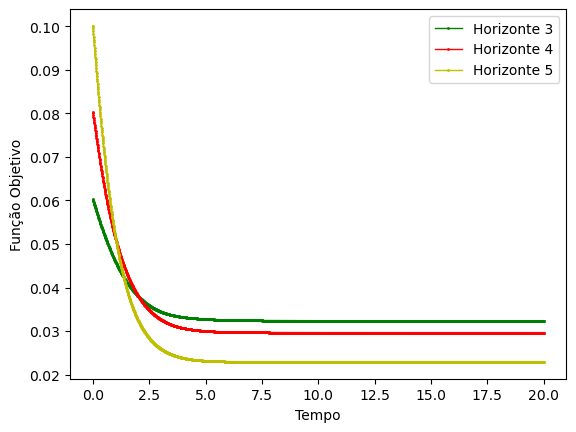

In [11]:
ts = np.linspace(0, 20, 2000) # Tempo em x 

# Plotagem
plt.ylabel('Função Objetivo') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(valoresFuncaoObjetivo3[0]), color='g', marker='o', linewidth=1, markersize=1, label="Horizonte 3")
plt.plot(ts, abs(valoresFuncaoObjetivo4[0]), color='r', marker='o', linewidth=1, markersize=1, label="Horizonte 4")
plt.plot(ts, abs(valoresFuncaoObjetivo5[0]), color='y', marker='o', linewidth=1, markersize=1, label="Horizonte 5")
plt.legend(loc="upper right")
plt.savefig('valoresFuncaoObjetivo1.png', format='png')
plt.show()

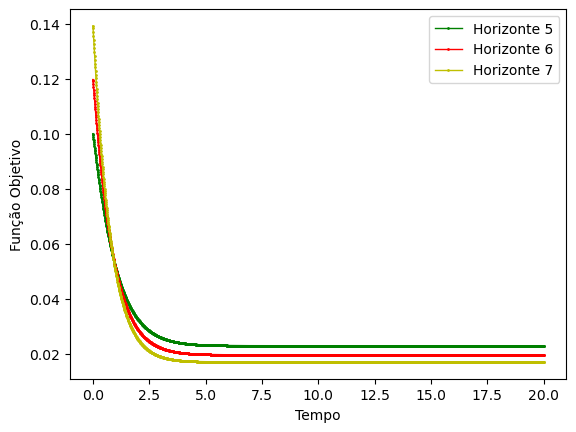

In [12]:
ts = np.linspace(0, 20, 2000) # Tempo em x 

# Plotagem
plt.ylabel('Função Objetivo') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(valoresFuncaoObjetivo5[0]), color='g', marker='o', linewidth=1, markersize=1, label="Horizonte 5")
plt.plot(ts, abs(valoresFuncaoObjetivo6[0]), color='r', marker='o', linewidth=1, markersize=1, label="Horizonte 6")
plt.plot(ts, abs(valoresFuncaoObjetivo7[0]), color='y', marker='o', linewidth=1, markersize=1, label="Horizonte 7")
plt.legend(loc="upper right")
plt.savefig('valoresFuncaoObjetivo2.png', format='png')
plt.show()

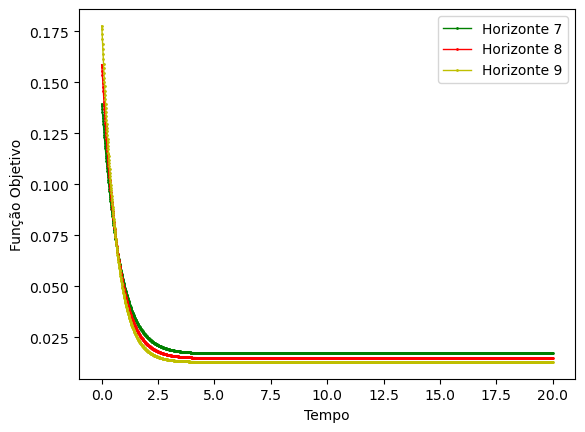

In [13]:
ts = np.linspace(0, 20, 2000) # Tempo em x 

# Plotagem
plt.ylabel('Função Objetivo') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(valoresFuncaoObjetivo7[0]), color='g', marker='o', linewidth=1, markersize=1, label="Horizonte 7")
plt.plot(ts, abs(valoresFuncaoObjetivo8[0]), color='r', marker='o', linewidth=1, markersize=1, label="Horizonte 8")
plt.plot(ts, abs(valoresFuncaoObjetivo9[0]), color='y', marker='o', linewidth=1, markersize=1, label="Horizonte 9")
plt.legend(loc="upper right")
plt.savefig('valoresFuncaoObjetivo3.png', format='png')
plt.show()

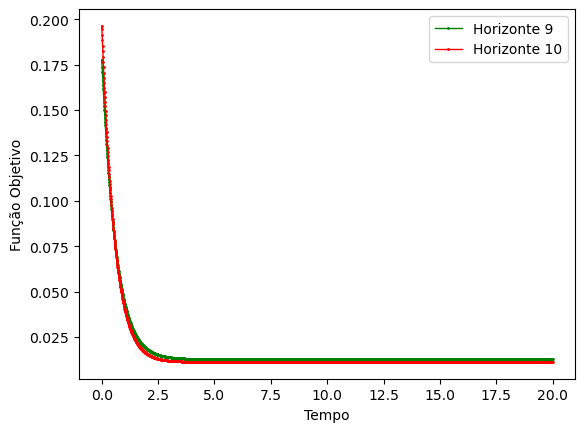

In [14]:
ts = np.linspace(0, 20, 2000) # Tempo em x 

# Plotagem
plt.ylabel('Função Objetivo') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(valoresFuncaoObjetivo9[0]), color='g', marker='o', linewidth=1, markersize=1, label="Horizonte 9")
plt.plot(ts, abs(valoresFuncaoObjetivo10[0]), color='r', marker='o', linewidth=1, markersize=1, label="Horizonte 10")
plt.legend(loc="upper right")
plt.savefig('valoresFuncaoObjetivo4.png', format='png')
plt.show()

### Avaliação das componentes

Um grande problemas dos métodos de minimização está concentrado no cálculo numérico. O cálculo númerico se trata de um processo de aproximação de forma que quanto pior é a manipulação das variáveis, pior ficará a aproximação. Nesse sistema se torna perceptível a melhoria do ajuste através da desafagem do ajuste.

Conforme o livro, introdução à computação clássica e quântica de Thomas Wong (2022), a defasagem apresentada por um sistema quântico não tem significado físico se for a mesma para todo o sistema, ou seja, todas as componentes devem ter a mesma diferença de fases. Para realizar essa avaliação, se faz necessário propor uma diferença entre a curva original e o destino, tanto na parte real quanto imaginária, além de realizar a diferença entre essas partes.

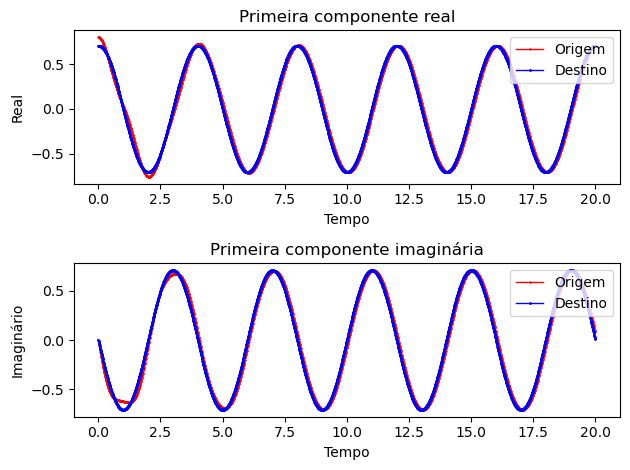

In [15]:
tempo = np.linspace(0, 20, 2000)

realObjetivoPrimeiraComponente = [elemento.real for elemento in valoresOnda3[0]] 
imaginarioObjetivoPrimeiraComponente = [elemento.imag for elemento in valoresOnda3[0]] 

realObjetivoSegundaComponente = [elemento.real for elemento in valoresOnda3[1]] 
imaginarioObjetivoSegundaComponente = [elemento.imag for elemento in valoresOnda3[1]] 

evolucaoDestino = np.zeros((2,2000), dtype=np.complex_)
for i in range(0, 2000):
    evolucaoDestino[0][i] = (1/np.sqrt(2)*np.exp(-1*complex(0,1)*(1/2*np.pi)*i/100))
    evolucaoDestino[1][i] = (1/np.sqrt(2)*np.exp(-1*complex(0,1)*(3/2*np.pi)*i/100))

realDestinoPrimeiraComponente = [elemento.real for elemento in evolucaoDestino[0]] 
imaginarioDestinoPrimeiraComponente = [elemento.imag for elemento in evolucaoDestino[0]] 

realDestinoSegundaComponente = [elemento.real for elemento in evolucaoDestino[1]] 
imaginarioDestinoSegundaComponente = [elemento.imag for elemento in evolucaoDestino[1]] 

defasagem3 = np.zeros((2,2000), dtype=np.complex_)
for i in range(0, 2000):
    defasagem3[0][i] = ((abs(valoresOnda3[0][i]) - abs(evolucaoDestino[0][i])))
    defasagem3[1][i] = ((abs(valoresOnda3[1][i]) - abs(evolucaoDestino[1][i])))

# Plotagem
plt.subplot(2,1,1)

plt.ylabel('Real') 
plt.xlabel('Tempo') 
plt.title('Primeira componente real')
plt.plot(ts, realObjetivoPrimeiraComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, realDestinoPrimeiraComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.subplot(2,1,2)

plt.ylabel('Imaginário') 
plt.xlabel('Tempo') 
plt.title('Primeira componente imaginária')
plt.plot(ts, imaginarioObjetivoPrimeiraComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, imaginarioDestinoPrimeiraComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.tight_layout()

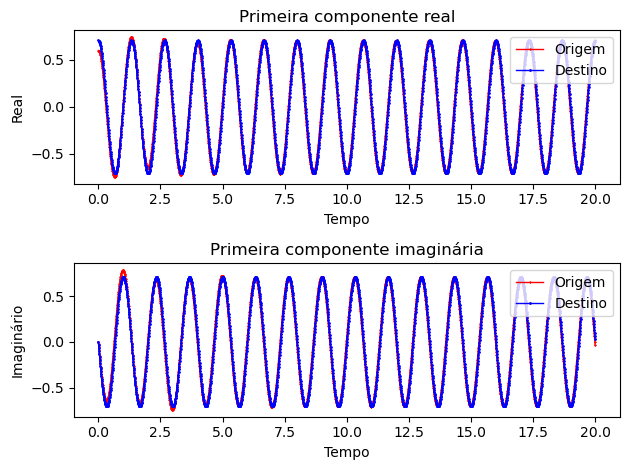

In [16]:
# Plotagem
plt.subplot(2,1,1)

plt.ylabel('Real') 
plt.xlabel('Tempo') 
plt.title('Primeira componente real')
plt.plot(ts, realObjetivoSegundaComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, realDestinoSegundaComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.subplot(2,1,2)

plt.ylabel('Imaginário') 
plt.xlabel('Tempo') 
plt.title('Primeira componente imaginária')
plt.plot(ts, imaginarioObjetivoSegundaComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, imaginarioDestinoSegundaComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.tight_layout()

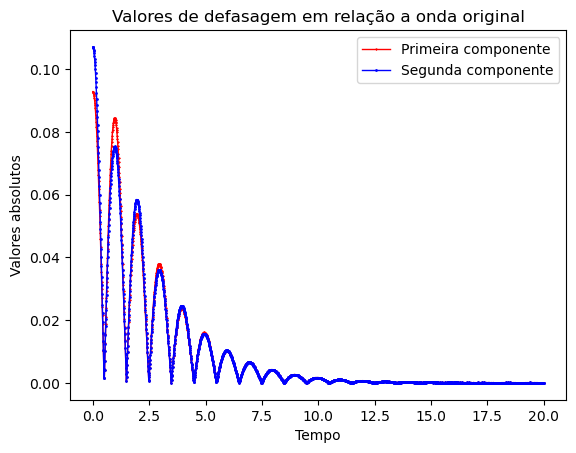

In [17]:
plt.ylabel('Valores absolutos') 
plt.xlabel('Tempo') 
plt.title('Valores de defasagem em relação a onda original')
plt.plot(ts, abs(defasagem3[0]), color='r', marker='*', linewidth=1, markersize=1, label="Primeira componente")
plt.plot(ts, abs(defasagem3[1]), color='b', marker='o',  linewidth=1, markersize=1, label="Segunda componente")
plt.legend(loc='upper right')

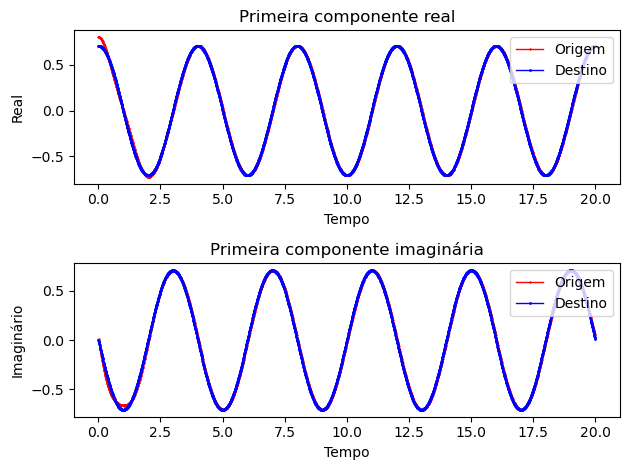

In [18]:
tempo = np.linspace(0, 20, 2000)

realObjetivoPrimeiraComponente = [elemento.real for elemento in valoresOnda10[0]] 
imaginarioObjetivoPrimeiraComponente = [elemento.imag for elemento in valoresOnda10[0]] 

realObjetivoSegundaComponente = [elemento.real for elemento in valoresOnda10[1]] 
imaginarioObjetivoSegundaComponente = [elemento.imag for elemento in valoresOnda10[1]] 

evolucaoDestino = np.zeros((2,2000), dtype=np.complex_)
for i in range(0, 2000):
    evolucaoDestino[0][i] = (1/np.sqrt(2)*np.exp(-1*complex(0,1)*(1/2*np.pi)*i/100))
    evolucaoDestino[1][i] = (1/np.sqrt(2)*np.exp(-1*complex(0,1)*(3/2*np.pi)*i/100))

realDestinoPrimeiraComponente = [elemento.real for elemento in evolucaoDestino[0]] 
imaginarioDestinoPrimeiraComponente = [elemento.imag for elemento in evolucaoDestino[0]] 

realDestinoSegundaComponente = [elemento.real for elemento in evolucaoDestino[1]] 
imaginarioDestinoSegundaComponente = [elemento.imag for elemento in evolucaoDestino[1]] 

defasagem10 = np.zeros((2,2000), dtype=np.complex_)
for i in range(0, 2000):
    defasagem10[0][i] = ((abs(valoresOnda10[0][i]) - abs(evolucaoDestino[0][i])))
    defasagem10[1][i] = ((abs(valoresOnda10[1][i]) - abs(evolucaoDestino[1][i])))

# Plotagem
plt.subplot(2,1,1)

plt.ylabel('Real') 
plt.xlabel('Tempo') 
plt.title('Primeira componente real')
plt.plot(ts, realObjetivoPrimeiraComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, realDestinoPrimeiraComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.subplot(2,1,2)

plt.ylabel('Imaginário') 
plt.xlabel('Tempo') 
plt.title('Primeira componente imaginária')
plt.plot(ts, imaginarioObjetivoPrimeiraComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, imaginarioDestinoPrimeiraComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.tight_layout()

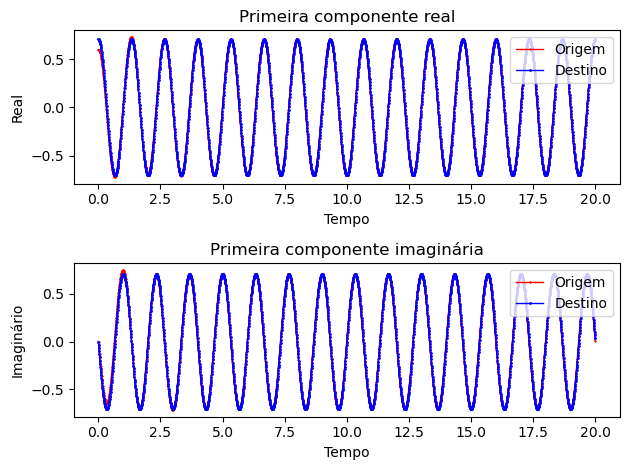

In [19]:
# Plotagem
plt.subplot(2,1,1)

plt.ylabel('Real') 
plt.xlabel('Tempo') 
plt.title('Primeira componente real')
plt.plot(ts, realObjetivoSegundaComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, realDestinoSegundaComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.subplot(2,1,2)

plt.ylabel('Imaginário') 
plt.xlabel('Tempo') 
plt.title('Primeira componente imaginária')
plt.plot(ts, imaginarioObjetivoSegundaComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, imaginarioDestinoSegundaComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.tight_layout()

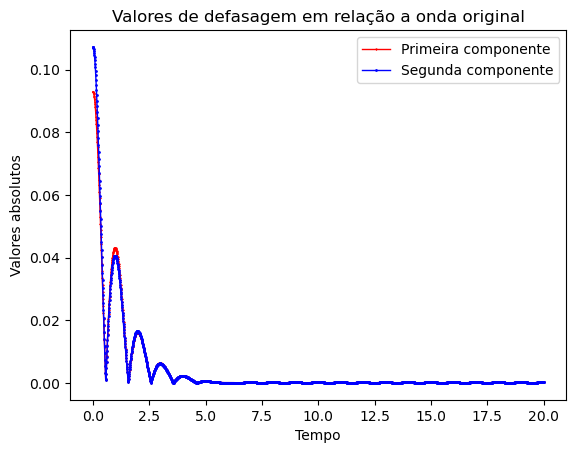

In [20]:
plt.ylabel('Valores absolutos') 
plt.xlabel('Tempo') 
plt.title('Valores de defasagem em relação a onda original')
plt.plot(ts, abs(defasagem10[0]), color='r', marker='*', linewidth=1, markersize=1, label="Primeira componente")
plt.plot(ts, abs(defasagem10[1]), color='b', marker='o',  linewidth=1, markersize=1, label="Segunda componente")
plt.legend(loc='upper right')

### Avaliação das constantes



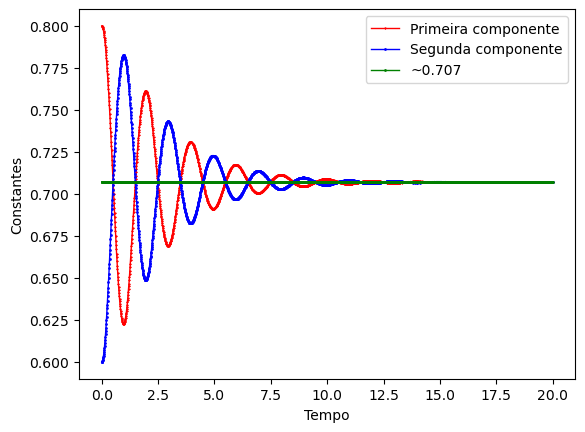

In [21]:
ts = np.linspace(0, 20, 2000) # Tempo em x 
const = []
for i in range(0, 2000):
    const.append(1/np.sqrt(2))

# Plotagem
plt.ylabel('Constantes') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(constantes3[0]), color='r', marker='*', linewidth=1, markersize=1, label="Primeira componente")
plt.plot(ts, abs(constantes3[1]), color='b', marker='o',  linewidth=1, markersize=1, label="Segunda componente")
plt.plot(ts, const, color='g', marker='o',  linewidth=1, markersize=1, label="~0.707")
plt.legend(loc="upper right")
plt.show()

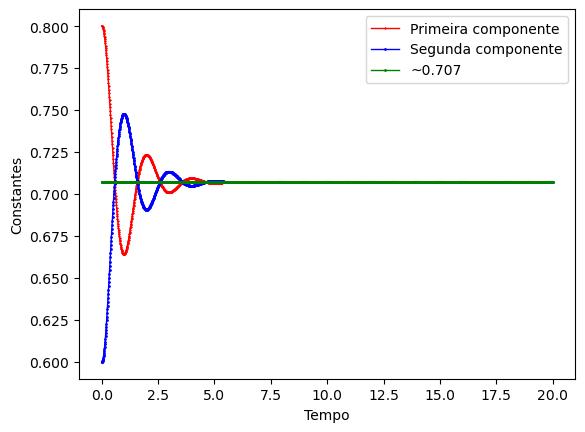

In [22]:
ts = np.linspace(0, 20, 2000) # Tempo em x 
const = []
for i in range(0, 2000):
    const.append(1/np.sqrt(2))

# Plotagem
plt.ylabel('Constantes') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(constantes10[0]), color='r', marker='*', linewidth=1, markersize=1, label="Primeira componente")
plt.plot(ts, abs(constantes10[1]), color='b', marker='o',  linewidth=1, markersize=1, label="Segunda componente")
plt.plot(ts, const, color='g', marker='o',  linewidth=1, markersize=1, label="~0.707")
plt.legend(loc="upper right")
plt.show()

### Gráficos - Avaliação da densidade de probabilidade para encontrar uma partícula no ponto x

Conforme descrito durante os capítulos 1, 2 e 3 do livro Mecânica Quântica por David Griffths, a estatística é um dos principais pontos para o entendimento da mecânica quântica, dessa forma é interessante entender qual é a probabilidade de uma partícula estar em um determinado lugar em um certo tempo e para tal se define:$$\int |\Psi(x,t)|^{2}dx = 1$$ Ainda nessa perspectiva, foi definido que o resultado da equação de Schrödinger pode ser definido a partir da escolha do potêncial V(x,t) e ainda que os enumeros resultados podem formar outros por meio de uma combinação linear de forma que o conjunto do quadrado das constantes que o formam, em sua soma resultam em 1. Isso define a probabilidade de um estado. Para este estudo considerou-se dois estados: $$0.80\psi_0(x,t)+0.60\psi_1(x,t)$$ de forma que para o primeiro estado a probabilidade é de 64% enquanto para o segundo é de 36%.

Se torna claro que a probabilidade total deve ser 1 e definindo o produto interno como $\int |\Psi(x,t)|^{2}dx = <\Psi | \Psi> = 1 = \sum_n |c_n|²$ podemos verificar se o ajuste da pesquisa está correto avaliando as constantes que são alteradas conforme o tempo de acordo com o gráfico apresentado acima.

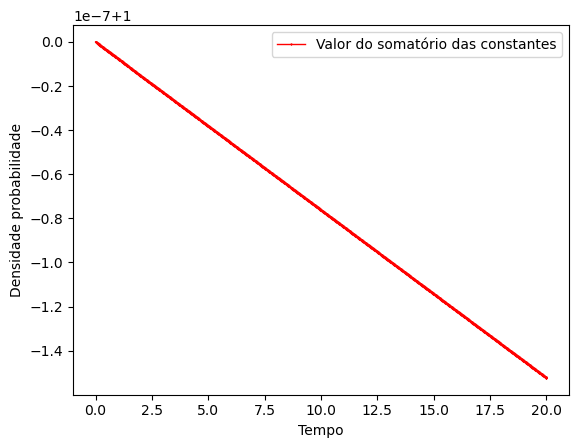

In [23]:
# Plotagem

dp = []
for i in range(0, 2000):
    dp.append((abs(constantes10[0][i])**2+abs(constantes10[1][i])**2))
    
plt.ylabel('Densidade probabilidade') 
plt.xlabel('Tempo') 
plt.plot(ts, dp, color='r', marker='*', linewidth=1, markersize=1, label="Valor do somatório das constantes")
plt.legend(loc="upper right")
plt.savefig('dp.png', format='png')
plt.show()